In [2]:
# Load standard modules
import os
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta
import xarray as xr
import zarr
import glob
import cmocean as cm

# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# cuda setup, set seed for reproducability 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(41)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")


# YOU NEED THIS TO LOAD PyTorch Lightning I DON"T KNOW WHY

from jupyter_client.manager import KernelManager
# Set torch dtype to float64
torch.set_default_dtype(torch.float64)

# Set model path
import sys
if os.path.exists('/home/tm3076/projects/NYU_SWOT_project/'):
    sys.path.append('/home/tm3076/projects/NYU_SWOT_project/Inpainting_Pytorch_gen/SWOT-inpainting-DL/src/')
else: 
    sys.path.append('/home.ufs/tm3076/swot_SUM03/SWOT_project/SWOT-inpainting-DL/src')
import simvip_model
import data_loaders
import interp_utils


Using device: cpu


/ext3/miniforge3/envs/swot_python12_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ext3/miniforge3/envs/swot_python12_pytorch/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if device == "cpu":
    n_cpus = 0
    multiprocessing = False
else:
    # Get available CPUs for parallel loading
    n_cpus = torch.get_num_threads()
    multiprocessing = True
print(f"Using device {device} on {n_cpus} cpus with multiprocessing={multiprocessing}")
device

Using device cpu on 0 cpus with multiprocessing=False


'cpu'

In [4]:
m = [0,1]
a = np.random.randint(2)
print(a)
print(int((a-1)**2))

0
1


In [5]:

import wandb

In [6]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tm3076 (tm3076-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
print(os.getcwd())

/scratch/projects/shaferlab/tatsu/NYU_SWOT_project/Inpainting_Pytorch_gen/Models/SimVip_May


In [8]:
from importlib import reload
simvip_model = reload(simvip_model)
data_loaders = reload(data_loaders)

# Choose the configu you want to test here:


In [9]:
from hydra import initialize, compose
from omegaconf import OmegaConf

# Suppose your config folder is named 'conf' and is in the current working directory
config_path = "conf"
config_name = "021_C3_config_05rho"
# Initialize the Hydra config search path
with initialize(config_path=config_path):
    # Compose the configuration
    cfg = compose(config_name=config_name)
# Display the configuration nicely
print(OmegaConf.to_yaml(cfg))


outdir: ./outputs_SimVip_July_10
data:
  dataset_path: /home/tm3076/scratch/pytorch_learning_tiles
  patch_coords_file: zarred_UVSST_x_y_coordinates_noland_nonan.npy
  infields:
  - zarr_llc4320_SSH_tiles_4km_filtered
  - zarr_llc4320_SST_tiles_4km
  outfields:
  - zarr_llc4320_SSH_tiles_4km_filtered
  in_mask_list:
  - swot_calval_nadir
  - cloud_rho
  out_mask_list:
  - None
  in_transform_list:
  - std_global_mean_ssh_norm
  - std_global_mean_sst_norm
  out_transform_list:
  - std_global_mean_ssh_norm
  mean_ssh: 0
  std_ssh: 0.0453692672359483
  mean_sst: 15.956900367755182
  std_sst: 5.987649544923141
  N_t: 10
  timesteps_range:
  - 30
  - 360
  - 5
  batch_size: 64
  return_masks: false
  cloud_rho: 0.5
model:
  Number_timesteps: 10
  alpha0: 1
  alpha1: 10
  alpha2: 10
  lr: 1.0e-06
  drop: 0.2
  drop_path: 0.15
  model_type: gSTA
  multiprocessing: true
  masked_loss: true
training:
  num_epochs: 100
  checkpoint_dir: checkpoints
wandb:
  model_name: ${hydra.job.name}_${now:%Y

# Define the dataloaders

In [10]:
data_loaders = reload(data_loaders)

In [11]:
DATASET_PATH = cfg.data.get("dataset_path",)
if os.path.exists('/home/tm3076/projects/NYU_SWOT_project/'):
    cfg.data["dataset_path"] = "/home/tm3076/scratch/pytorch_learning_tiles"
else: 
    cfg.data["dataset_path"] = "/home.ufs/tm3076/swot_SUM03/pytorch_learning_tiles"


In [12]:
cfg.data["dataset_path"]

'/home/tm3076/scratch/pytorch_learning_tiles'

In [13]:
DATASET_PATH

'/home/tm3076/scratch/pytorch_learning_tiles'

In [14]:
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [15]:
data_loaders = reload(data_loaders)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Modules for loading data, set data pathimport urllib
DATASET_PATH = cfg.data["dataset_path"] 
CHECKPOINT_PATH = cfg.training["checkpoint_dir"]

N_t = cfg.data["N_t"]
# Input fields
infields = cfg.data["infields"]
outfields = cfg.data["outfields"]
in_mask_list = cfg.data["in_mask_list"]
out_mask_list = cfg.data["out_mask_list"]
# Pre-computed global normalisation stats and transforms
in_transform_list = cfg.data["in_transform_list"]
out_transform_list = cfg.data["out_transform_list"]
cloud_rho = cfg.data["cloud_rho"]

# Prepare standards for transforms
standards = {
            "mean_ssh":  cfg.data["mean_ssh"], "std_ssh": cfg.data["std_ssh"],
            "mean_sst": cfg.data["mean_sst"], "std_sst": cfg.data["std_sst"]
            }

if os.path.exists('/home/tm3076/projects/NYU_SWOT_project/'):
    patch_coords = zarr.load(f'{DATASET_PATH}/x_y_coordinates_noland.zarr')
else: 
    patch_coords = np.load(f'{DATASET_PATH}/zarred_UVSST_x_y_coordinates_noland_nonan.npy')
    
batch_size = 5#cfg.data["batch_size"]

# Data loader 
full_dataset = torch.utils.data.ConcatDataset([data_loaders.llc4320_dataset(DATASET_PATH, i_mid_timestep, N_t, patch_coords, 
                                                                            infields, outfields, in_mask_list, out_mask_list, 
                                                                            in_transform_list, out_transform_list, standards=standards,
                                                                            multiprocessing = multiprocessing, cloud_rho=cloud_rho, return_metadata=True,
                                                                            time_loading=True
                                                                           ) for i_mid_timestep in range(30,360,5)])

# Split into train, validation, and test data
train_length = int(0.7*len(full_dataset))
validation_length = int(0.2*len(full_dataset))
test_length = len(full_dataset) - train_length - validation_length
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, (train_length, validation_length, test_length))

# Verify size of datasets
print(f"size train_dataset: {len(train_dataset)}")
print(f"size validation_dataset: {len(validation_dataset)}")
print(f"size test_dataset: {len(test_dataset)}")

def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing, pin_memory=True)
val_data_loader   = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing, pin_memory=True)
test_data_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing, pin_memory=True)


size train_dataset: 16678
size validation_dataset: 4765
size test_dataset: 2383


In [18]:
for (x,y,m) in train_data_loader:
    break

[Timer] Mask 'swot_calval_nadir' generated in 4.960 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'swot_calval_nadir' applied in 4.961 sec
[Timer] Mask 'cloud_rho' generated in 6.343 sec
[Timer] Field 'zarr_llc4320_SST_tiles_4km' loaded and mask 'cloud_rho' applied in 6.343 sec
[Timer] Input vars + masks loaded in 6.707 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'None' applied in 6.716 sec
[Timer] Output vars + masks loaded in 0.029 sec
[Timer] Total __getitem__ duration: 6.737 sec
[Timer] Mask 'swot_calval_nadir' generated in 1.628 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'swot_calval_nadir' applied in 1.628 sec
[Timer] Mask 'cloud_rho' generated in 2.984 sec
[Timer] Field 'zarr_llc4320_SST_tiles_4km' loaded and mask 'cloud_rho' applied in 2.984 sec
[Timer] Input vars + masks loaded in 3.414 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'None' applied in 3.422 sec
[Timer] Ou

In [19]:
print((x*torch.tensor([1])).shape)
print(x.shape)

torch.Size([5, 10, 2, 128, 128])
torch.Size([5, 10, 2, 128, 128])


## Verify Dataloader is working as expected

In [20]:
PATH = "/scratch/projects/shaferlab/tatsu/NYU_SWOT_project/Inpainting_Pytorch_gen/SWOT-inpainting-DL/data"
daily_climatology = xr.open_dataset(f"{PATH}/SST_NP_daily_climatology.nc")

In [21]:
y.shape

torch.Size([5, 10, 1, 128, 128])

SSH swath std tensor(0.0630)
SST truth std tensor(0.2991)
SSH truth std tensor(0.8421)


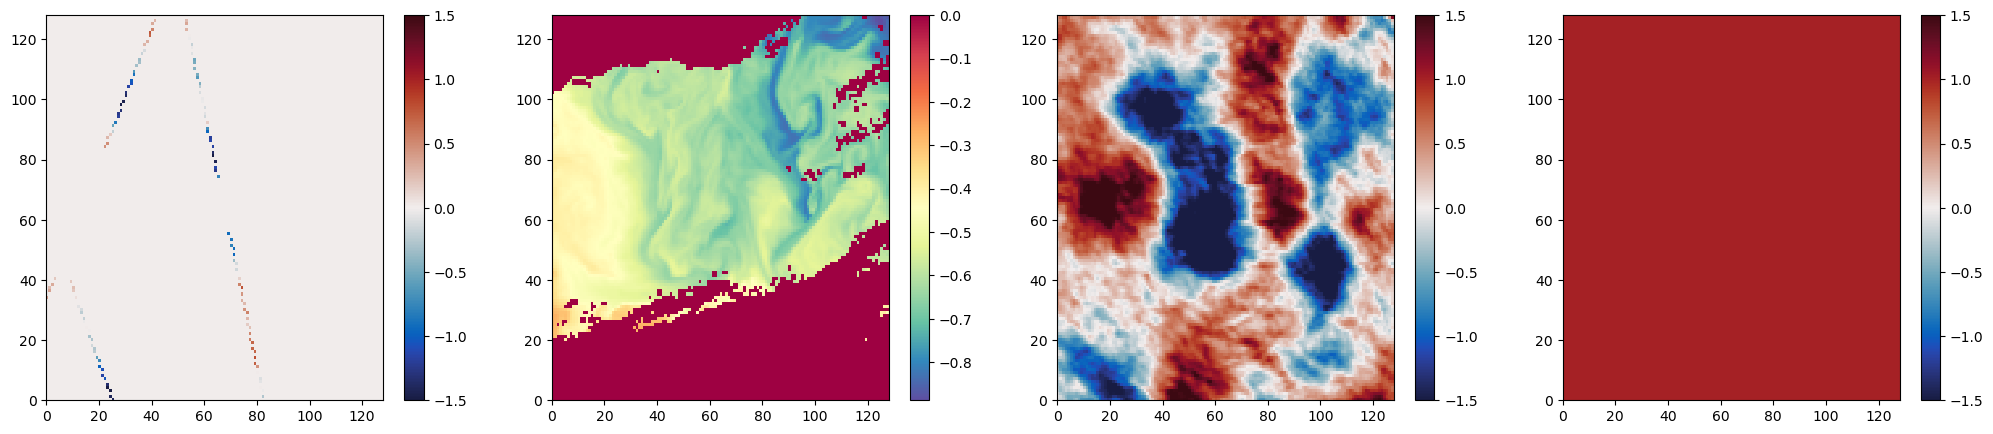

SSH swath std tensor(0.4451)
SST truth std tensor(0.6016)
SSH truth std tensor(0.8017)


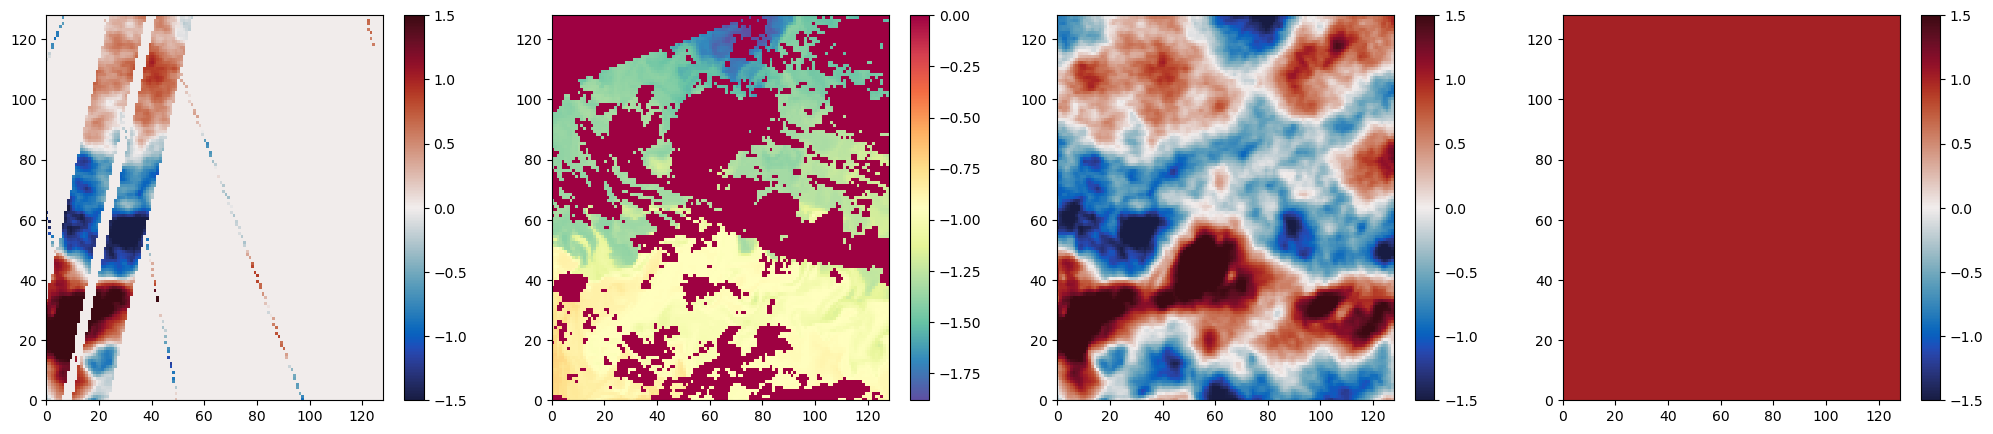

SSH swath std tensor(0.3125)
SST truth std tensor(0.2762)
SSH truth std tensor(0.5819)


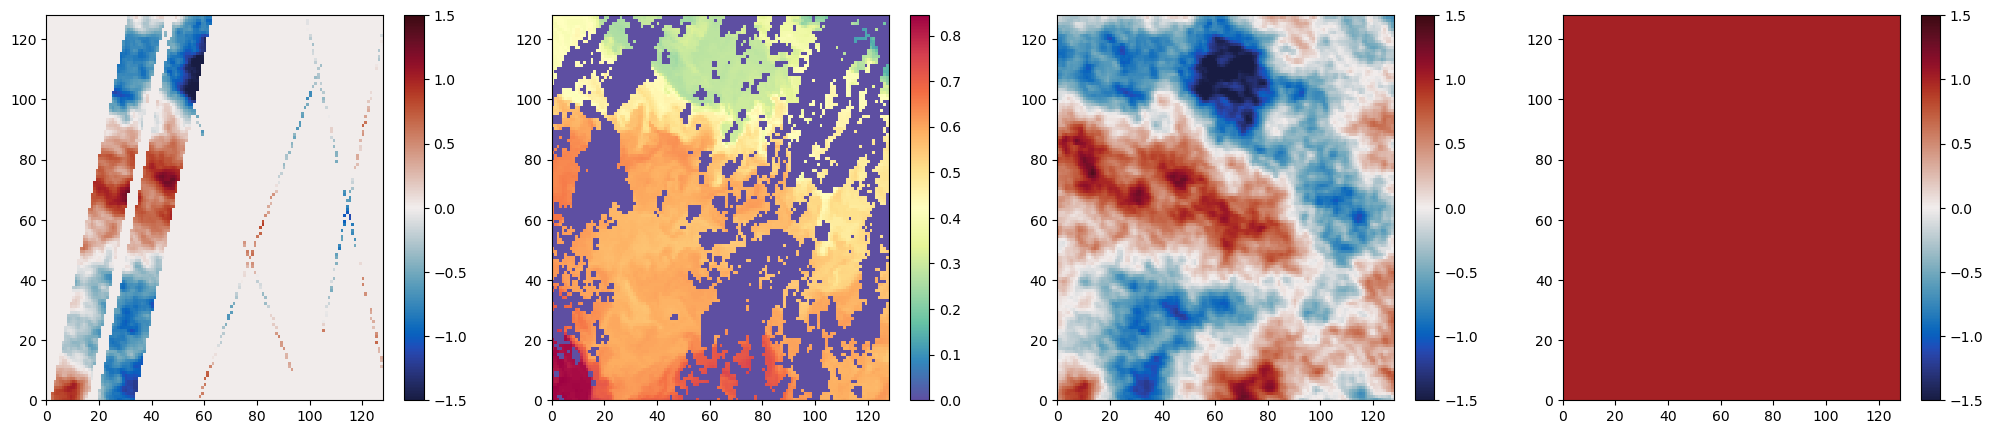

SSH swath std tensor(0.0805)
SST truth std tensor(0.6255)
SSH truth std tensor(0.7039)


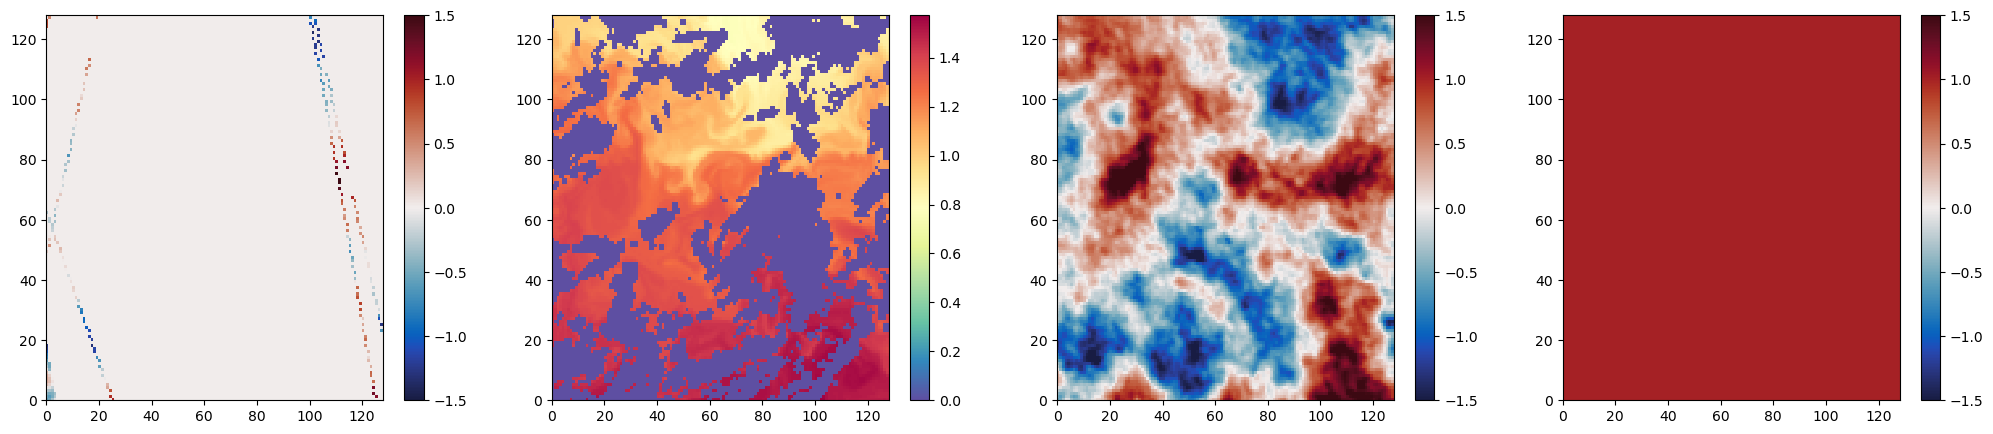

SSH swath std tensor(0.7438)
SST truth std tensor(0.5682)
SSH truth std tensor(1.4840)


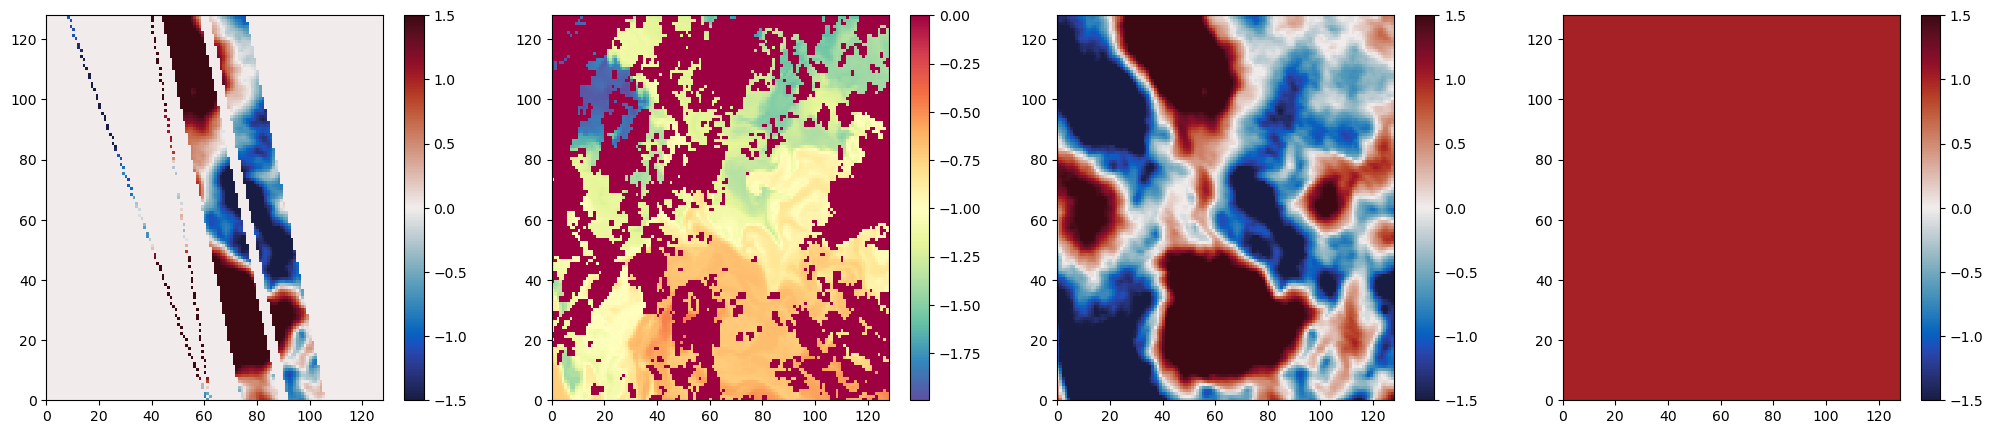

In [22]:
ssh_vminmax = 1.5
N_t = cfg.data["N_t"]

for i in range(len(x)):
    fig, axs = plt.subplots(1,4,figsize=(25,5))
    print("SSH swath std",torch.std(x[i,int(N_t/2),0,:,:]))
    print("SST truth std",torch.std(x[i,int(N_t/2),1,:,:]))
    print("SSH truth std",torch.std(y[i,int(N_t/2),0,:,:]))
    ims = [axs[0].pcolor(x[i,int(N_t/2),0,:,:],cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           #axs[1].pcolor(np.where(x[i,int(N_t/2),1,:,:]==0,np.nan,x[i,int(N_t/2),1,:,:]),cmap="Spectral_r"),
           axs[1].pcolor(x[i,int(N_t/2),1,:,:],cmap="Spectral_r"),
           axs[2].pcolor(y[i,int(N_t/2),0,:,:],cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           axs[3].pcolor(y[i,int(N_t/2),0,:,:]!=0,cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           ]
    for i, im in enumerate(ims):
        fig.colorbar(im,ax=axs[i])
    plt.show()
    plt.close()
    

SSH swath std tensor(0.4309)
SST truth std tensor(0.2114)
SSH truth std tensor(0.8593)


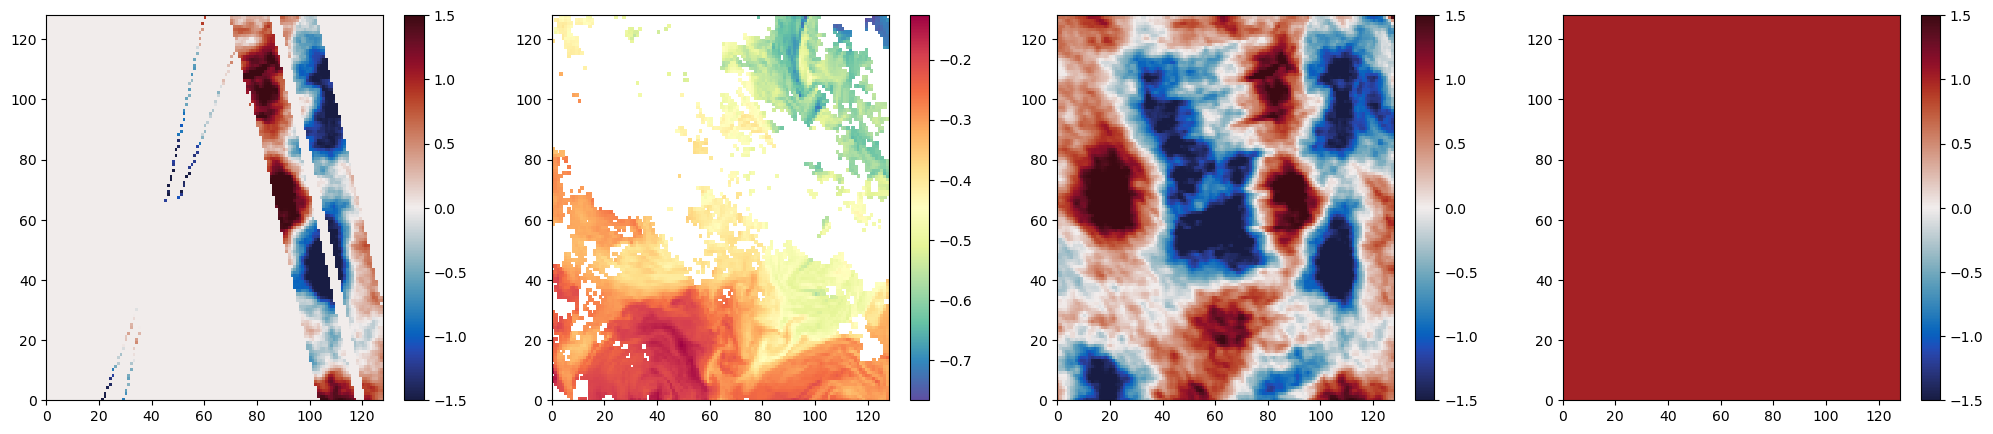

SSH swath std tensor(0.0846)
SST truth std tensor(0.2450)
SSH truth std tensor(0.8766)


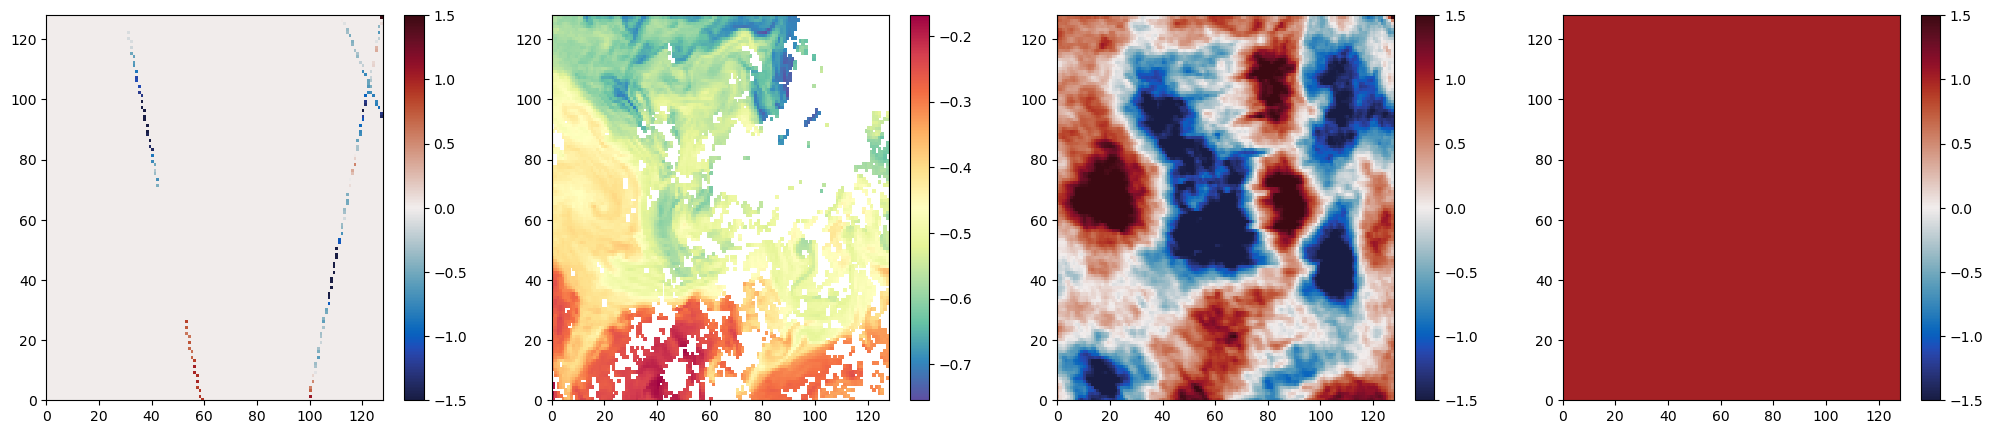

SSH swath std tensor(0.4109)
SST truth std tensor(0.2606)
SSH truth std tensor(0.8511)


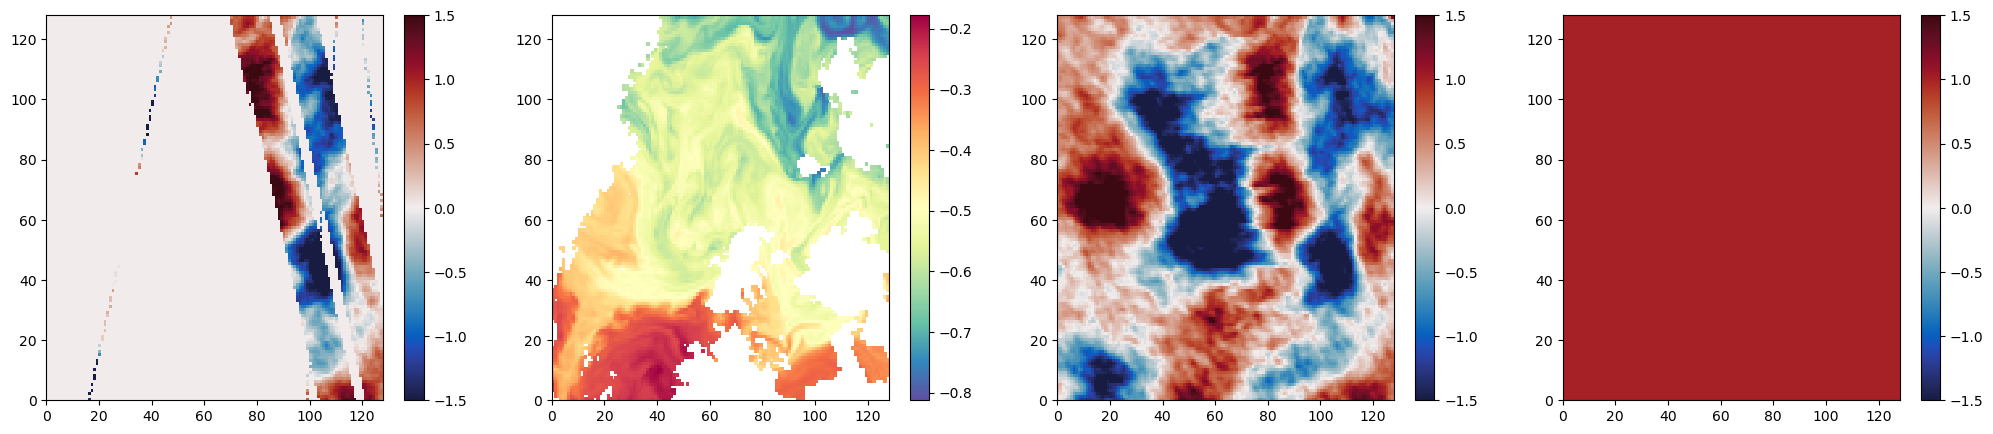

SSH swath std tensor(0.0829)
SST truth std tensor(0.2533)
SSH truth std tensor(0.8591)


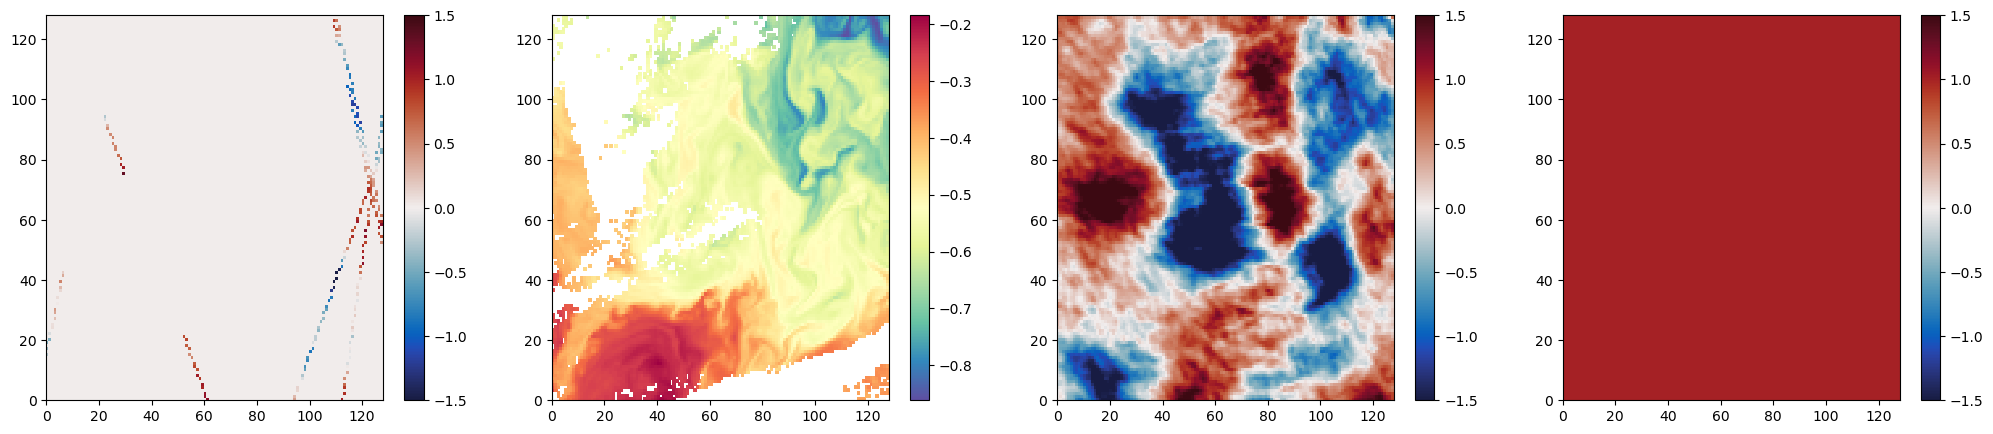

SSH swath std tensor(0.3842)
SST truth std tensor(0.2792)
SSH truth std tensor(0.8396)


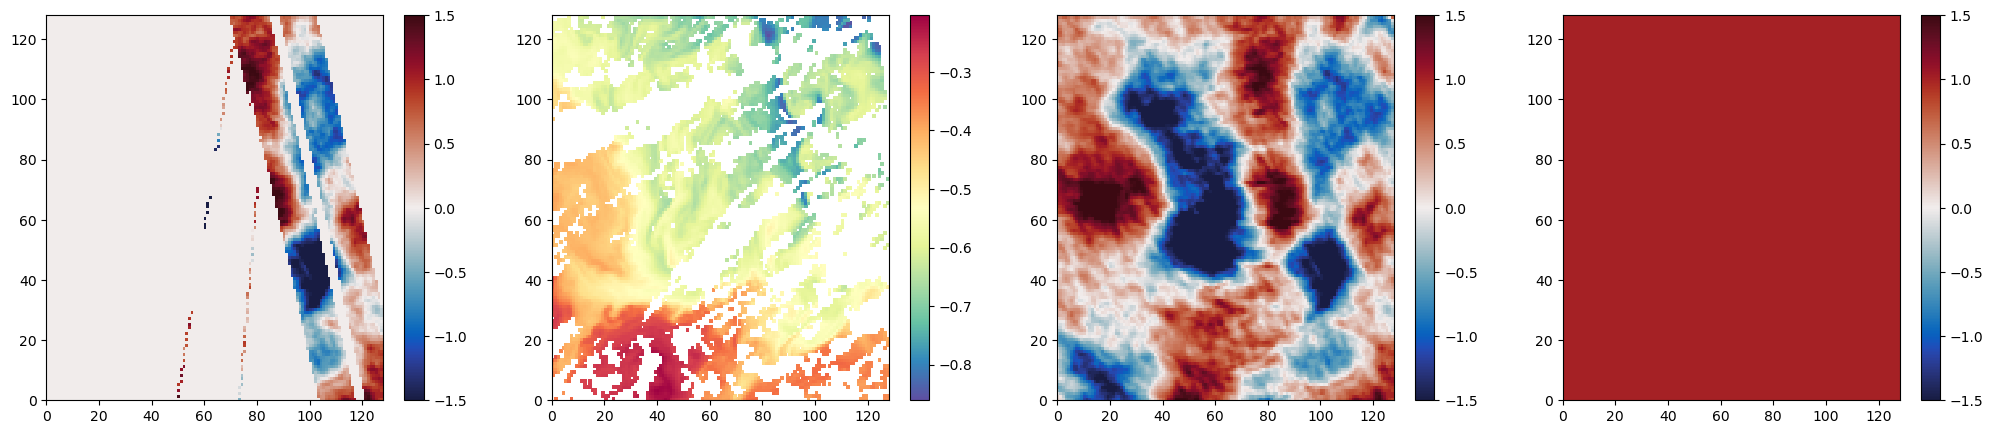

SSH swath std tensor(0.0630)
SST truth std tensor(0.2991)
SSH truth std tensor(0.8421)


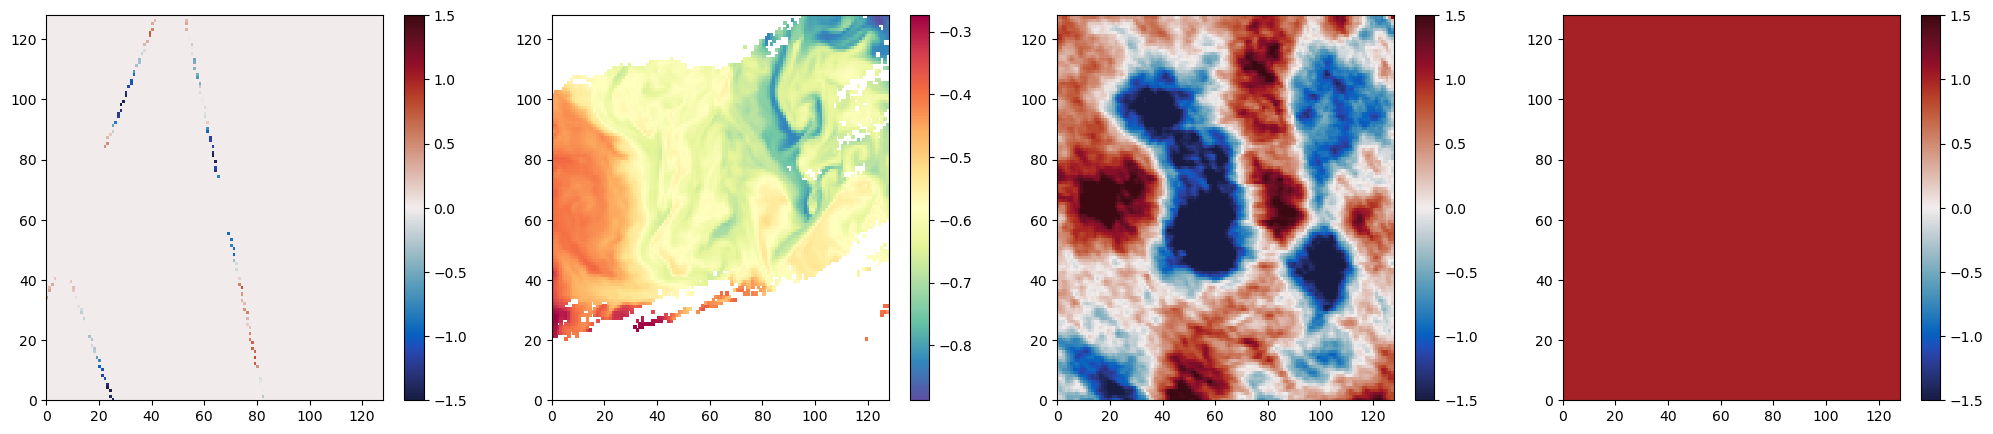

SSH swath std tensor(0.3926)
SST truth std tensor(0.2905)
SSH truth std tensor(0.8240)


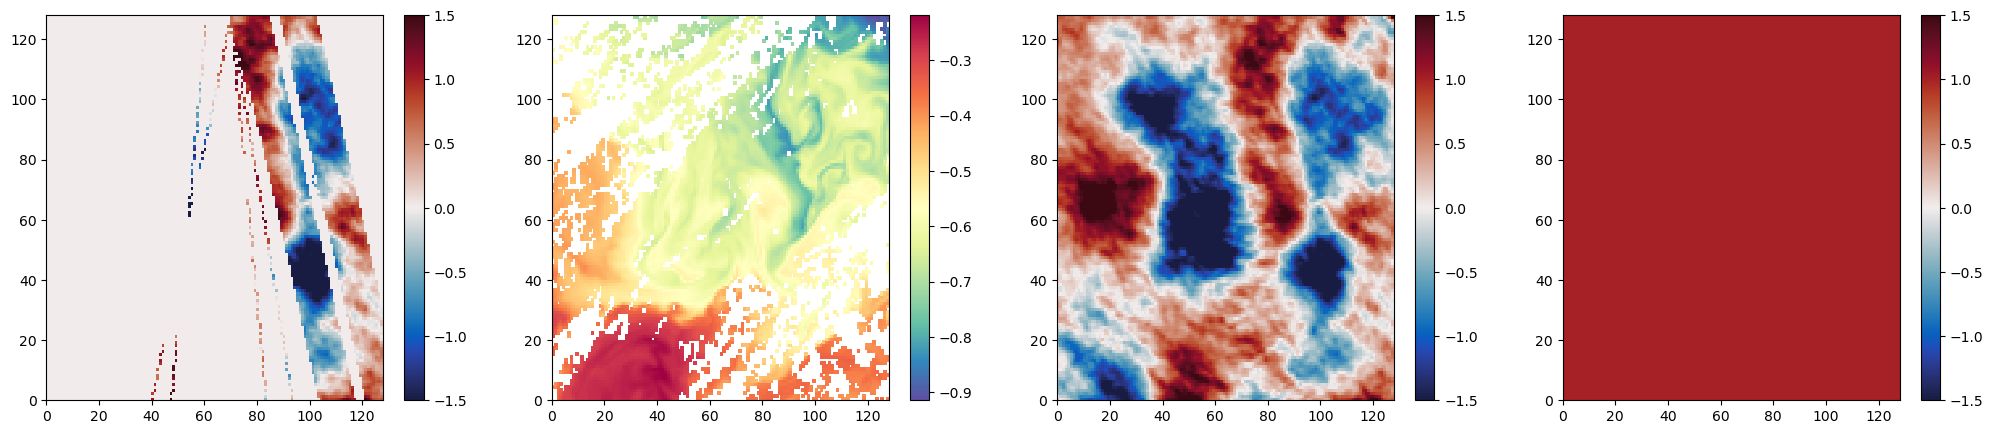

SSH swath std tensor(0.0294)
SST truth std tensor(0.2648)
SSH truth std tensor(0.8250)


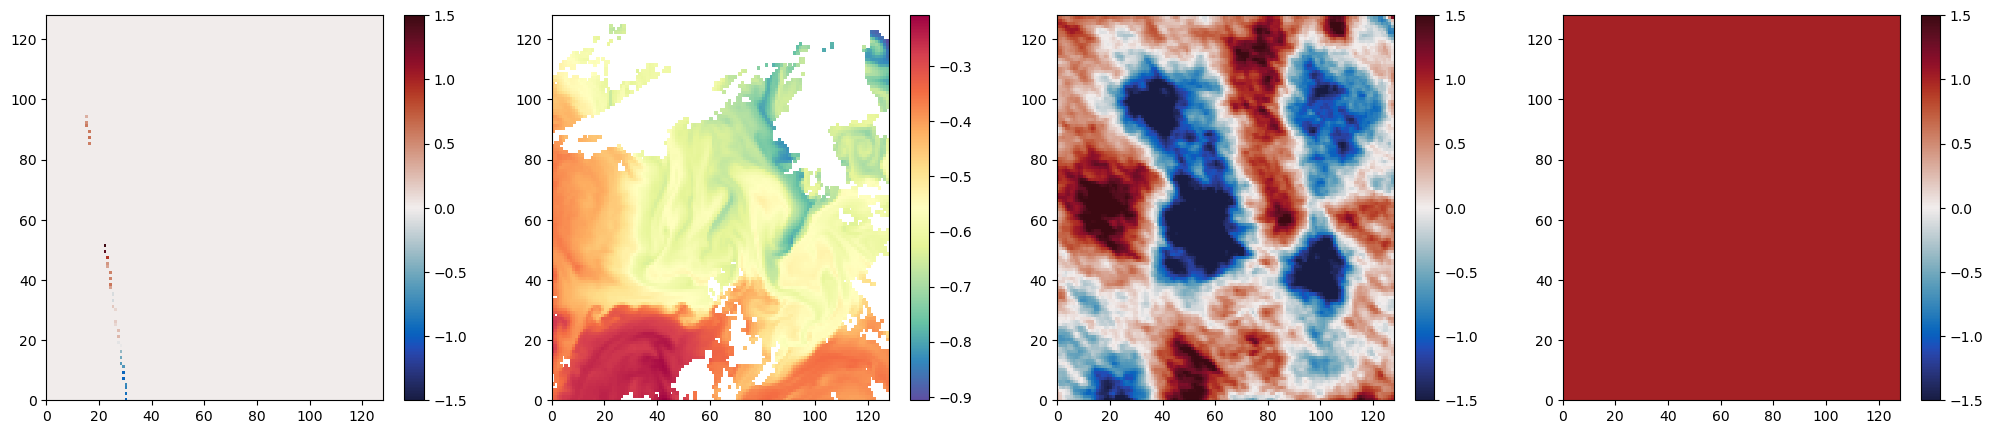

SSH swath std tensor(0.3963)
SST truth std tensor(0.2729)
SSH truth std tensor(0.8330)


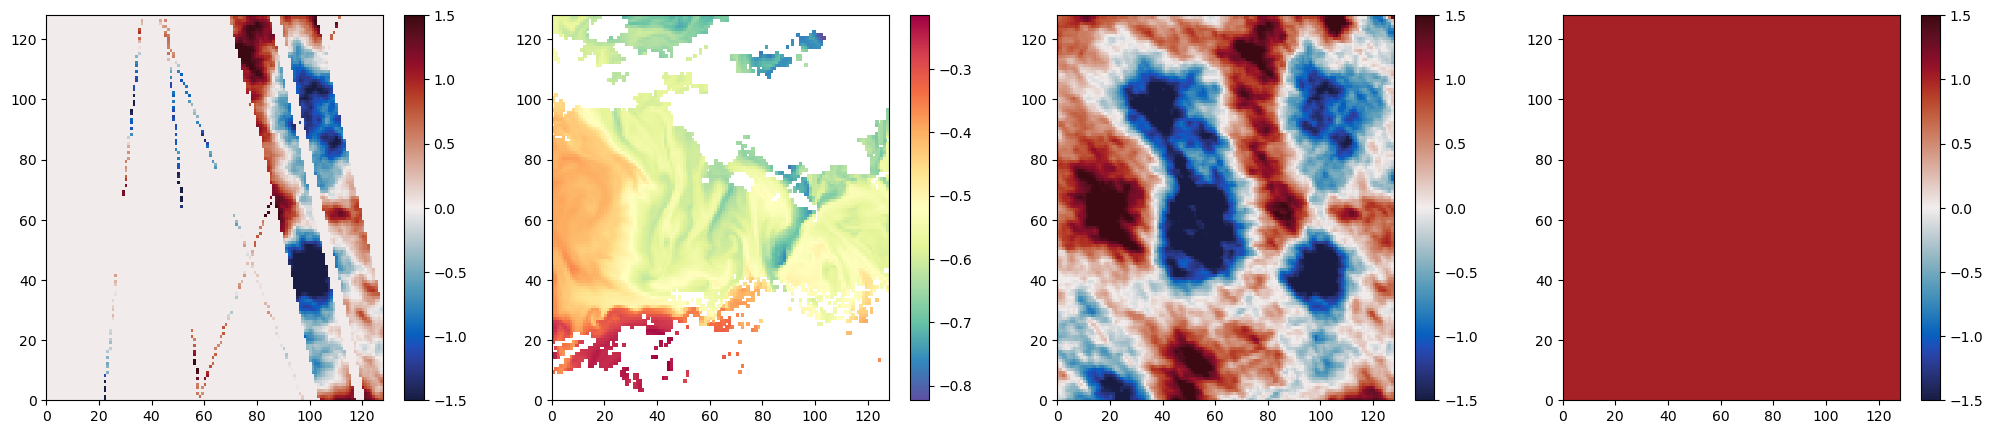

SSH swath std tensor(0.0754)
SST truth std tensor(0.2750)
SSH truth std tensor(0.8442)


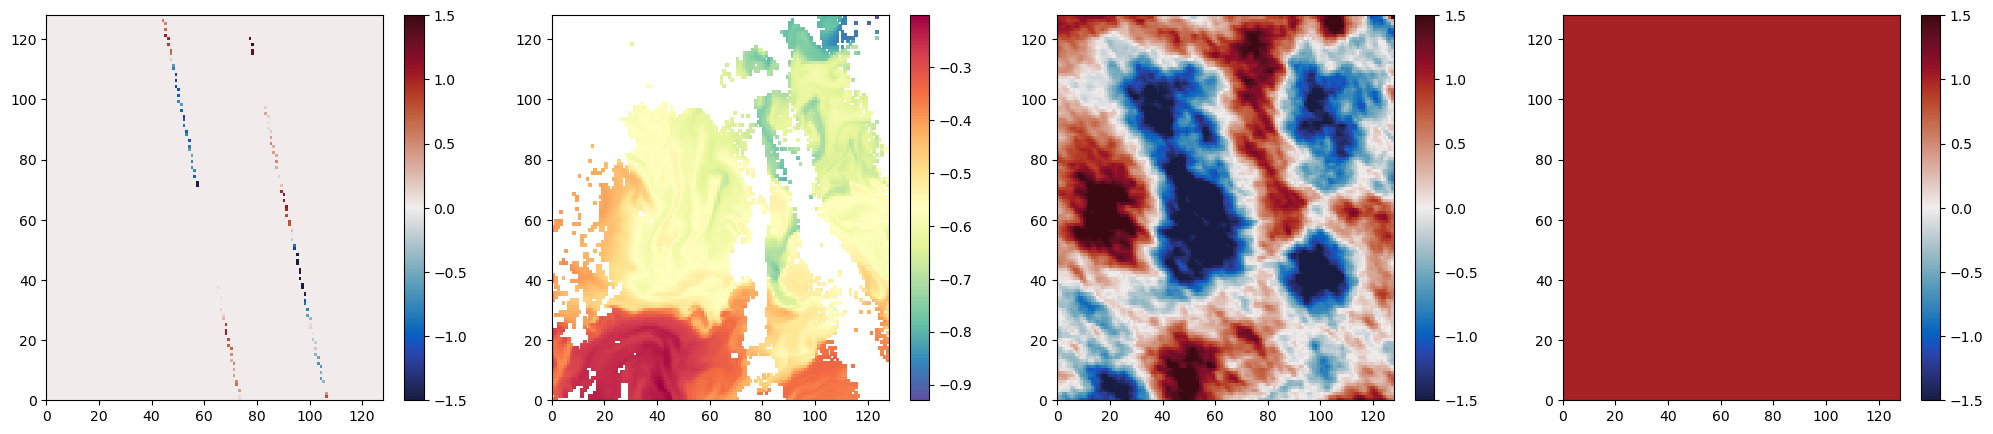

In [24]:
ssh_vminmax = 1.5
i_x = 0

for i in range(len(x[0])):
    fig, axs = plt.subplots(1,4,figsize=(25,5))
    print("SSH swath std",torch.std(x[i_x,i,0,:,:]))
    print("SST truth std",torch.std(x[i_x,i,1,:,:]))
    print("SSH truth std",torch.std(y[i_x,i,0,:,:]))
    ims = [axs[0].pcolor(x[i_x,i,0,:,:],cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           axs[1].pcolor(np.where(x[i_x,i,1,:,:]==0,np.nan,x[i_x,i,1,:,:]),cmap="Spectral_r"),
           axs[2].pcolor(y[i_x,i,0,:,:],cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           axs[3].pcolor(y[i_x,i,0,:,:]!=0,cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           ]
    for i, im in enumerate(ims):
        fig.colorbar(im,ax=axs[i])
    plt.show()
    plt.close()
    

# Test SWOT Mask Sampling

In [25]:
DATASET_PATH = cfg.data["dataset_path"] 

In [84]:
# Preload SWOT swaths
worker_generic_swath0 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p015.zarr")
worker_generic_swath1 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p028.zarr")

worker_generic_swath0 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p015.zarr")
worker_generic_swath1 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p028.zarr")


def get_random_swot_mask(version="random", sampling="all", N=1024, L_x=2048e3, L_y=2048e3, N_t=1,return_ms=False):
    # Helper function to generate a SWOT-like mask
    sw_corner = [-154.5, 34.3]
    ne_corner = [-147.5, 44.3]
    lat_max = None#9000
    lat_min = None#2000
    l_step = 1
    lon = np.random.uniform(sw_corner[0], ne_corner[0])
    lat = np.random.uniform(sw_corner[1], ne_corner[1])
    if version == "random":
        nrand = np.random.randint(2)
        if nrand == 0:
            m0 = interp_utils.grid_everything(worker_generic_swath0.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
        else:
            m0 = interp_utils.grid_everything(worker_generic_swath1.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
        mask = (m0.fillna(0)).values > 0
    elif version == "calval":
        ms = [interp_utils.grid_everything(worker_generic_swath0.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y),
              interp_utils.grid_everything(worker_generic_swath1.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
             ]
        a0 = np.random.randint(2)
        a1 = int((a0-1)**2)
        if return_ms:
            return ms
        calval_mask = torch.stack([torch.tensor(ms[a0].fillna(0).values > 0), torch.tensor(ms[a1].fillna(0).values > 0)])
        if N_t > 1:
            mask_broadcast = torch.broadcast_to(calval_mask,(N_t//2+N_t%2,2,N,N))
            mask = mask_broadcast.reshape(N_t+N_t%2,N,N)[:N_t]
        else:
            mask = calval_mask[0]
        return mask
    if sampling=="all":
        return torch.tensor(mask)
    elif sampling=="central":
        mask_N_t = torch.zeros([N_t]+list(mask.size()))
        mask_N_t[int(N_t/2),:,:] = mask
        return torch.tensor(mask_N_t)
    elif sampling=="random":
        mask_N_t = torch.zeros([N_t]+list(mask.size()))
        mask_N_t[np.random.nandint(N_t),:,:] = mask
        return torch.tensor(mask_N_t)



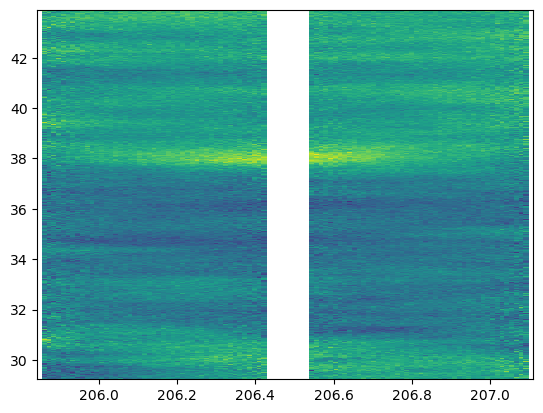

In [61]:
lat_max = 9000
lat_min = 2000
plt.pcolor(worker_generic_swath0.longitude.isel(num_lines=0)[::5],
           worker_generic_swath0.latitude.isel(num_pixels=240)[lat_min:lat_max:5],
           worker_generic_swath0.ssha[lat_min:lat_max:5,::5])

In [62]:
"""
#Some work I did on the Greene data_loader on accident
    def get_random_swot_mask(self, version="random", sampling="all"):
        # Helper function to generate a SWOT-like mask
        sw_corner = [-154.0, 30.3]
        ne_corner = [-148.5, 42.3]
        lon = np.random.uniform(sw_corner[0], ne_corner[0])
        lat = np.random.uniform(sw_corner[1], ne_corner[1])
        if version == "random":
            nrand = np.random.randint(2)
            if nrand == 0:
                m0 = interp_utils.grid_everything(self.worker_generic_swath0, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
            else:
                m0 = interp_utils.grid_everything(self.worker_generic_swath1, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
            mask = (m0.ssha.fillna(0)).values > 0
        elif version == "both":
            m0 = interp_utils.grid_everything(self.worker_generic_swath0, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
            m1 = interp_utils.grid_everything(self.worker_generic_swath1, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
            mask = (m0.ssha.fillna(0) + m1.ssha.fillna(0)).values > 0
        elif version == "calval":
            ms = [interp_utils.grid_everything(self.worker_generic_swath0, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y),
                  interp_utils.grid_everything(self.worker_generic_swath1, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
                 ]
            a0 = np.random.randint(2)
            a1 = int((a0-1)**2)
            mask = torch.stack([torch.tensor(ms[a0].ssha.fillna(0).values > 0), torch.tensor(ms[a1].ssha.fillna(0).values > 0)])
        elif version == "science":
            m0 = interp_utils.grid_everything(self.worker_generic_swath0, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
            m1 = interp_utils.grid_everything(self.worker_generic_swath1, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)
            
            mask = (m0.ssha.fillna(0) + m1.ssha.fillna(0)).values > 0            
        mask = torch.tensor(mask)
        if sampling=="all":
            return torch.tensor(mask)
        elif sampling=="central":
            mask_N_t = torch.zeros([self.N_t]+list(mask.size()))
            mask_N_t[int(self.N_t/2),:,:] = mask
            return torch.tensor(mask_N_t)
        elif sampling=="random":
            mask_N_t = torch.zeros([self.N_t]+list(mask.size()))
            mask_N_t[np.random.nandint(self.N_t),:,:] = mask
            return torch.tensor(mask_N_t)
        elif sampling=="random":
            mask_N_t = torch.zeros([self.N_t]+list(mask.size()))
            mask_N_t[np.random.nandint(self.N_t),:,:] = mask
            return torch.tensor(mask_N_t)

"""

'\n#Some work I did on the Greene data_loader on accident\n    def get_random_swot_mask(self, version="random", sampling="all"):\n        # Helper function to generate a SWOT-like mask\n        sw_corner = [-154.0, 30.3]\n        ne_corner = [-148.5, 42.3]\n        lon = np.random.uniform(sw_corner[0], ne_corner[0])\n        lat = np.random.uniform(sw_corner[1], ne_corner[1])\n        if version == "random":\n            nrand = np.random.randint(2)\n            if nrand == 0:\n                m0 = interp_utils.grid_everything(self.worker_generic_swath0, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)\n            else:\n                m0 = interp_utils.grid_everything(self.worker_generic_swath1, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)\n            mask = (m0.ssha.fillna(0)).values > 0\n        elif version == "both":\n            m0 = interp_utils.grid_everything(self.worker_generic_swath0, lat, lon, n=self.N, L_x=self.L_x, L_y=self.L_y)\n            m1 = interp_utils.grid_ev

In [63]:
random_masks = []
for i in range(10):
    print(i,end=", ")
    random_masks.append(get_random_swot_mask(version="calval",N_t=6))
random_masks = np.asarray(random_masks)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [89]:
random_swaths = []
for i in range(10):
    print(i,end=", ")
    swaths = get_random_swot_mask(version="calval",N_t=2,return_ms=True)
    random_swaths.append(xr.concat(swaths,dim="swath"))

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [64]:
random_masks = np.asarray(random_masks)

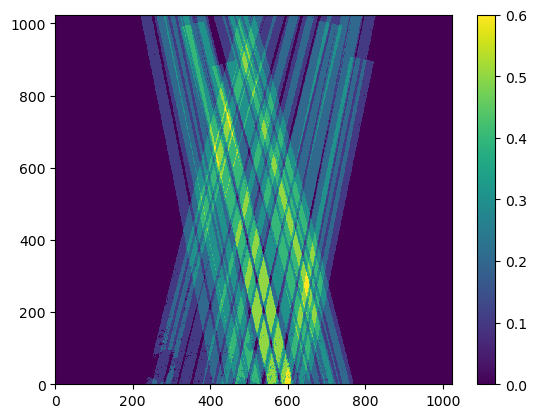

In [66]:
plt.pcolor(np.sum(random_masks[:,:2],axis=(0,1))/10)
plt.colorbar()

In [72]:
random_masks.shape

(10, 6, 1024, 1024)

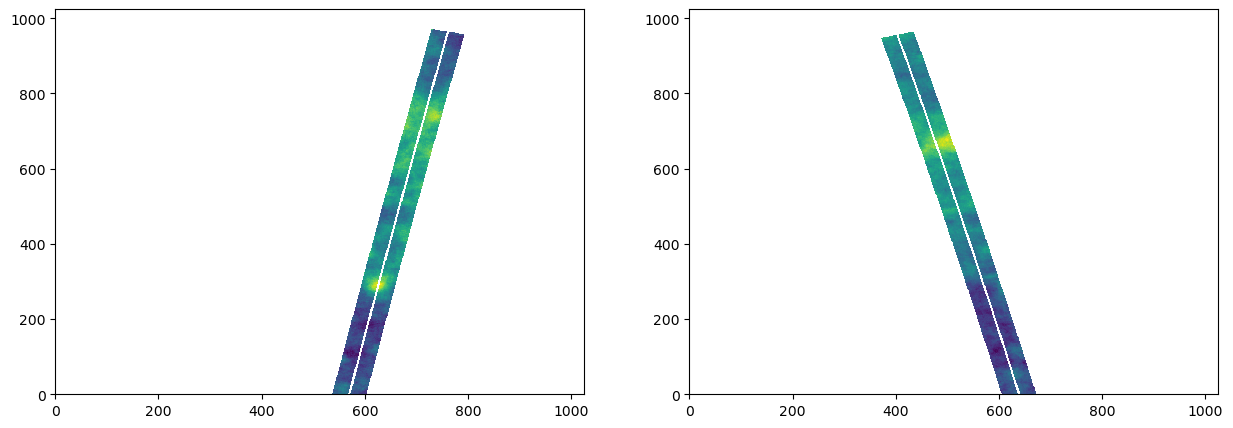

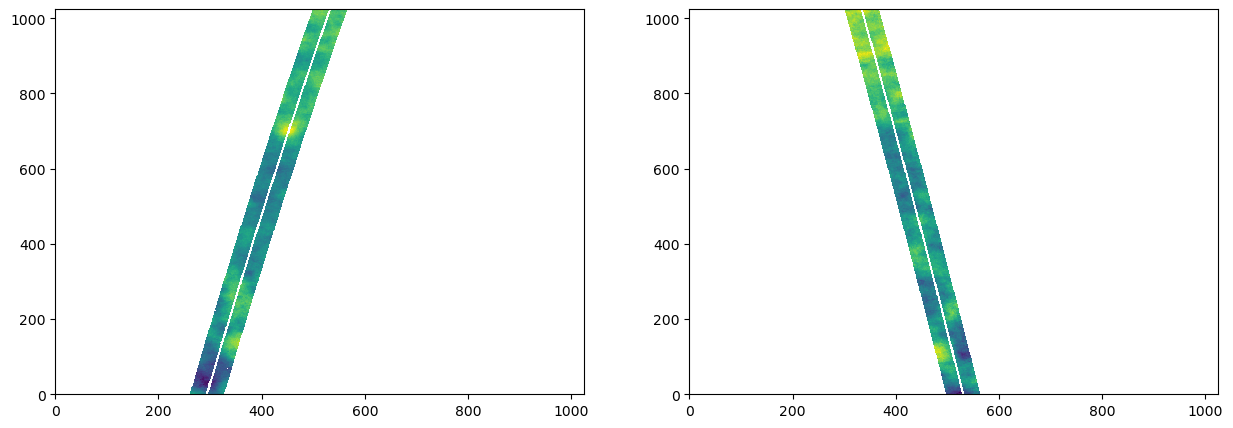

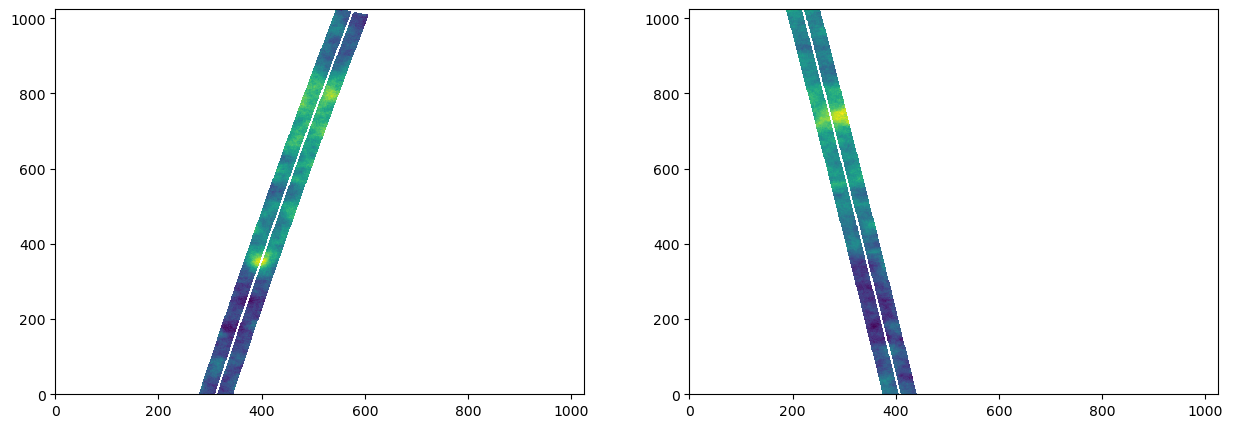

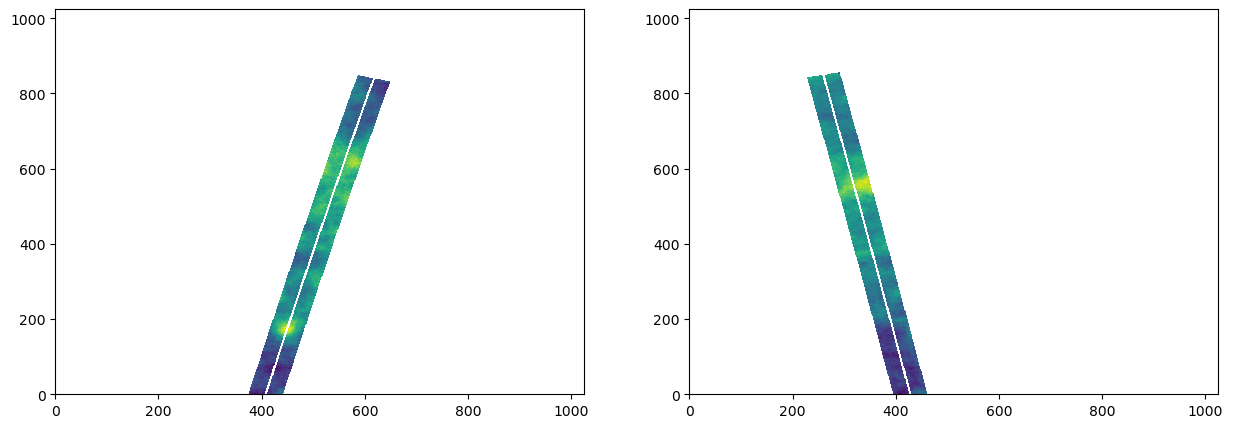

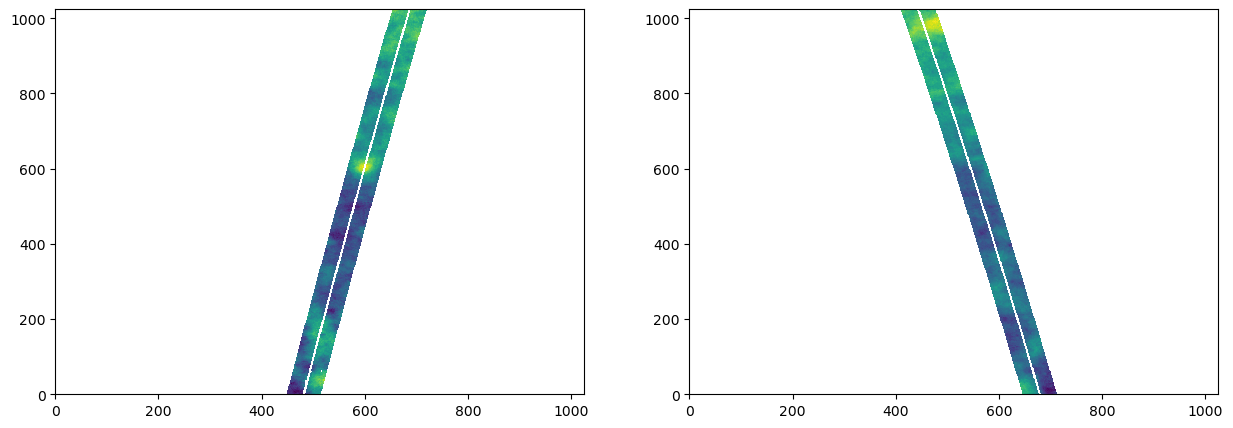

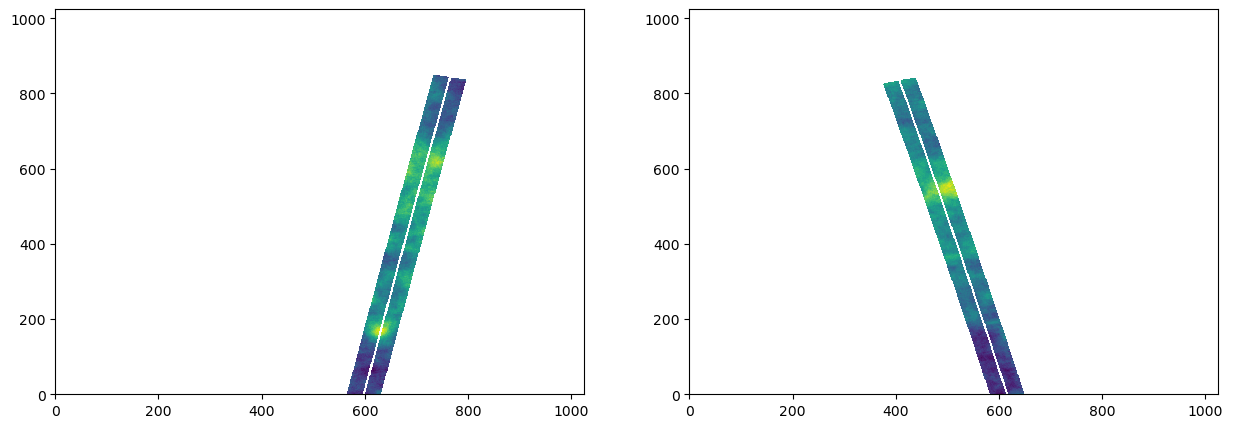

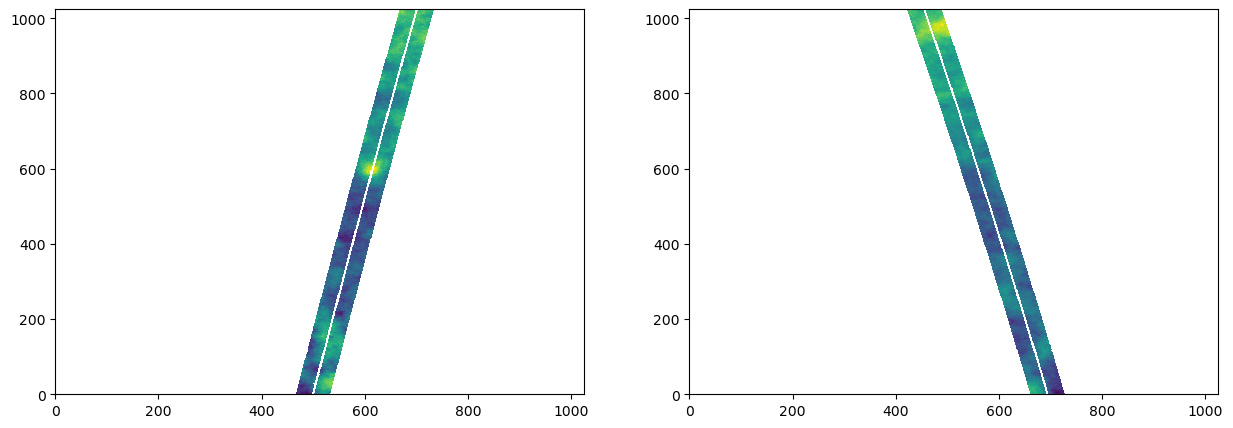

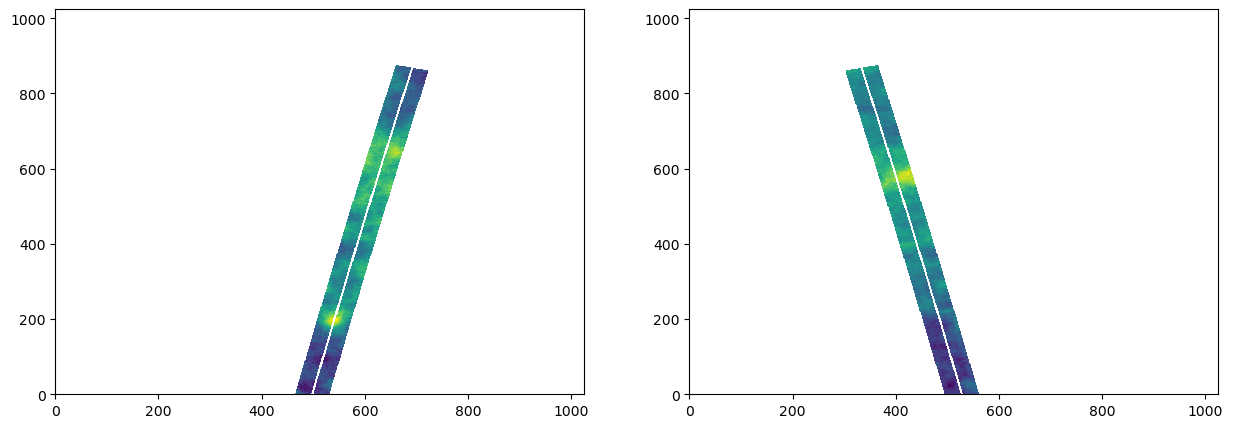

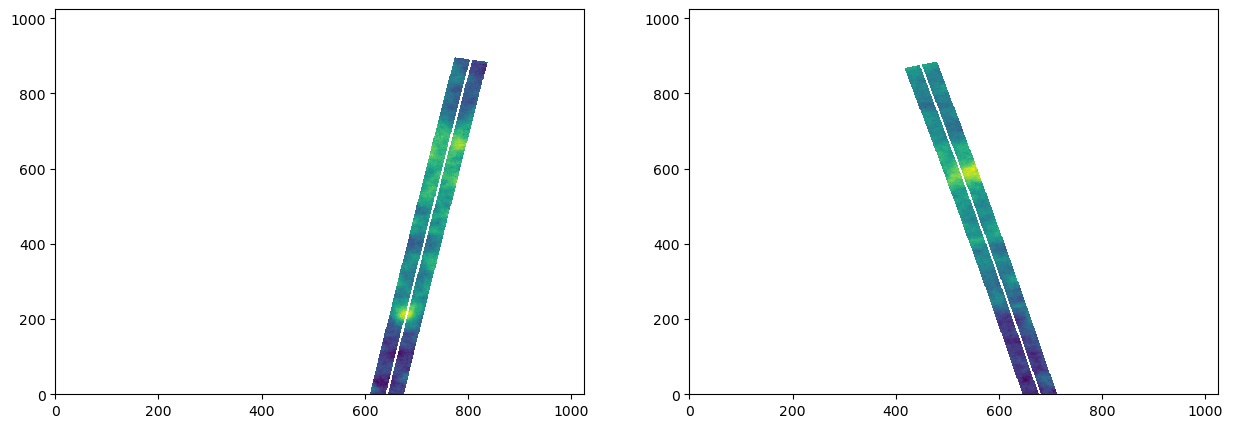

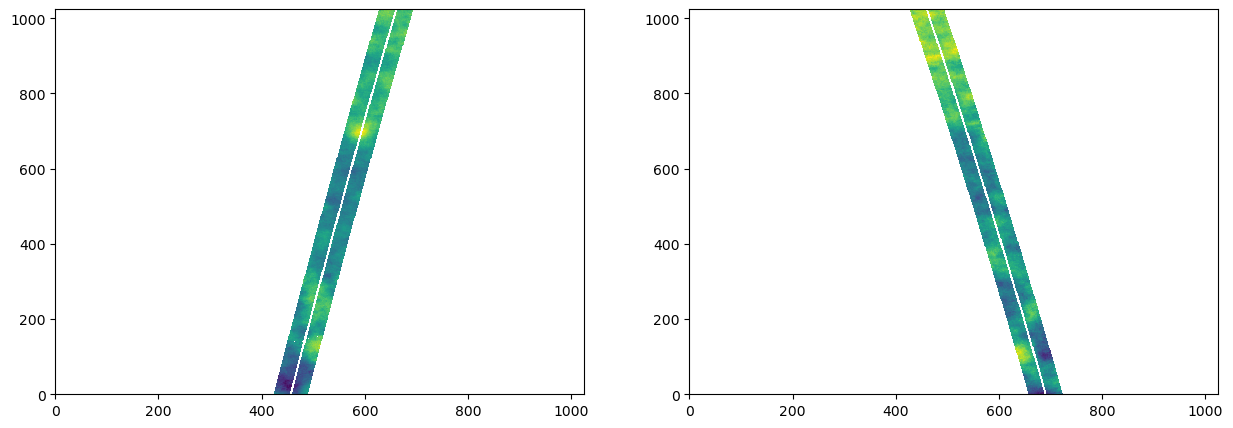

In [93]:
for random_swath in random_swaths:
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].pcolor(random_swath.isel(swath=0))
    axs[1].pcolor(random_swath.isel(swath=1))
    plt.show()

In [78]:
import numpy as np

def human_readable_bytes(nbytes):
    """
    Converts a given number of bytes into a human-readable string with appropriate units.

    Args:
        nbytes (int): The number of bytes.

    Returns:
        str: A string representing the size in a human-readable format.
    """
    units = ['Bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB']
    i = 0
    while nbytes >= 1024 and i < len(units) - 1:
        nbytes /= 1024.0
        i += 1
    return f"{nbytes:.2f} {units[i]}"

In [82]:
random_masks[0,:2].shape

(2, 1024, 1024)

In [81]:
human_readable_bytes(random_masks[0,:2].nbytes)

'2.00 MB'

In [ ]:
plt.pcolor(random_masks[:,:2])
plt.colorbar()

In [ ]:
np.

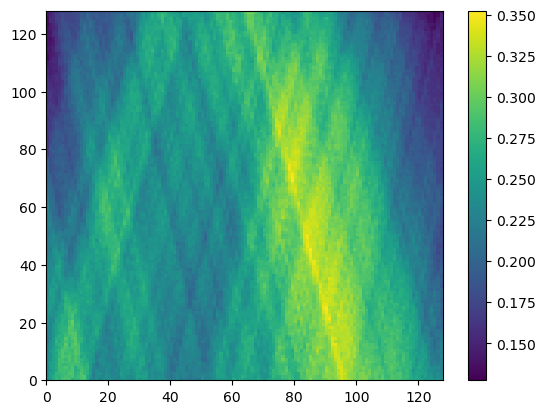

In [118]:
plt.pcolor(np.sum(random_masks[:,:2],axis=(0,1))/400)
plt.colorbar()

In [119]:
random_masks.shape

(300, 6, 128, 128)

In [120]:
np.sum(random_masks[:,:2],axis=(1,2,3))

array([4021, 5050, 7418, 3377, 3841, 6059, 5634, 7060, 4114, 2449, 3741,
       7427, 3765, 4817, 2976, 7427, 6705, 7421, 3999, 7335, 6188, 7405,
       3835, 5726, 3614, 5045, 3746, 7355, 7417, 6770, 3512, 4793, 2622,
       5384, 7364, 7408, 3728, 3266, 6846, 3607, 6875, 4148, 7055, 5797,
       1822, 3746, 5825, 5638, 6651, 7424, 4104, 7275, 5294, 2108, 6226,
       3786, 6668, 3899, 4991, 3738, 6848, 4169, 3729, 7409, 4664, 4980,
       7213, 3171, 6450, 5151, 4305, 4523, 7386, 6316, 3511, 6929, 4181,
       6981, 3733, 5204, 7422, 3810, 4233, 6701, 3375, 4327, 5721, 2932,
       3725, 3724, 7370, 3737, 7429, 7430, 3129, 6521, 5590, 3750, 7320,
       7424, 5514, 7402, 7232, 3570, 2571, 3600, 5845, 4598, 3258, 3632,
       7383, 6696, 7322, 3952, 5300, 7409, 3737, 6352, 7427, 4949, 7396,
       7279, 6240, 7399, 3364, 6839, 7363, 6375, 6612, 7423, 6177, 7407,
       6583, 5532, 7141, 3926, 6585, 7372, 3989, 7392, 7376, 6403, 4498,
       7010, 7184, 5777, 6448, 7041, 2420, 3972, 32

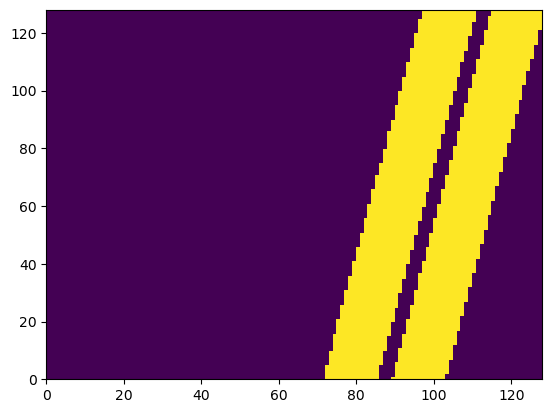

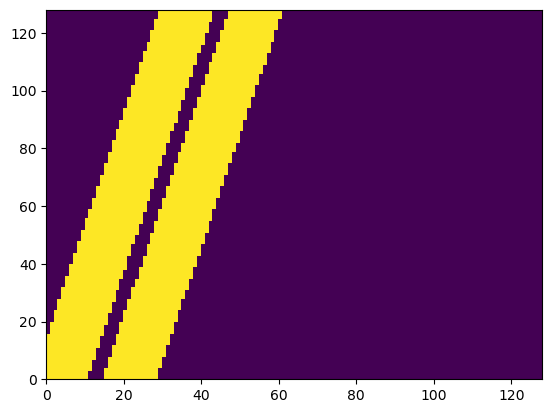

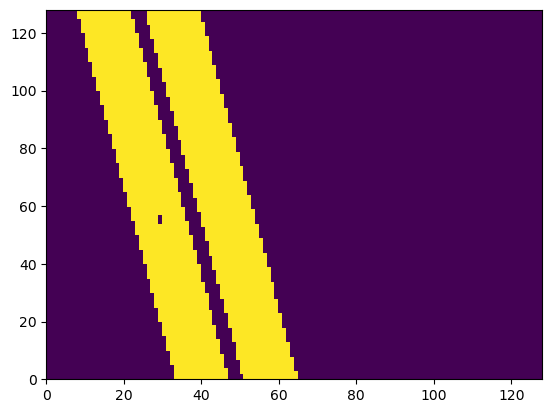

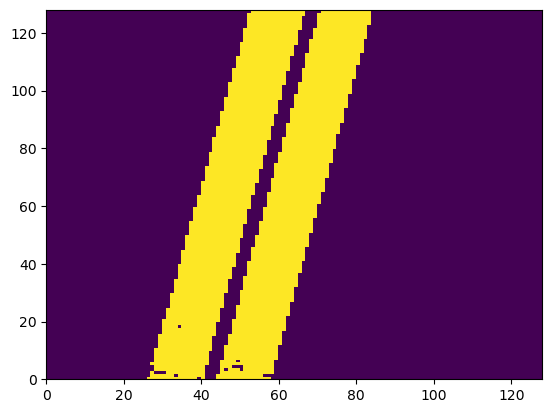

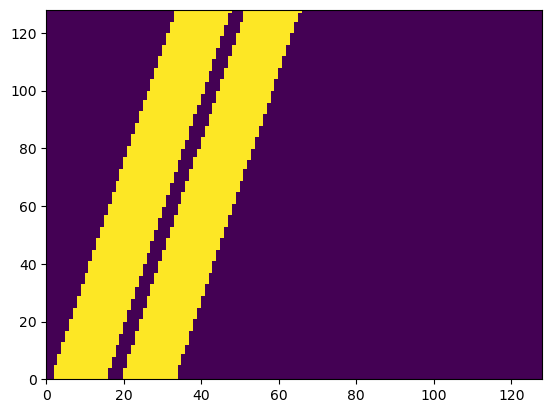

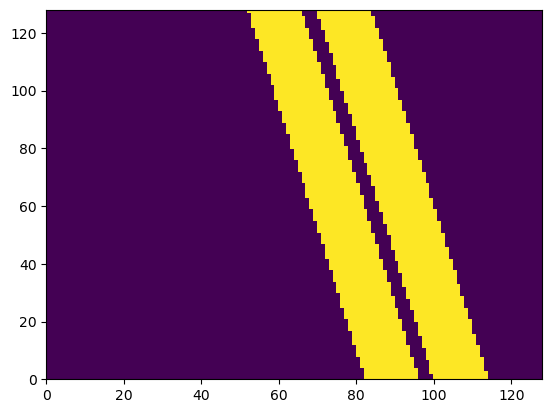

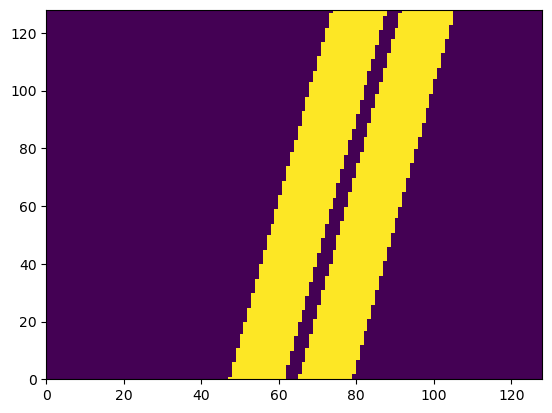

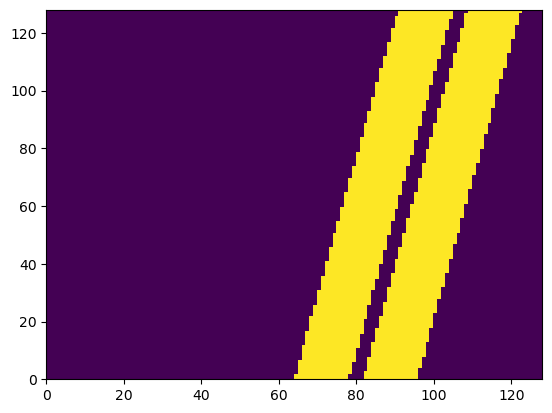

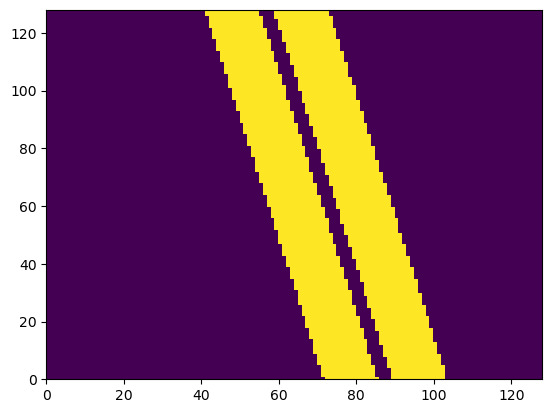

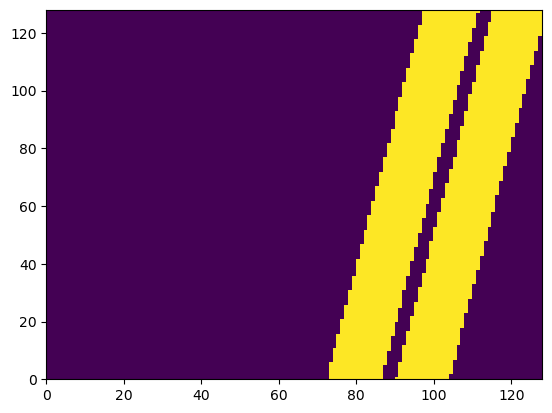

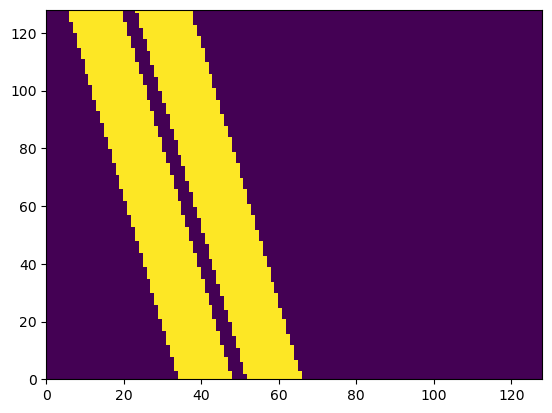

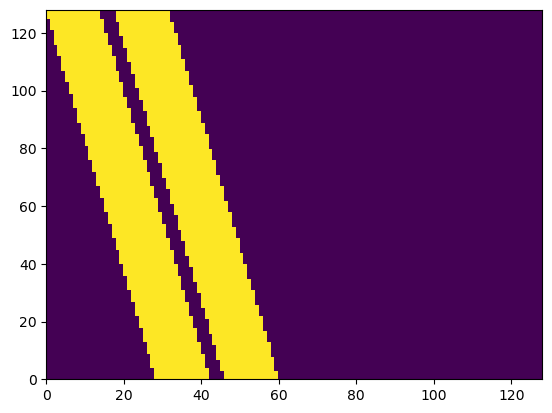

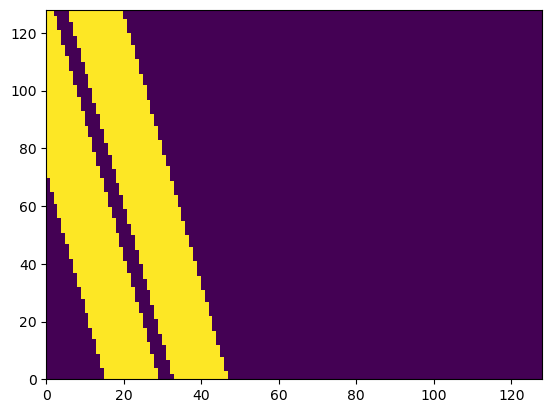

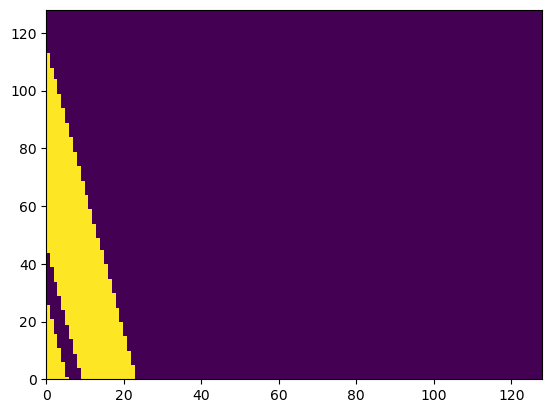

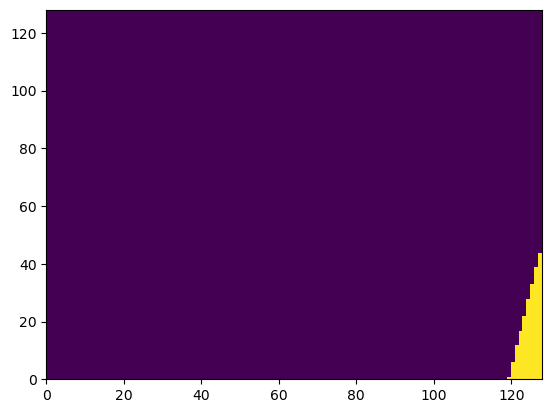

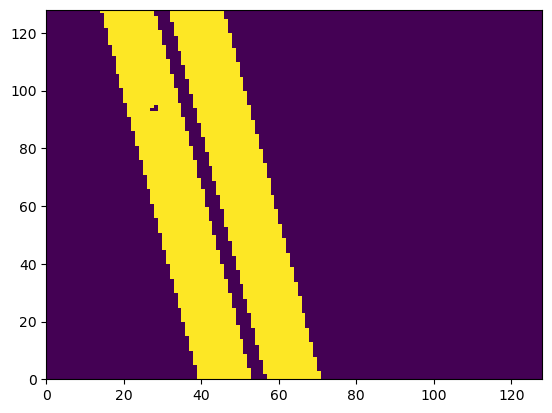

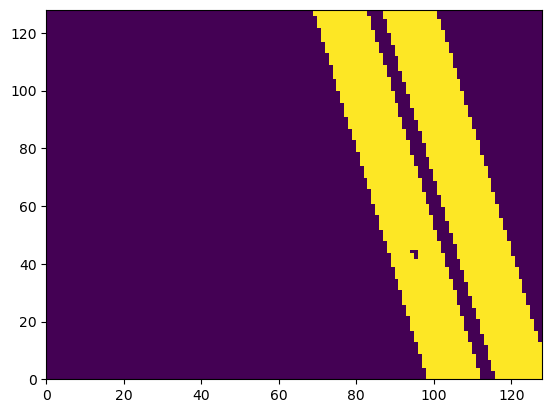

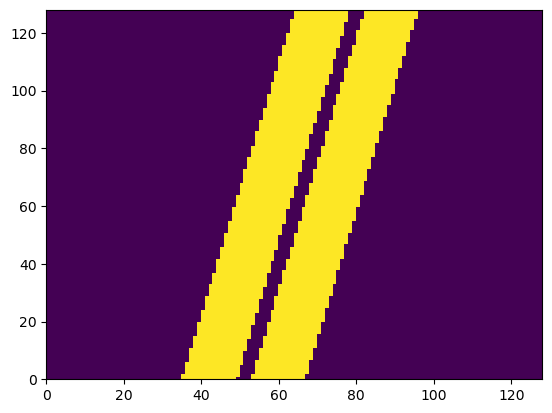

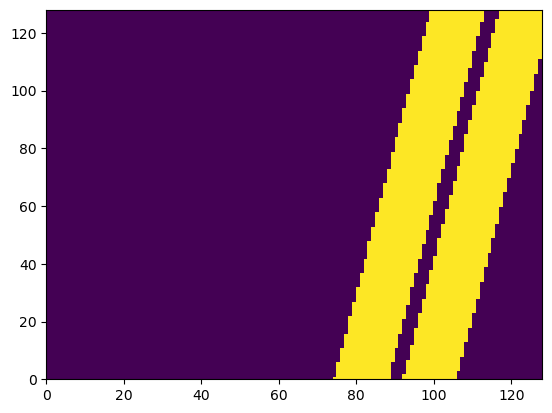

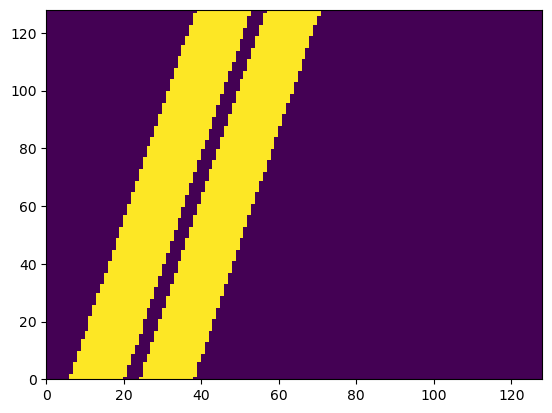

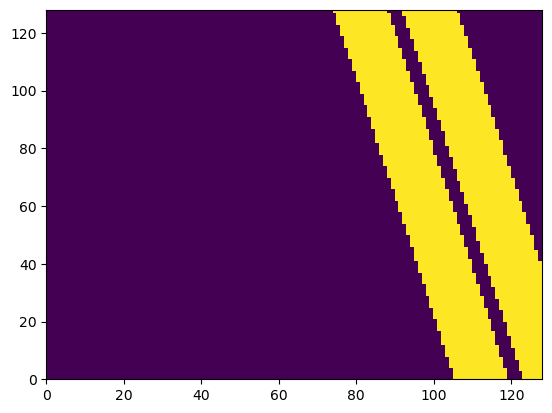

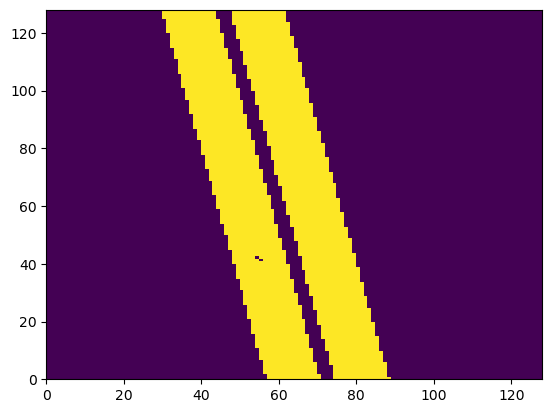

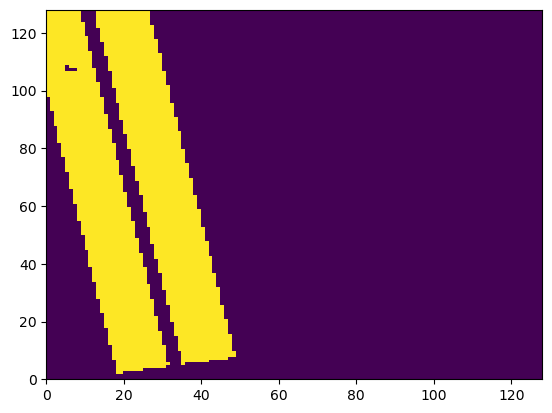

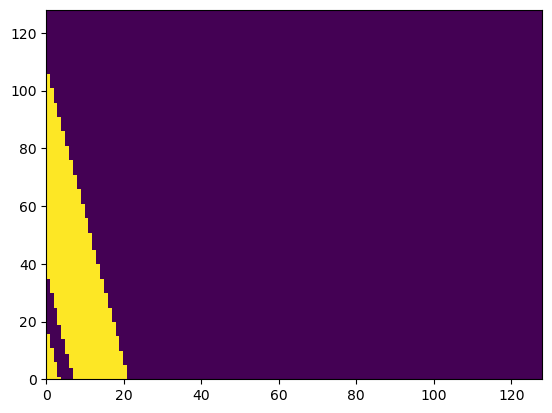

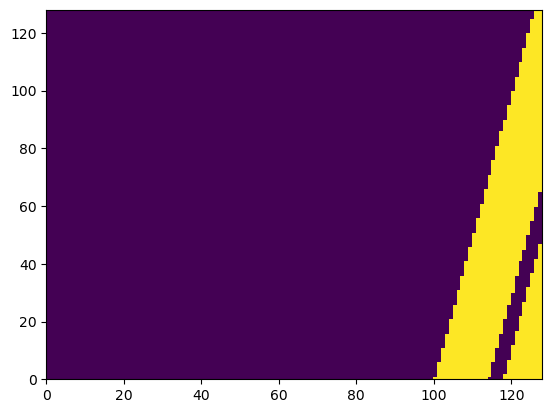

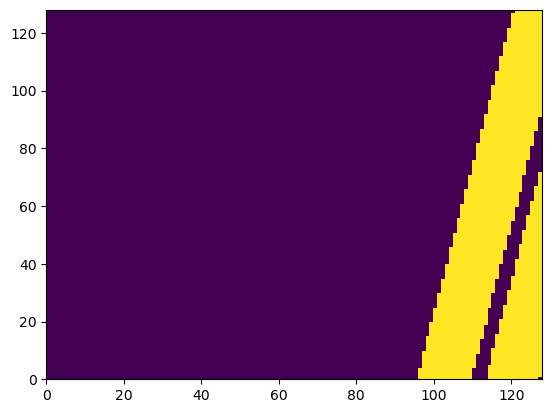

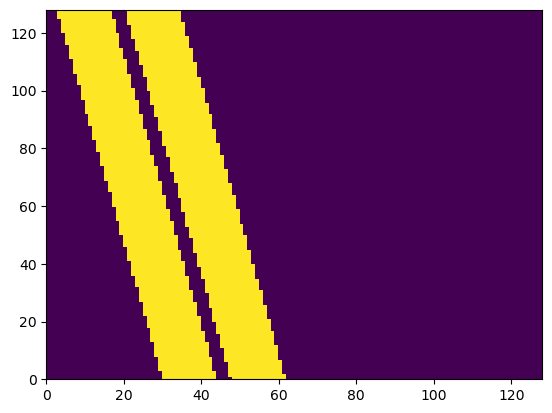

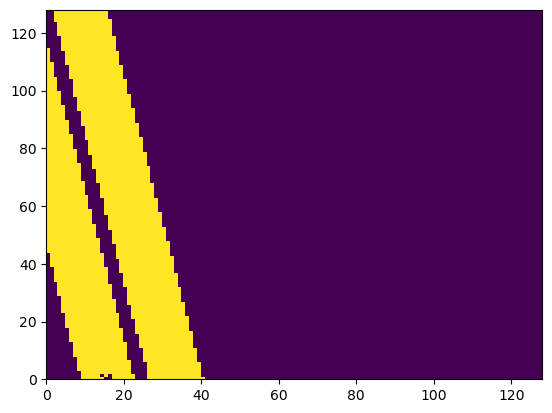

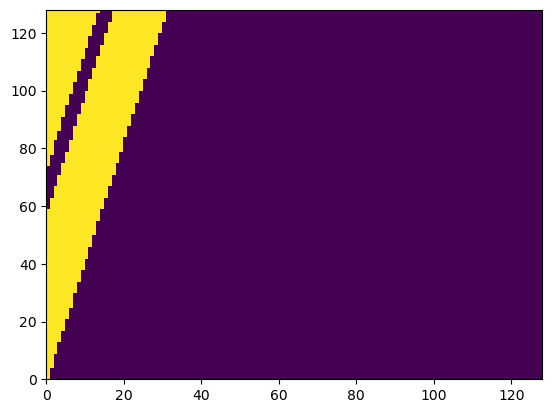

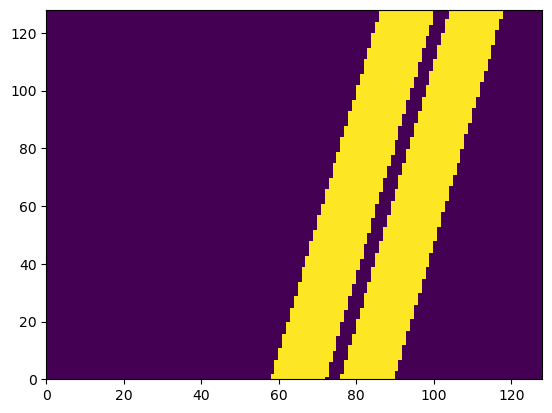

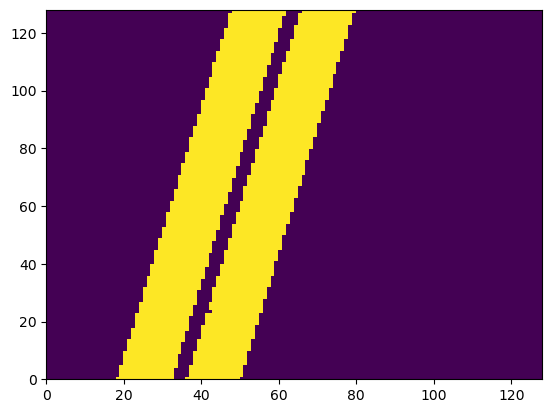

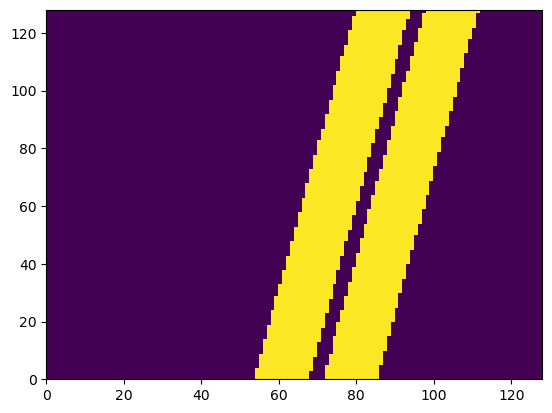

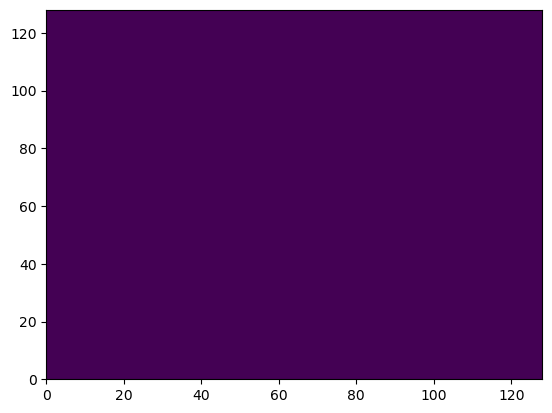

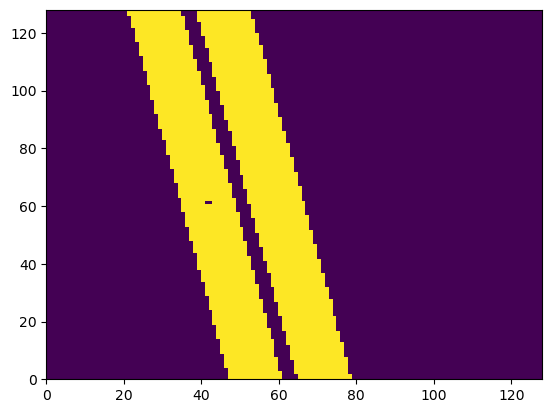

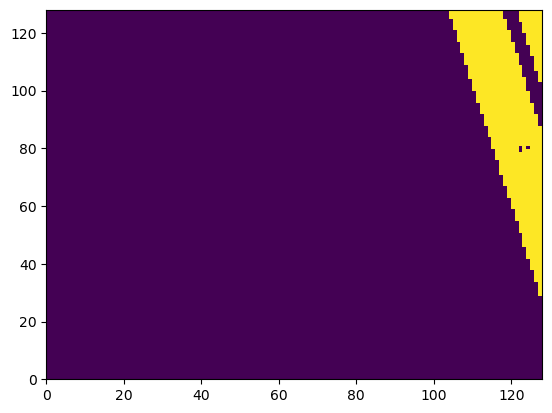

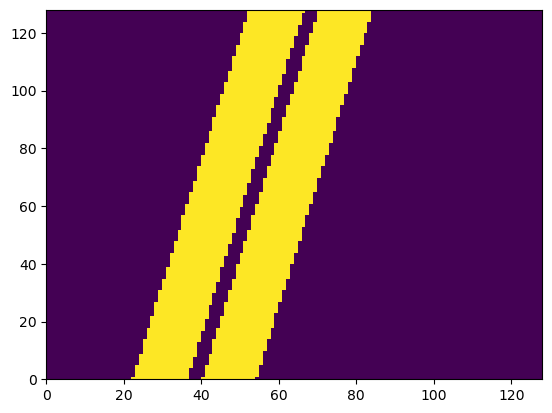

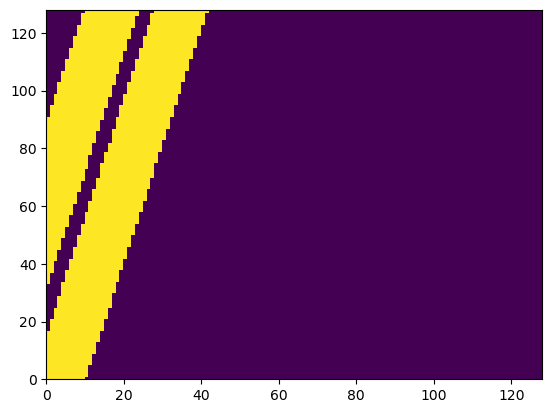

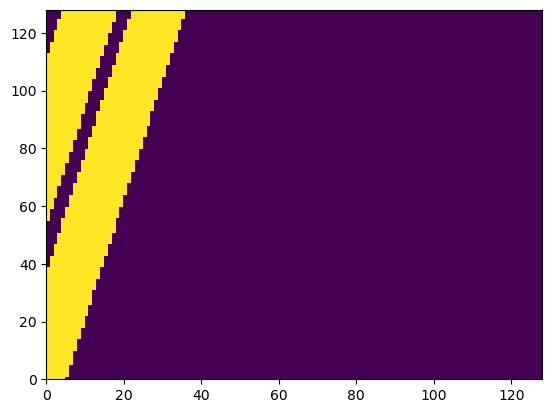

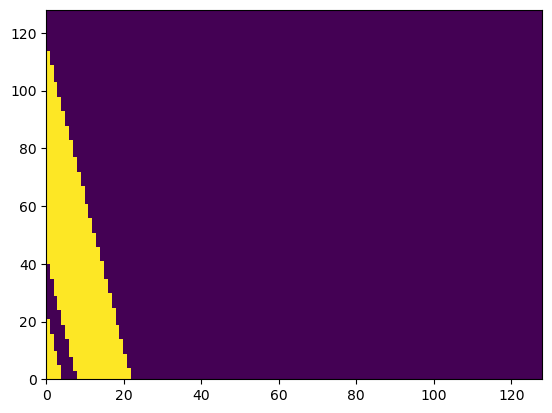

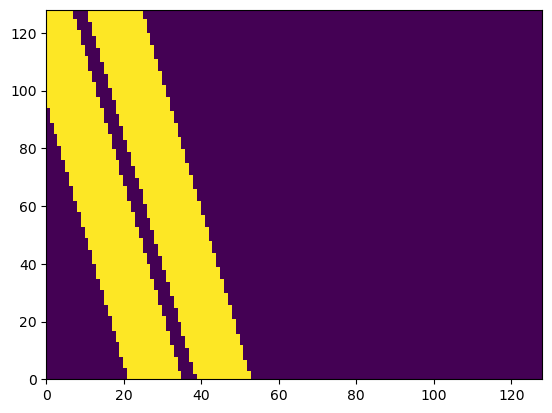

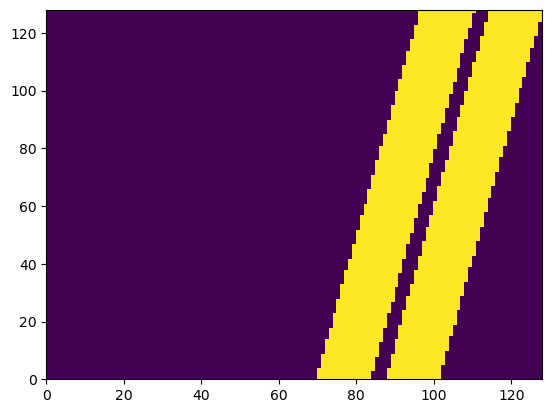

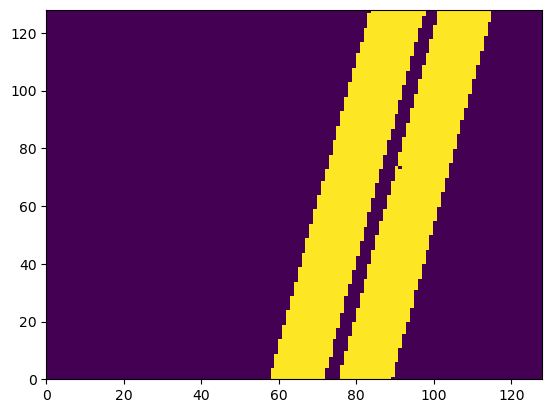

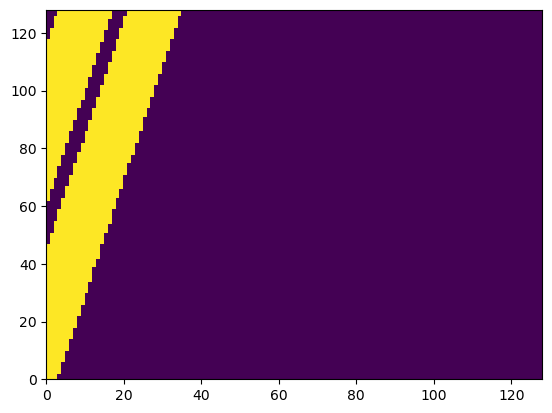

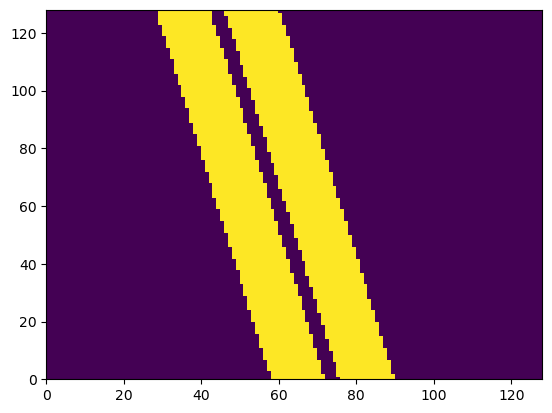

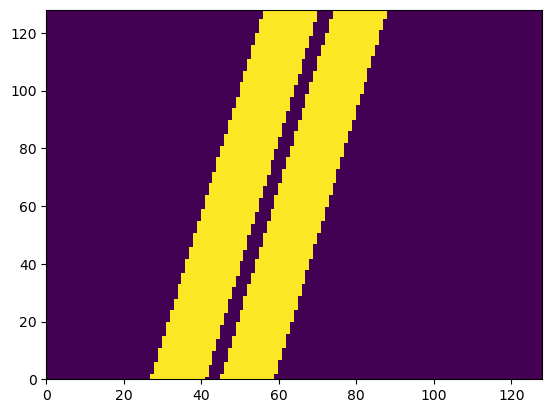

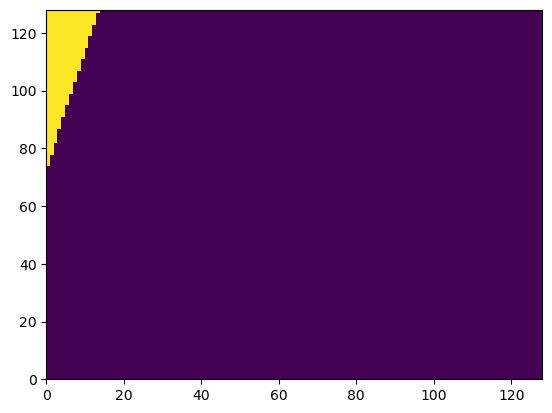

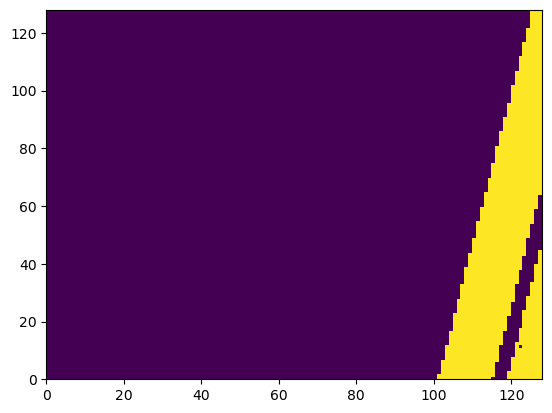

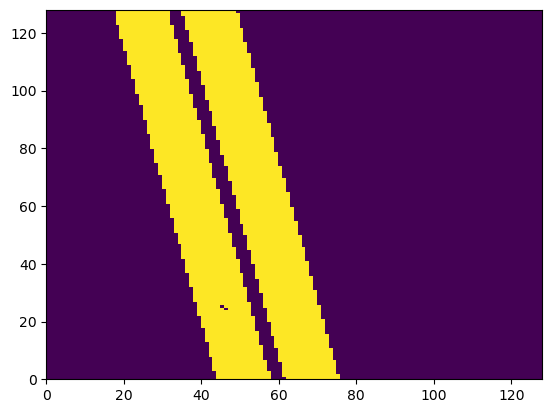

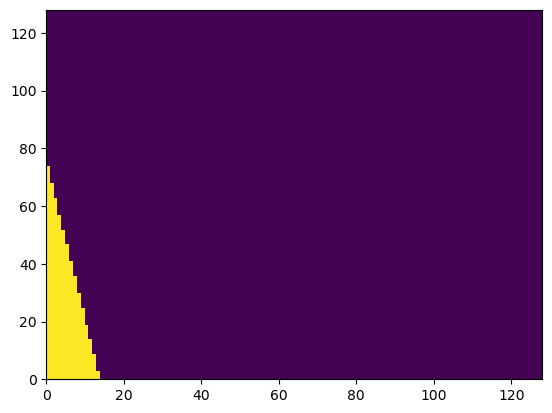

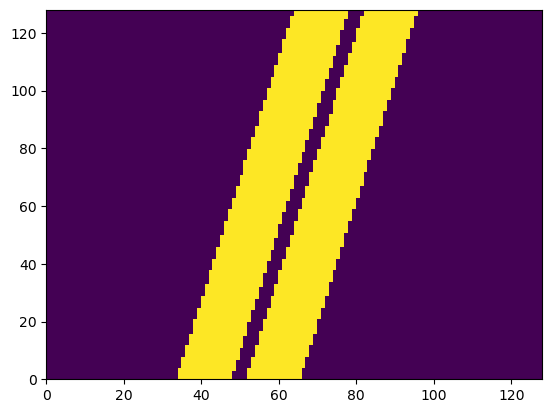

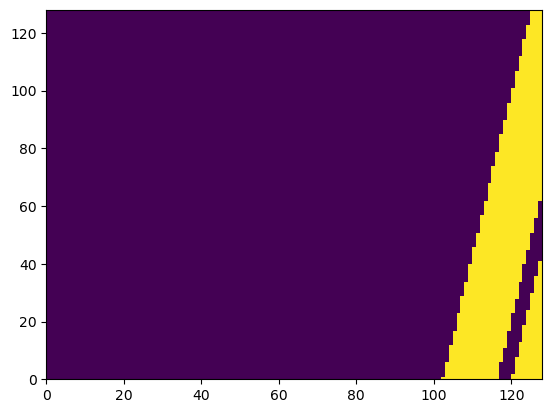

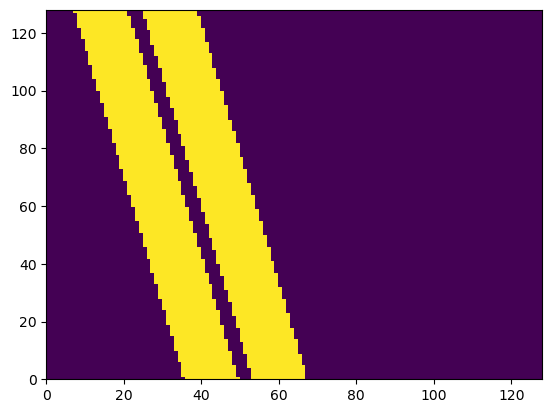

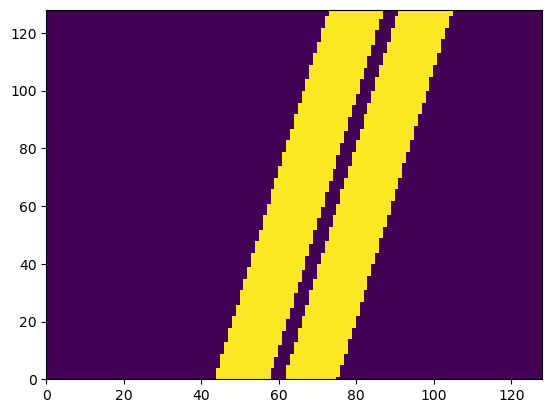

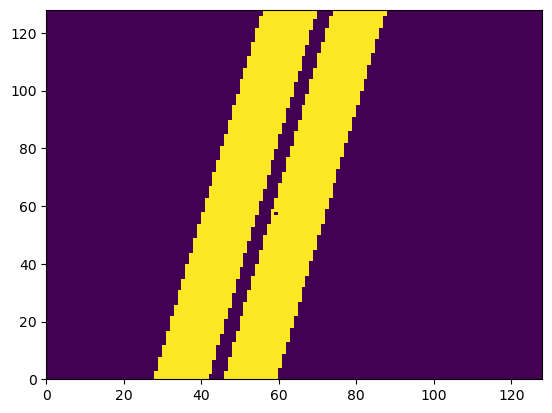

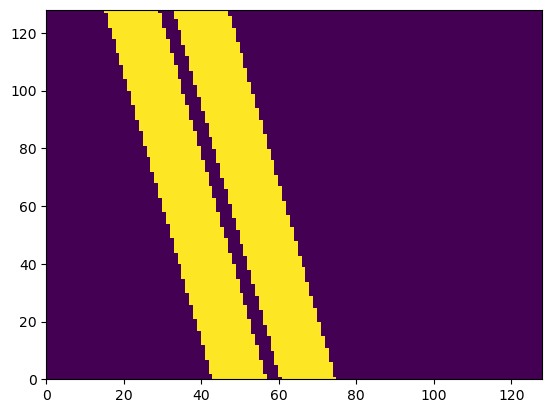

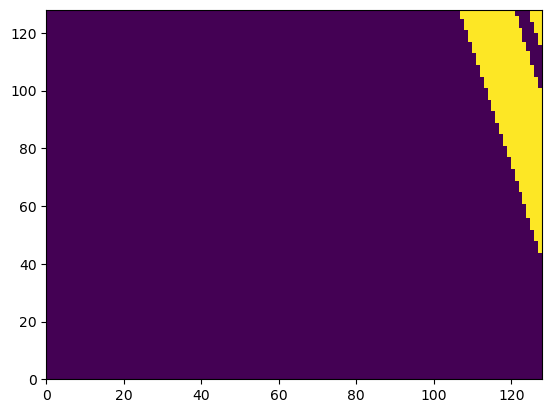

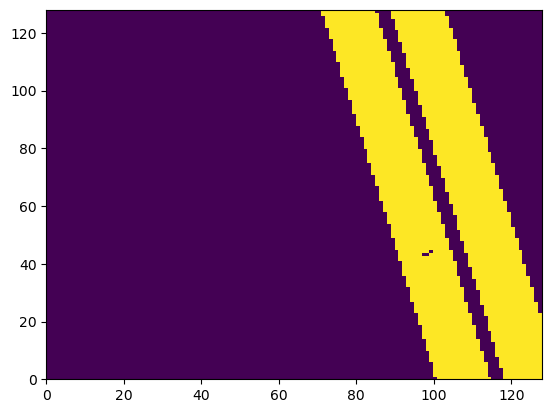

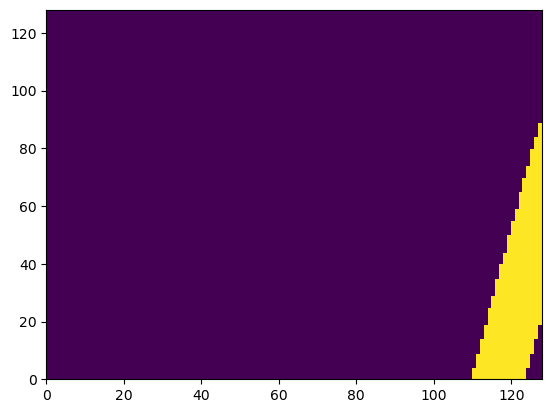

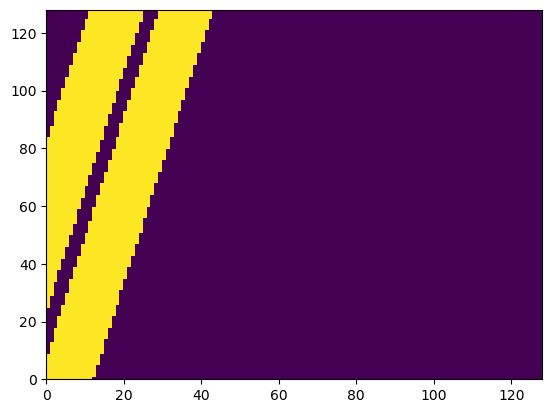

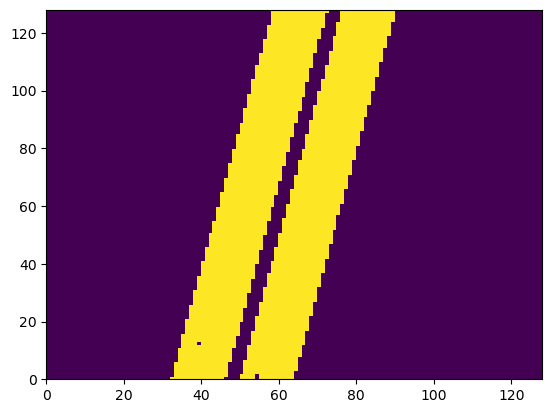

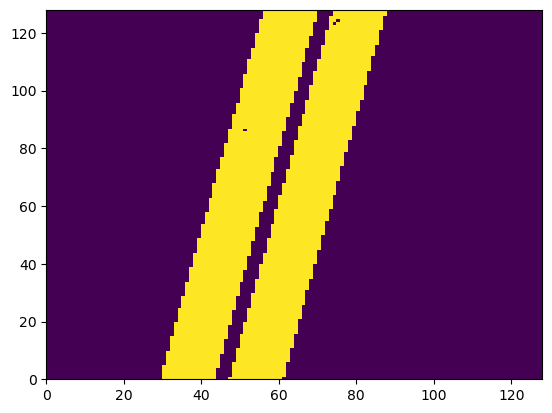

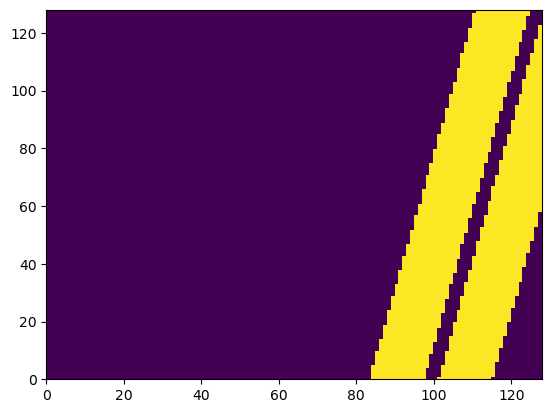

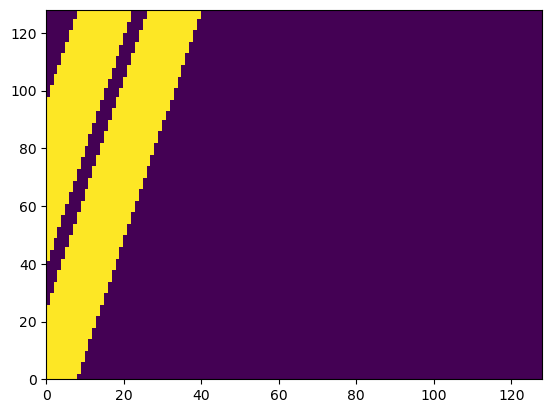

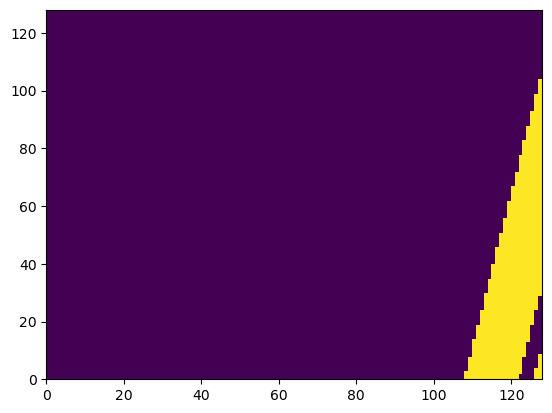

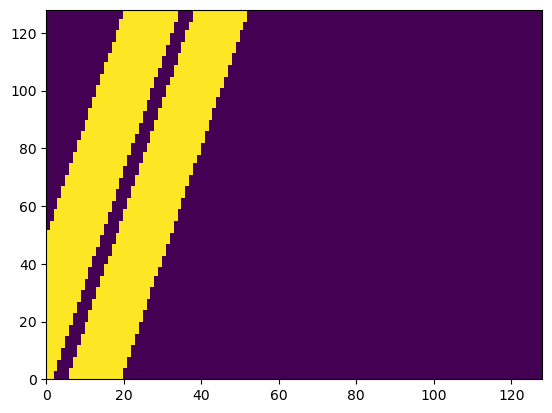

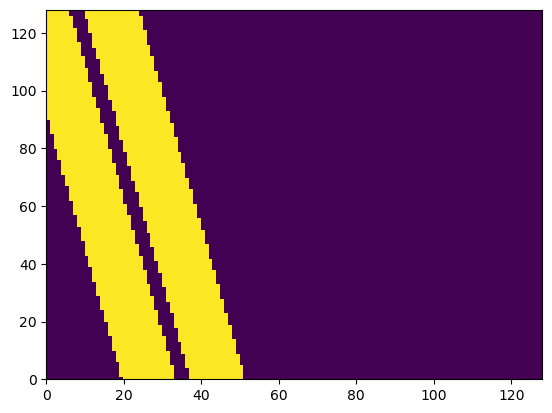

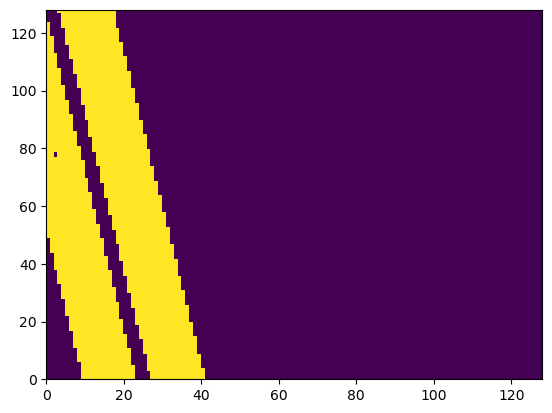

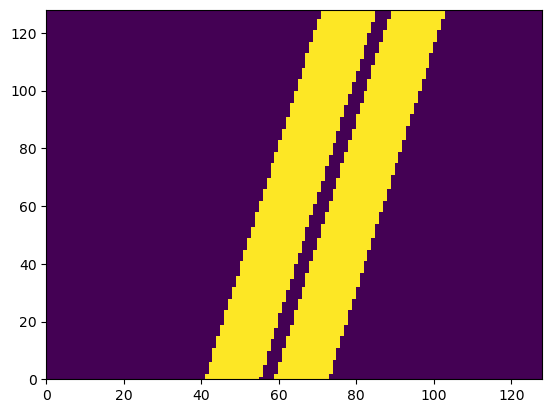

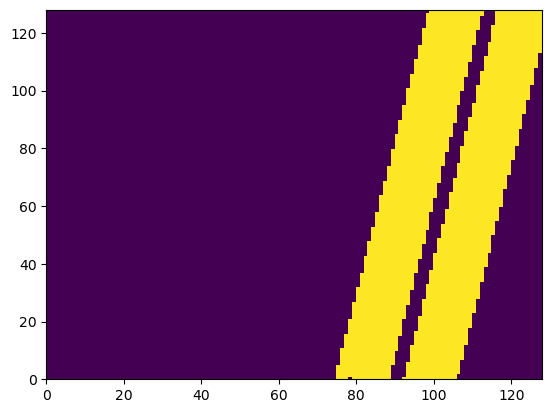

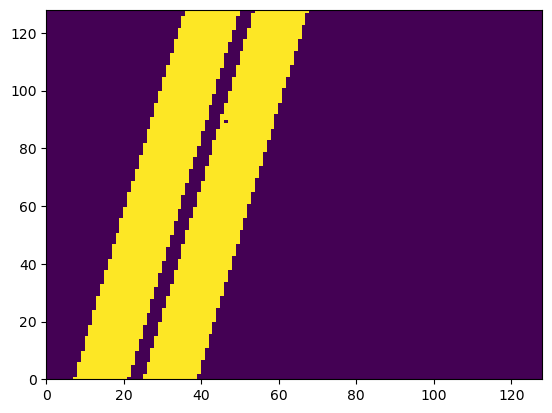

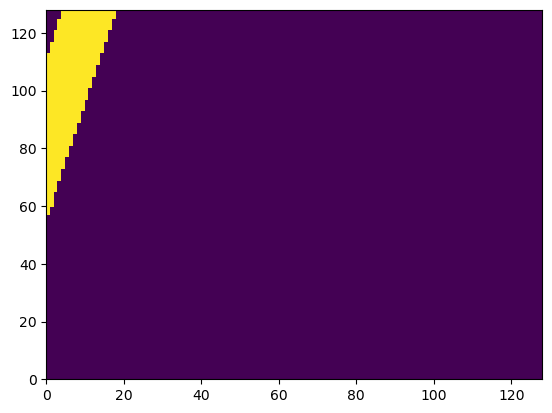

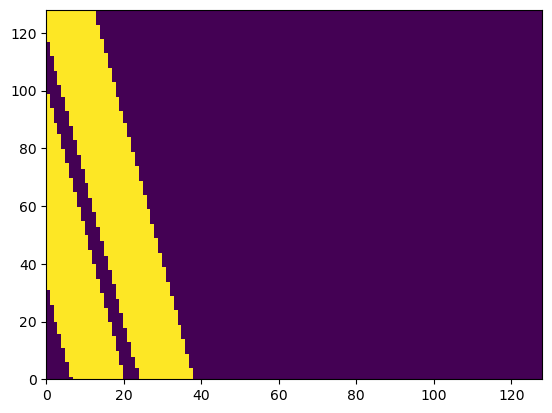

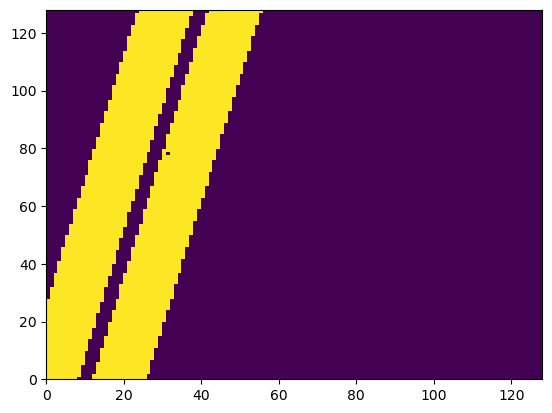

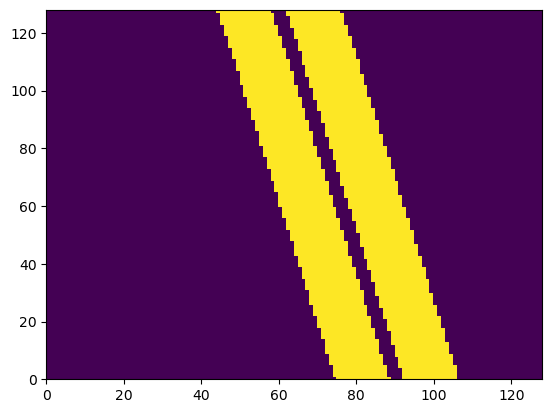

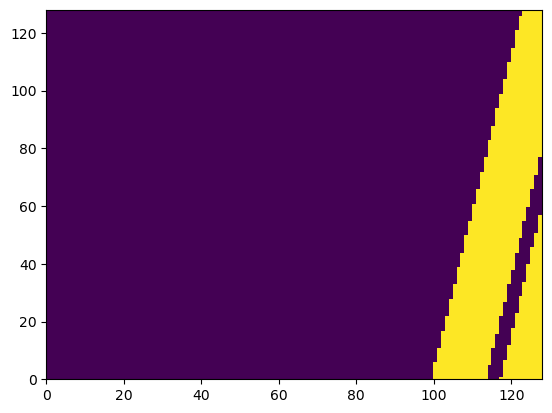

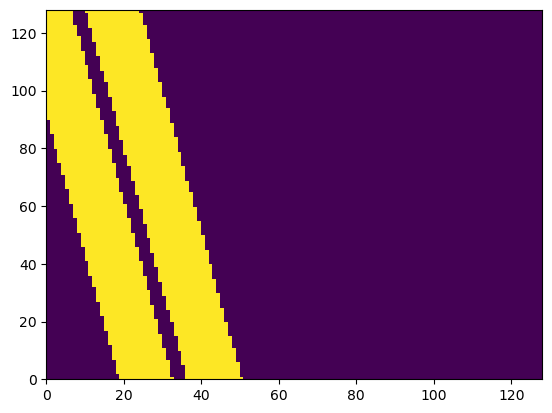

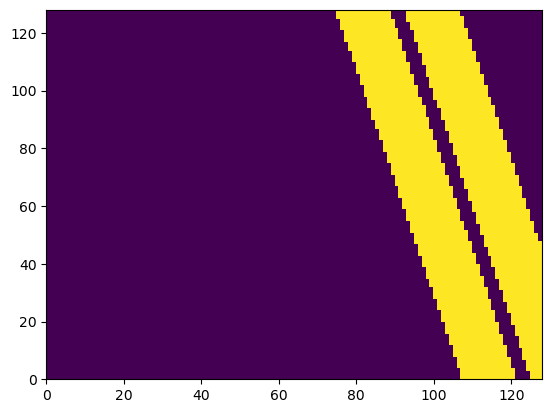

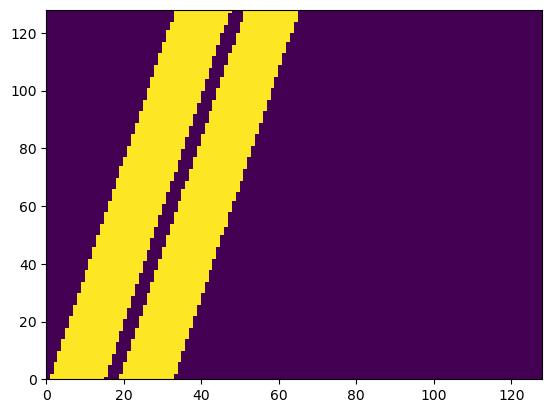

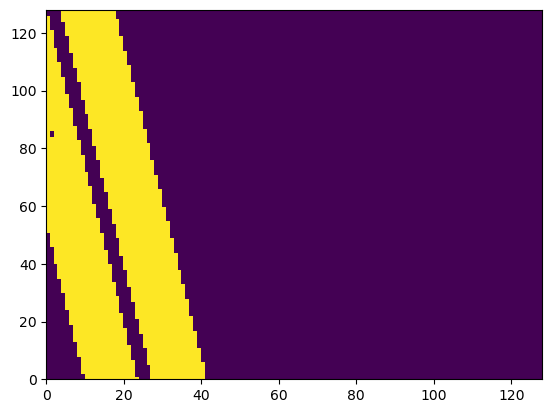

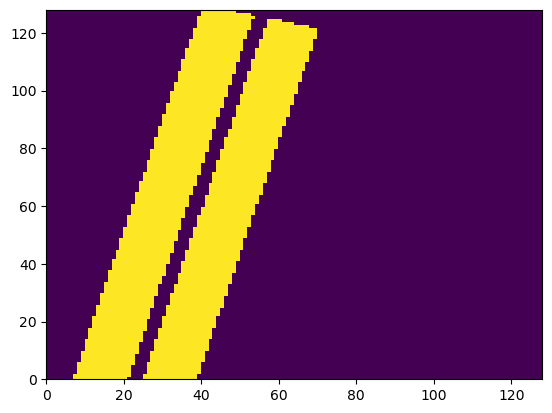

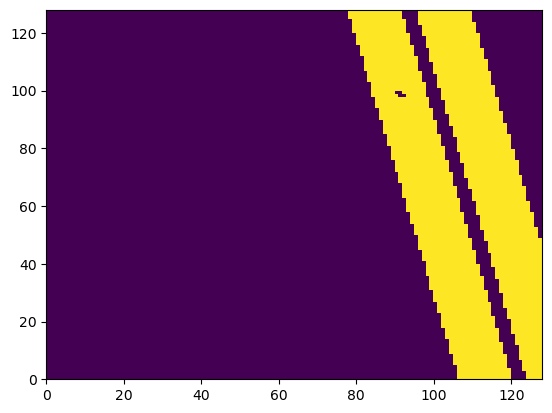

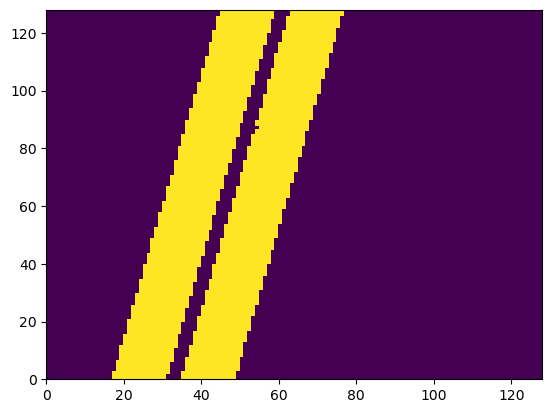

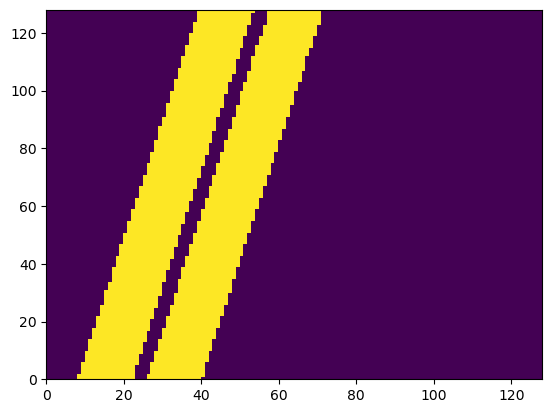

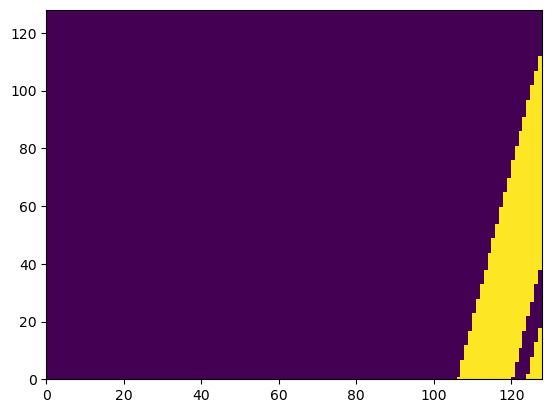

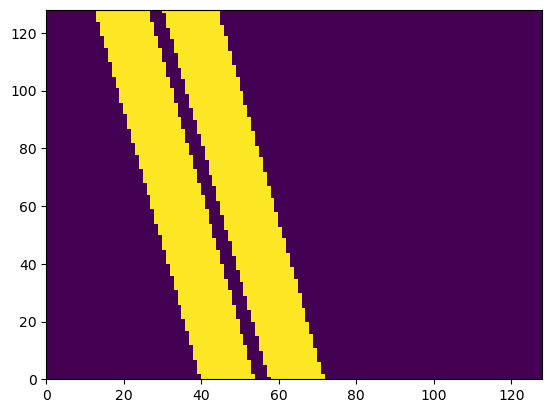

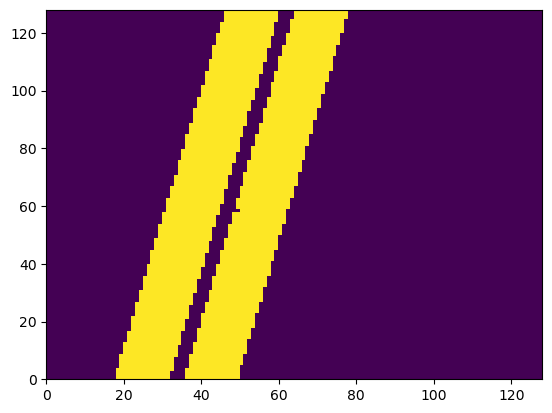

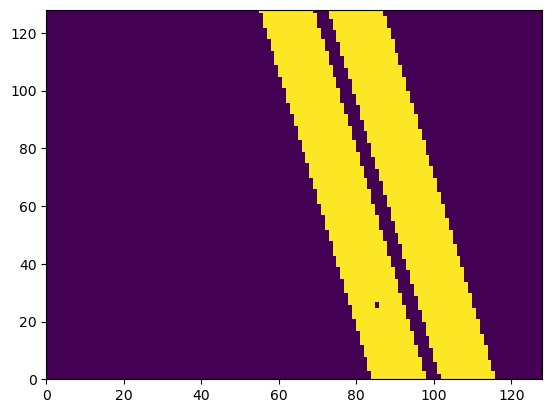

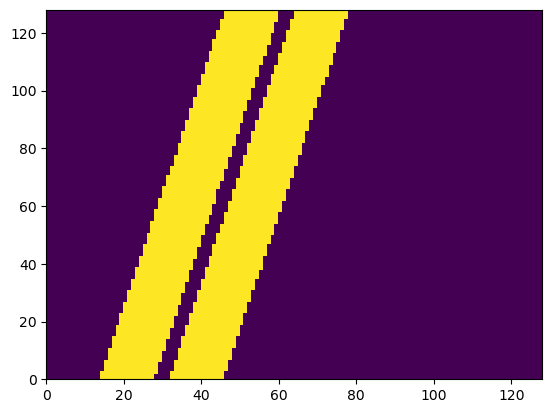

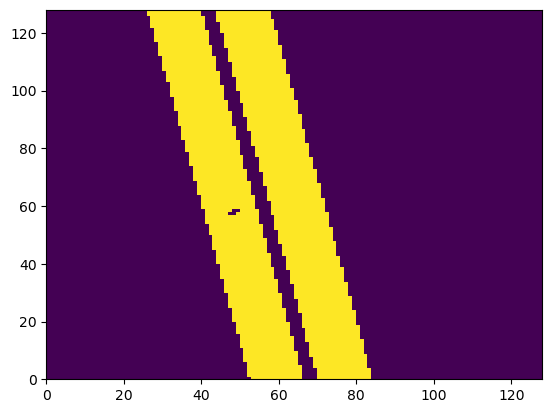

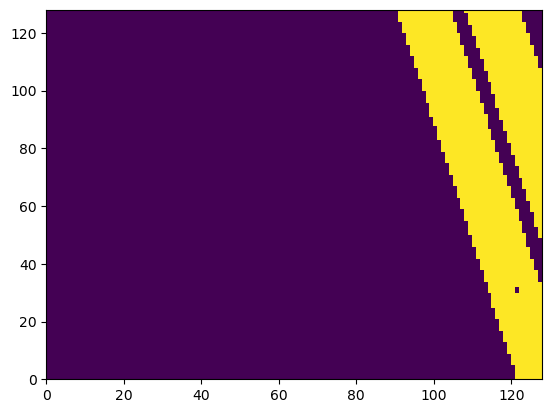

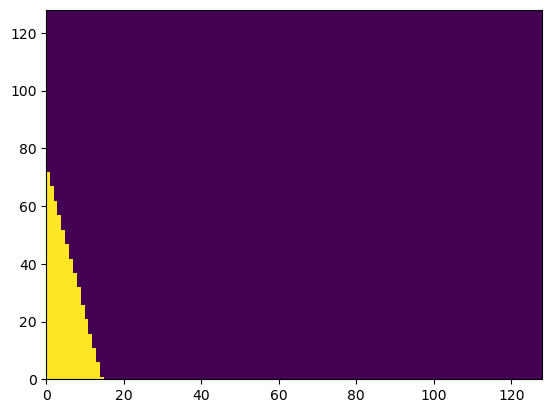

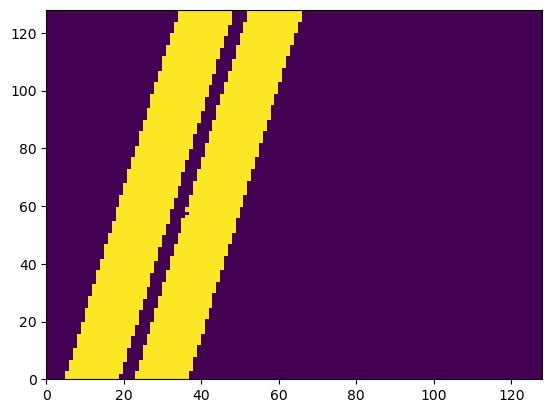

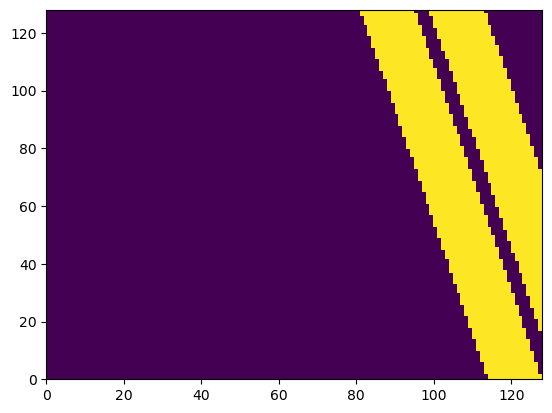

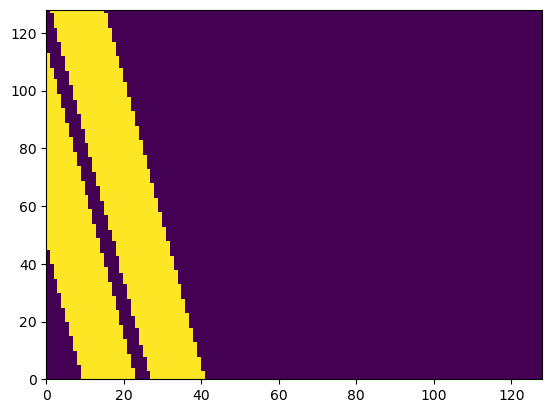

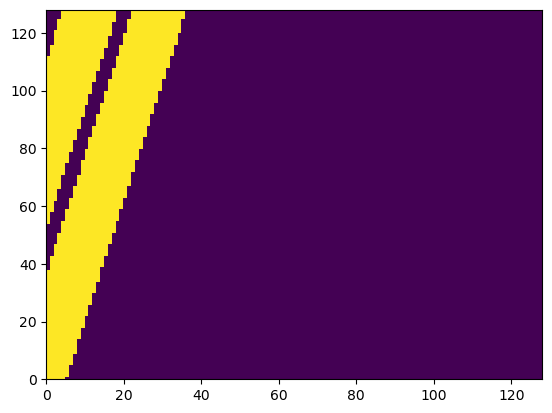

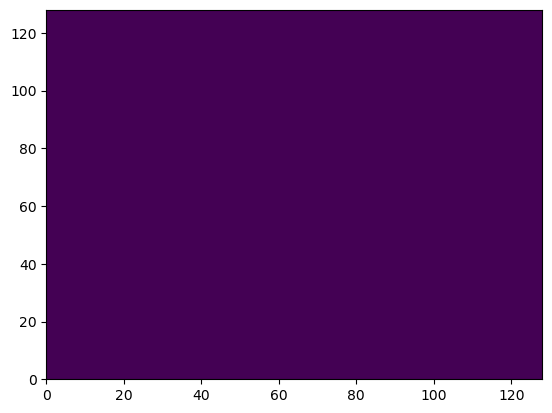

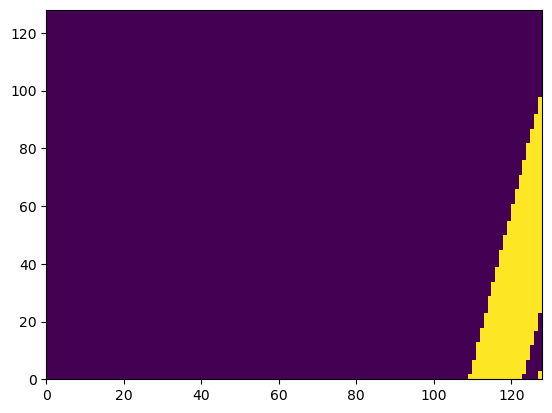

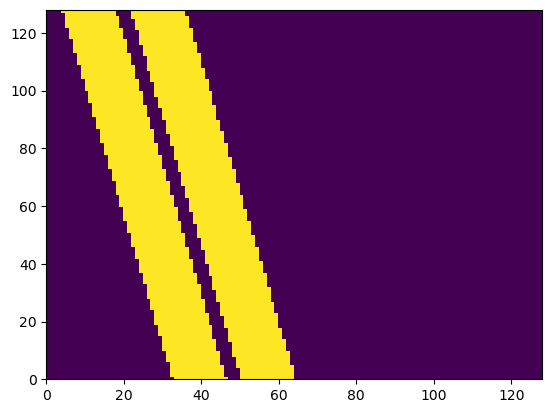

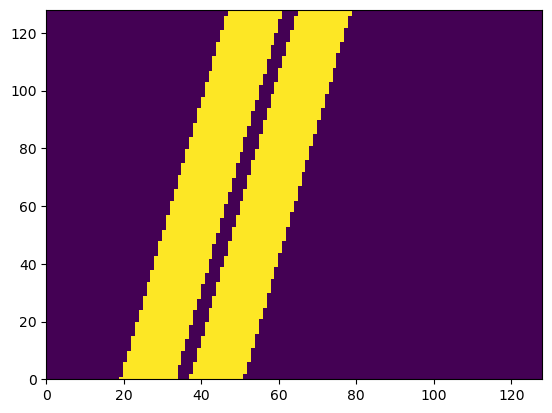

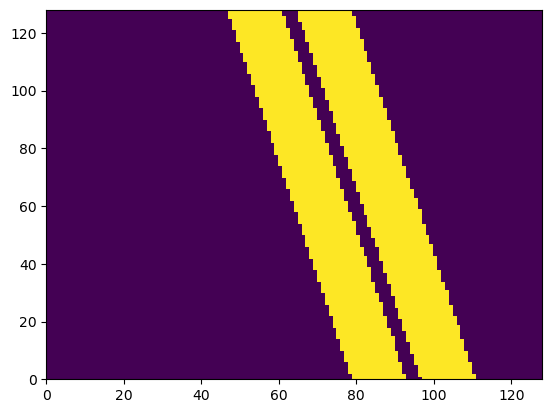

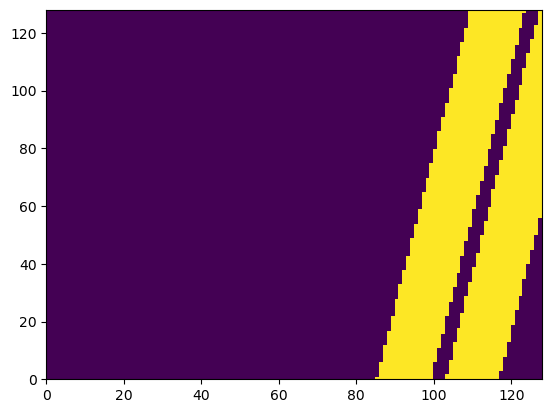

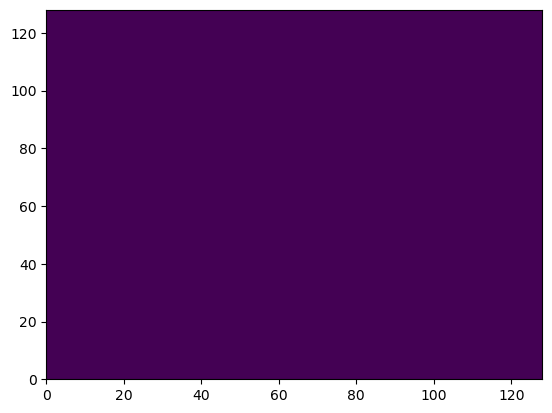

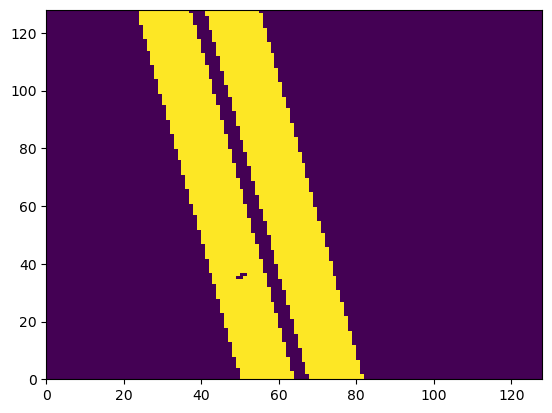

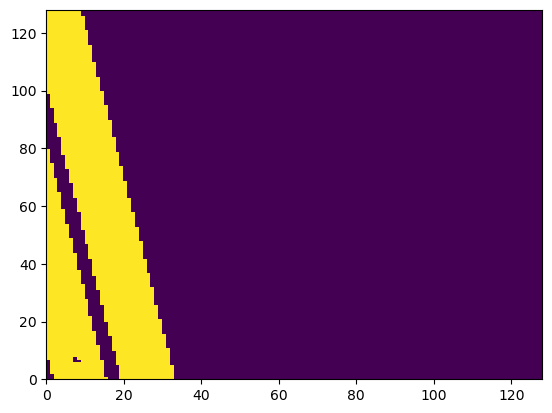

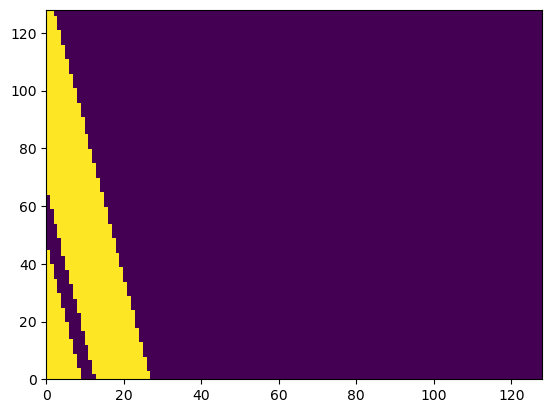

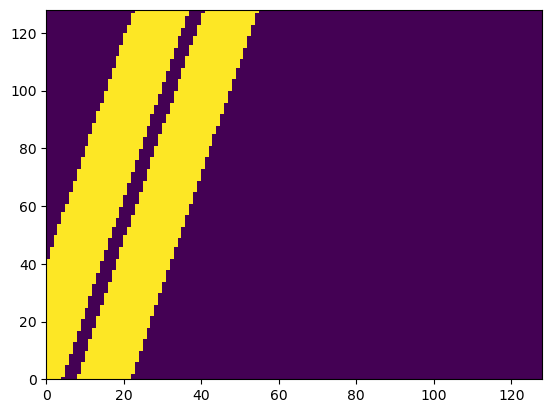

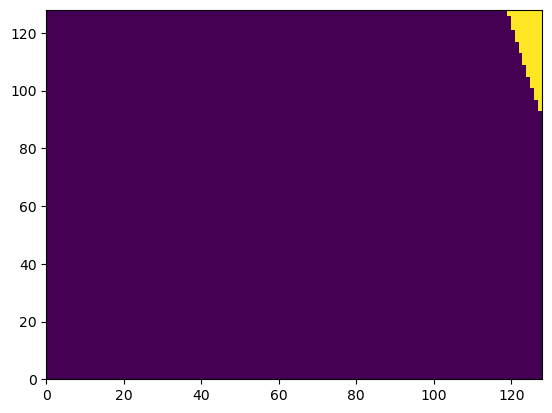

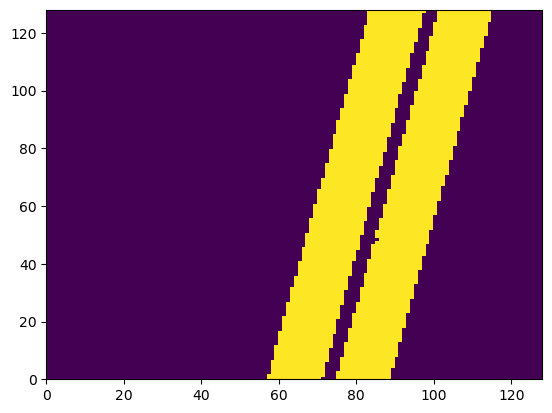

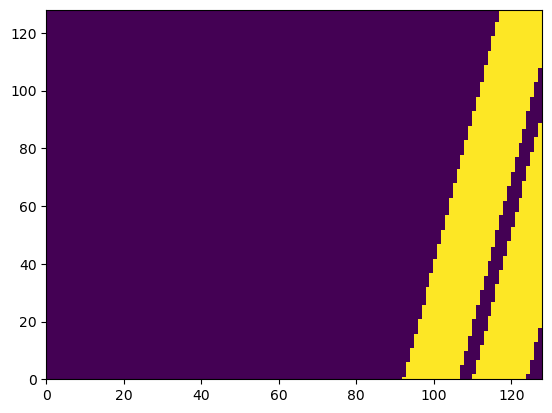

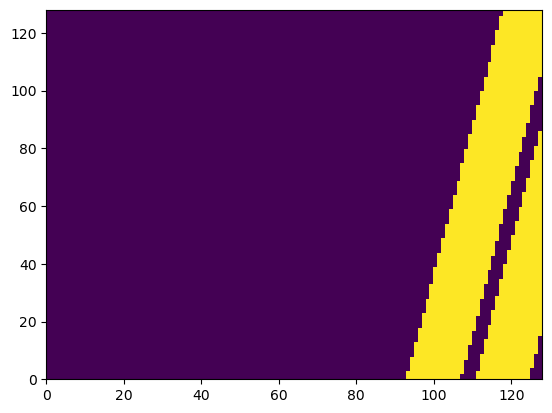

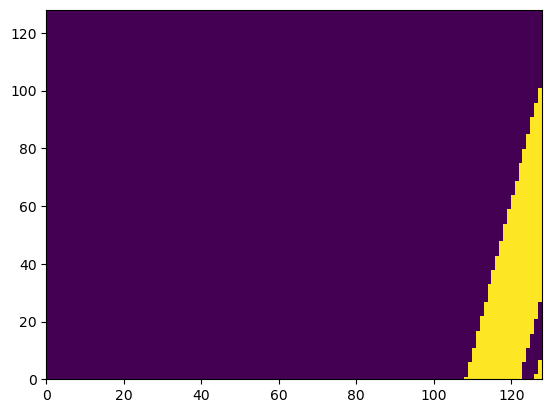

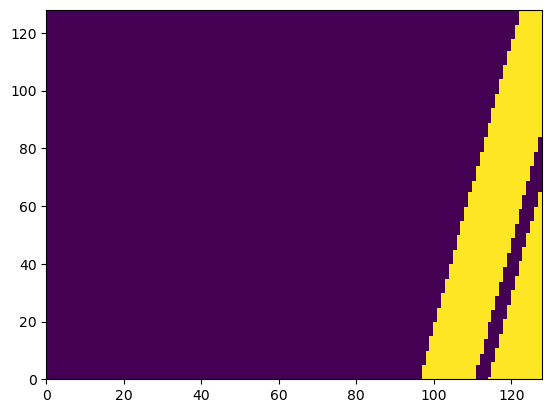

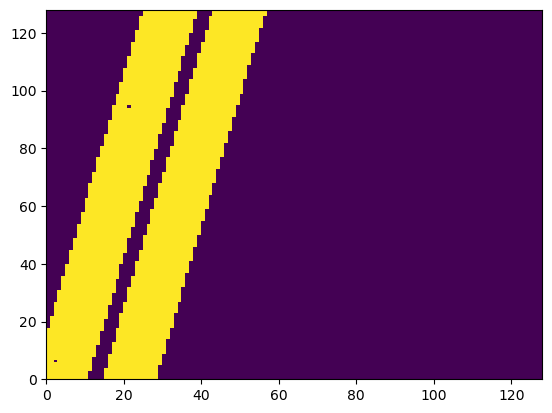

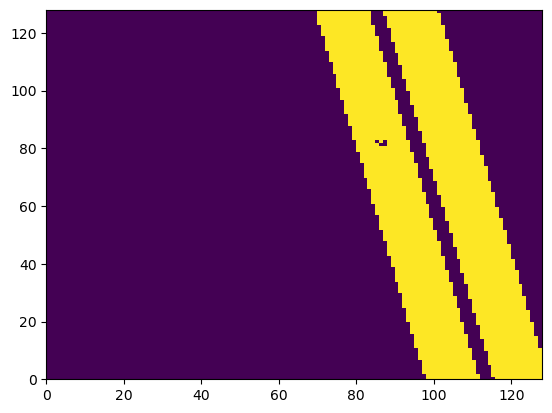

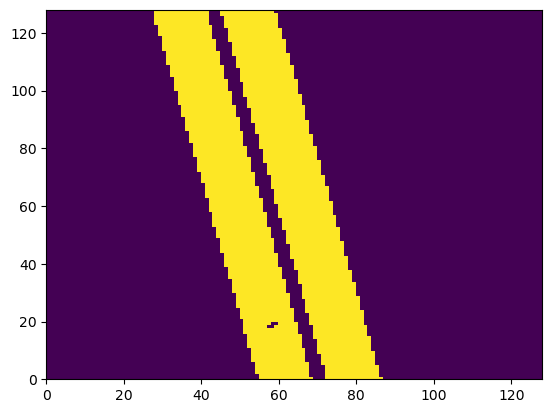

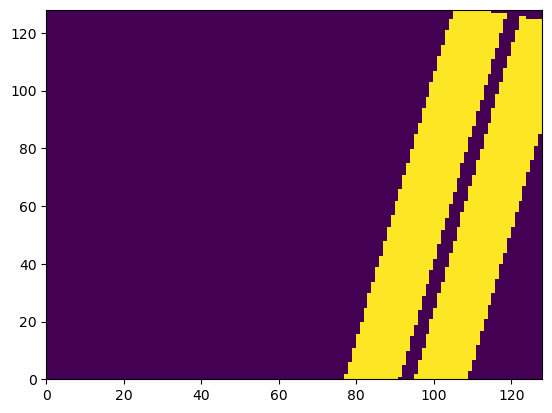

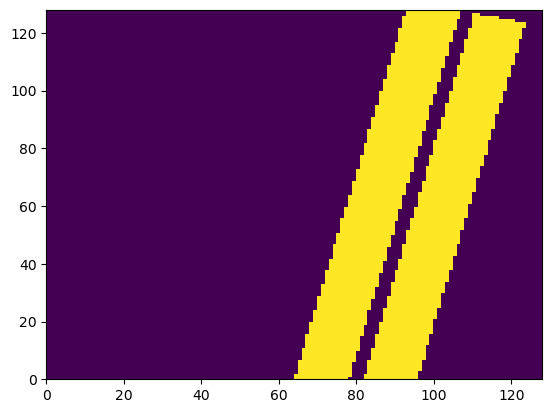

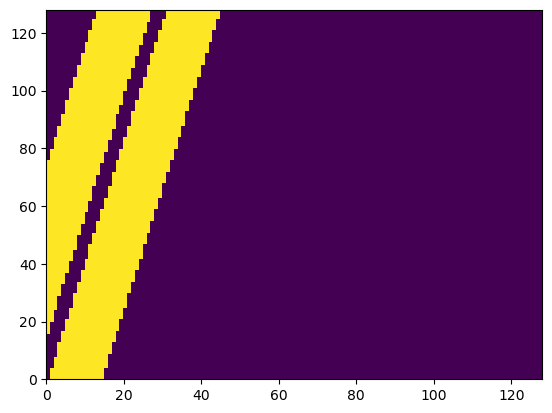

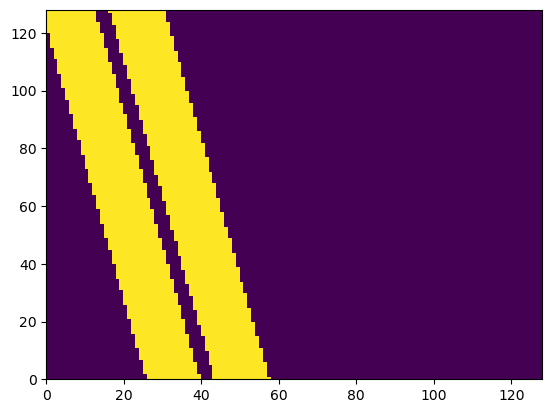

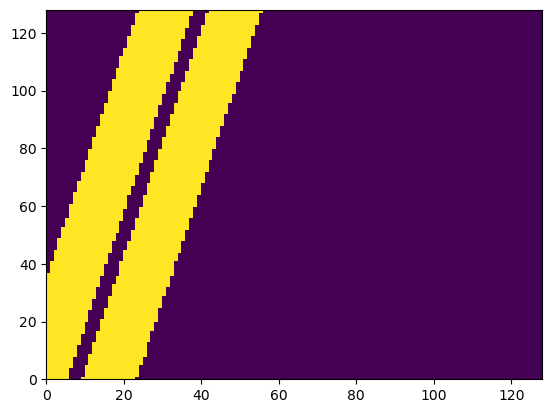

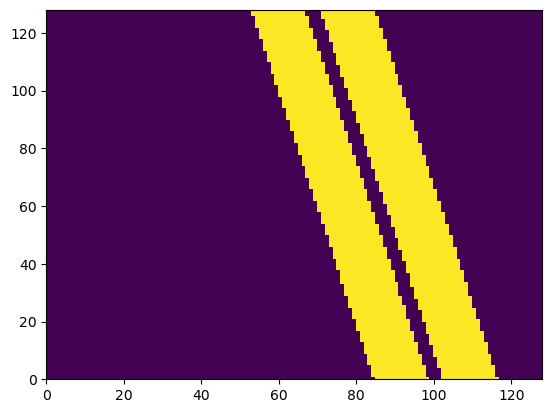

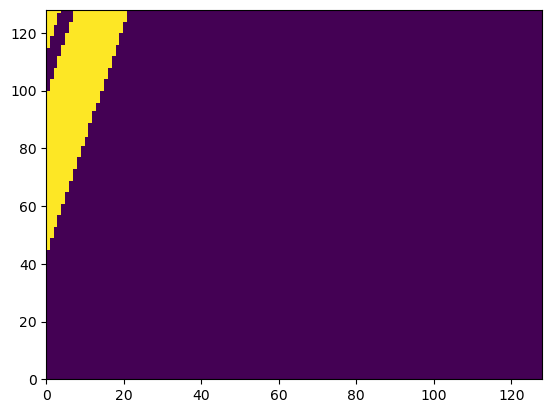

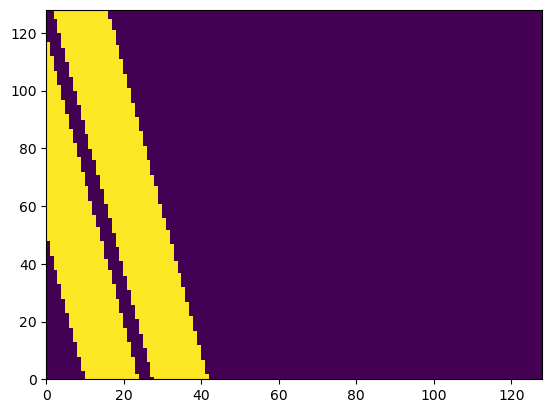

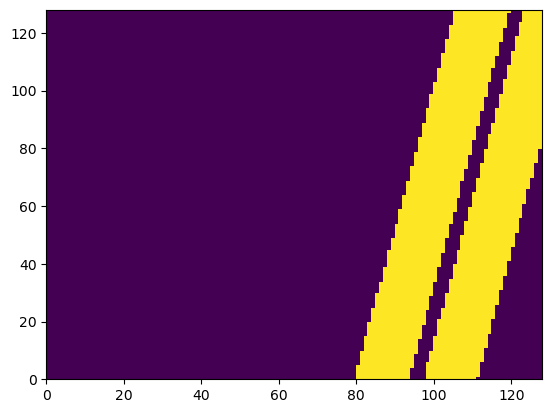

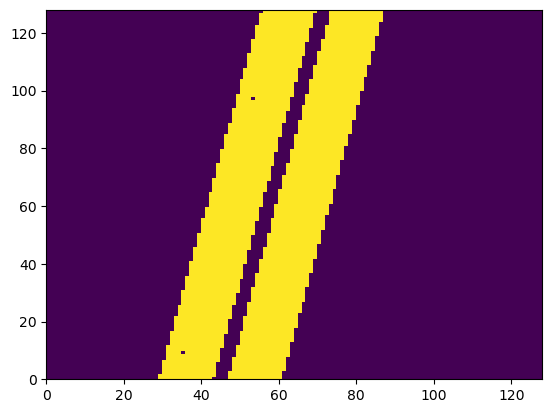

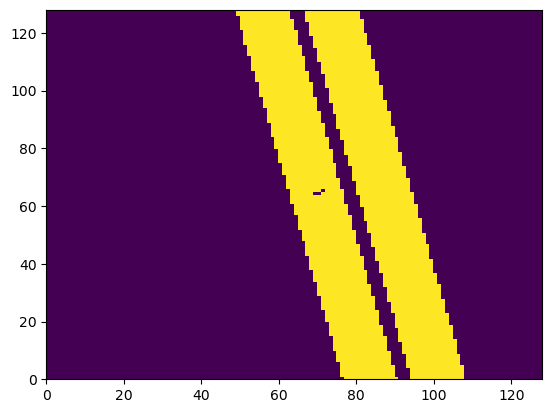

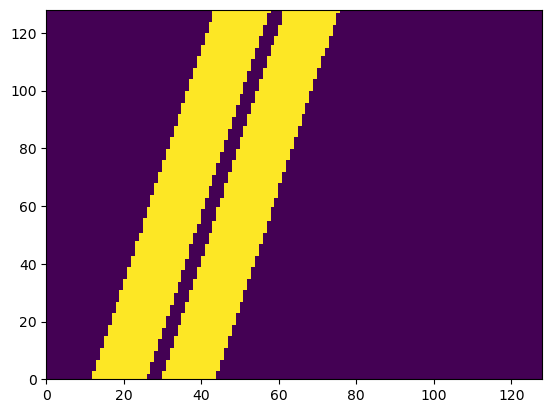

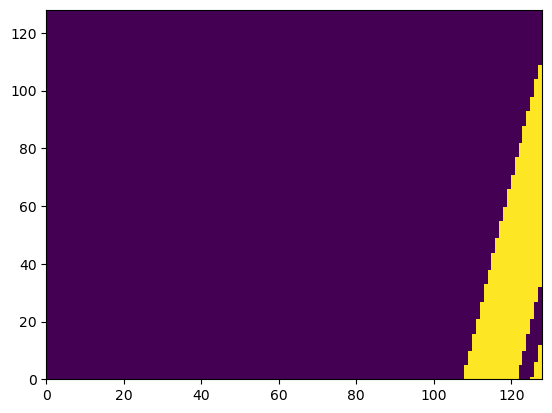

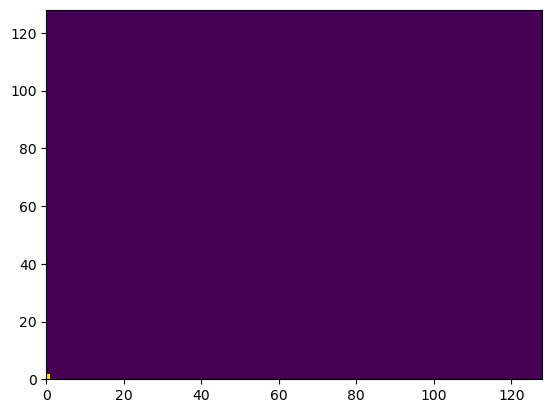

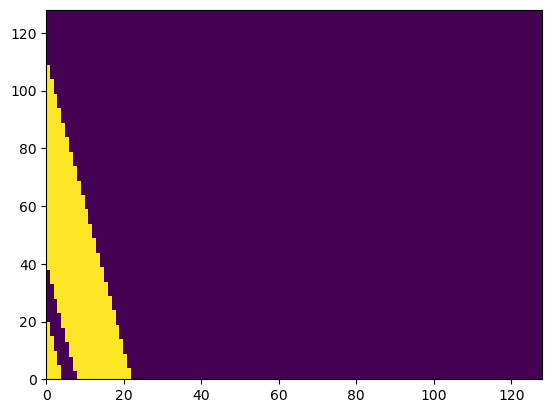

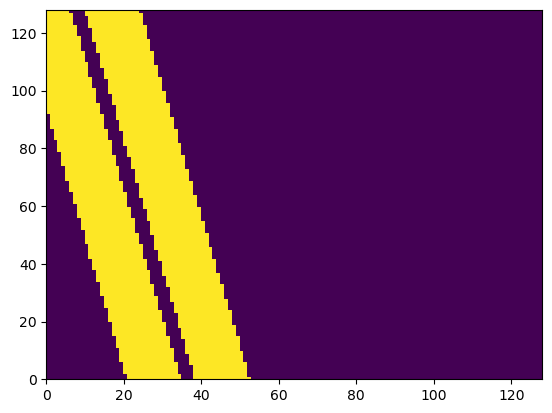

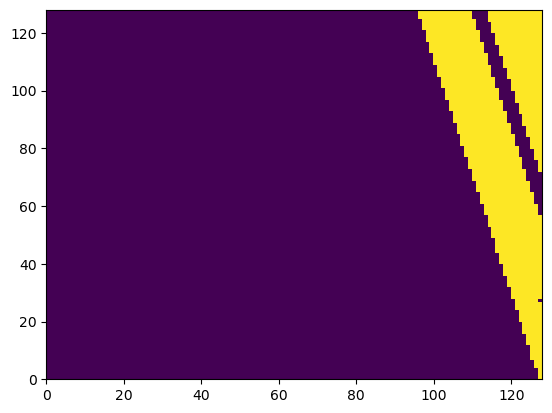

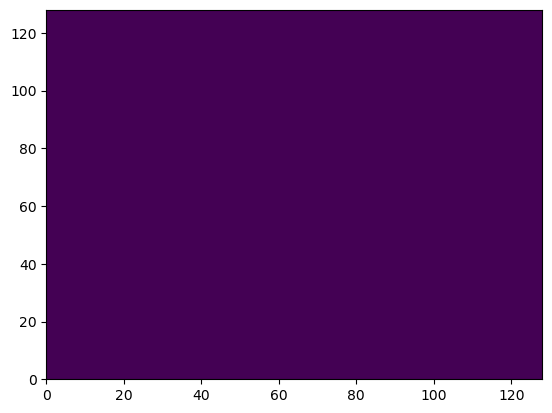

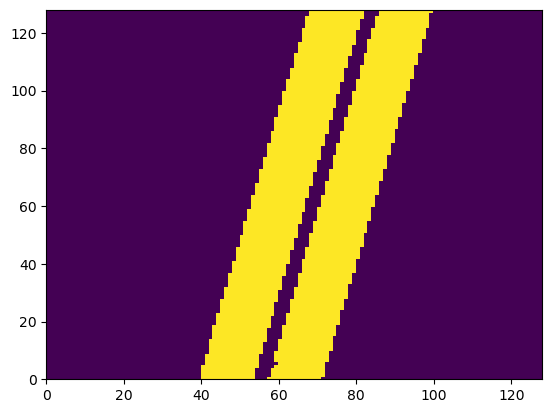

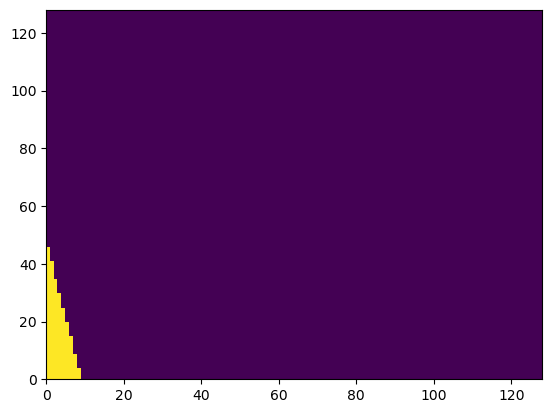

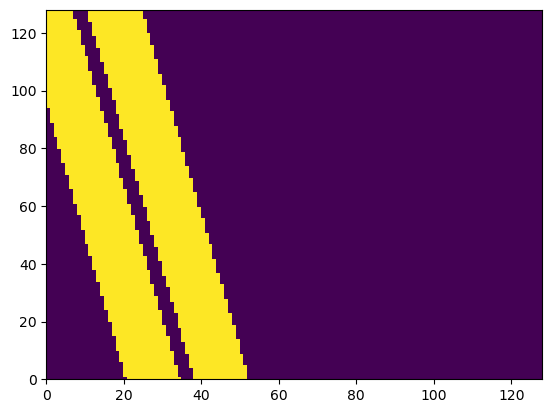

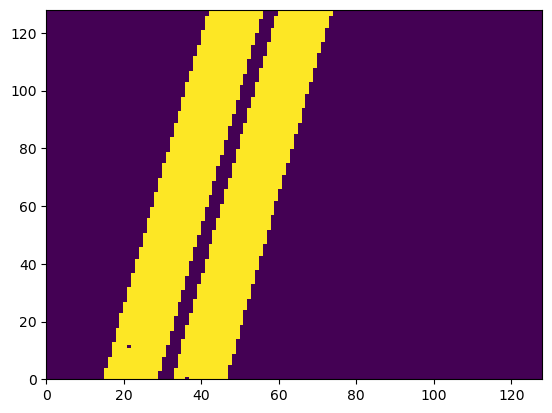

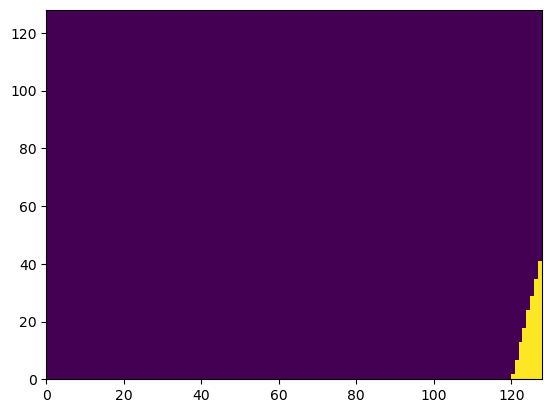

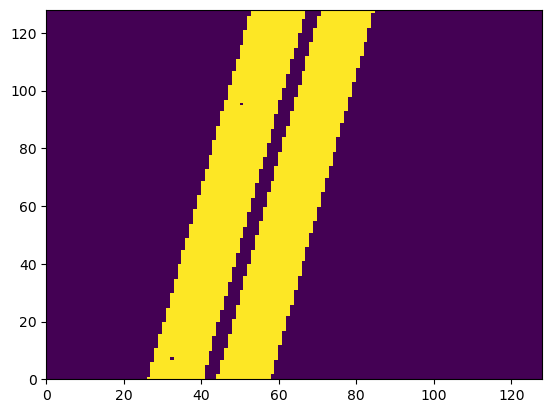

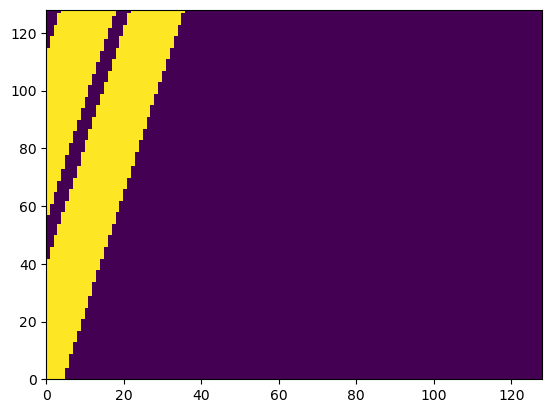

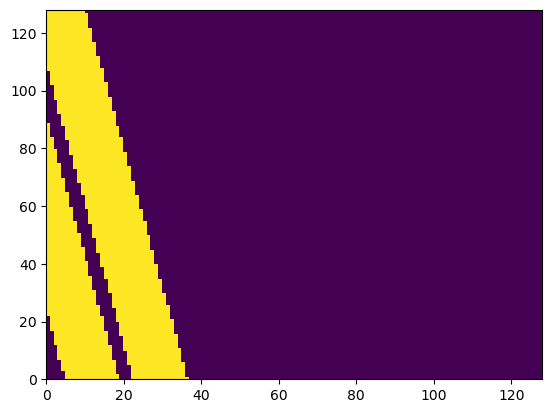

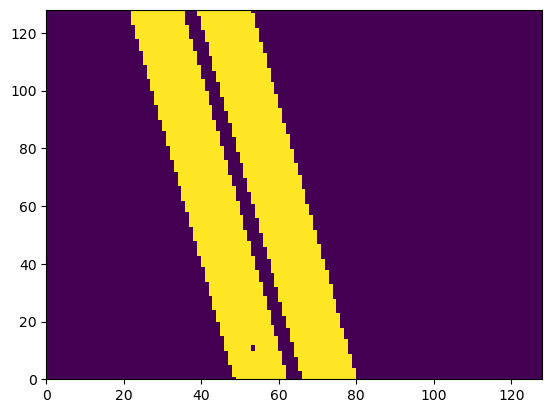

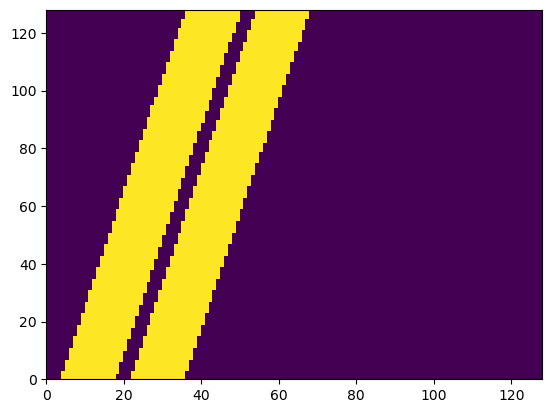

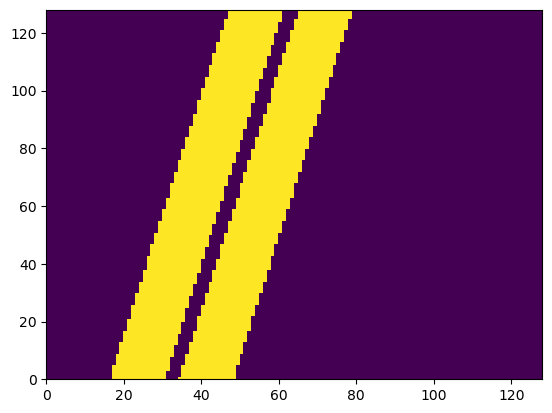

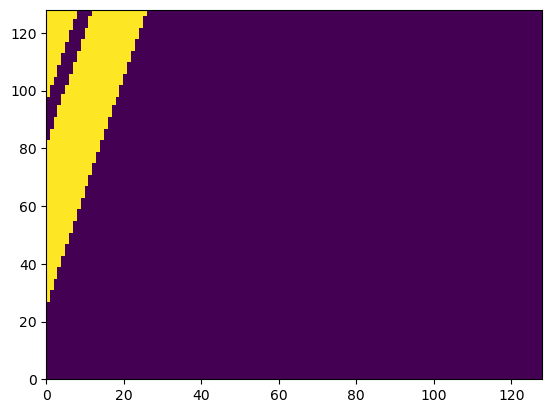

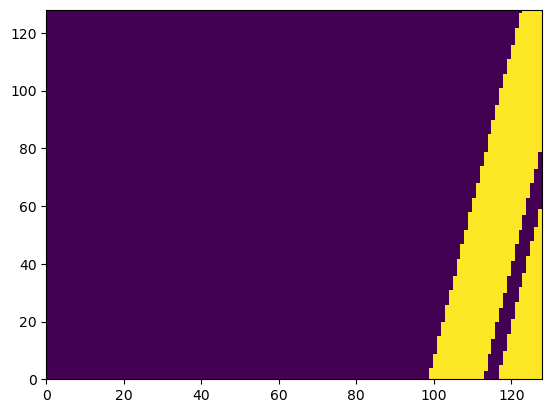

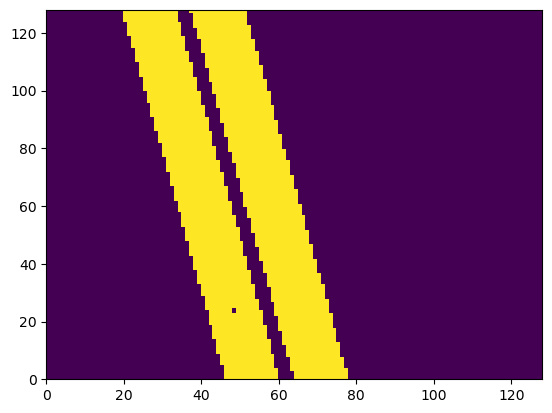

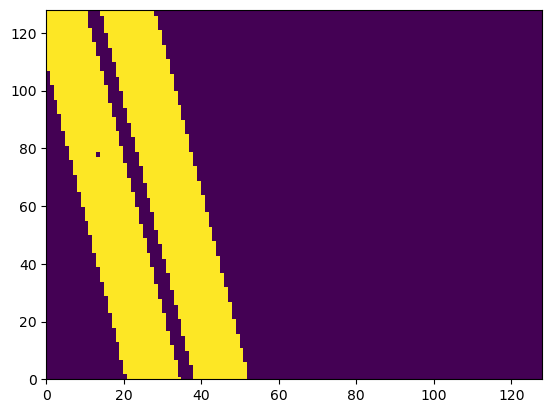

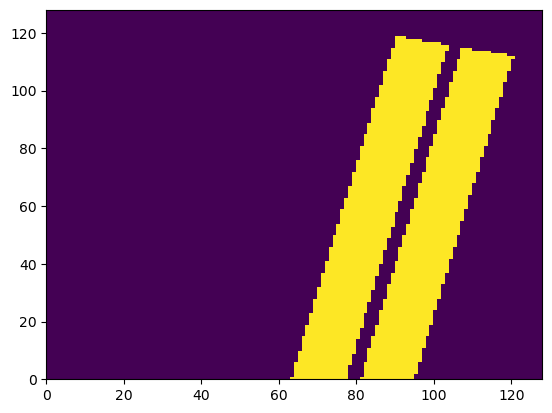

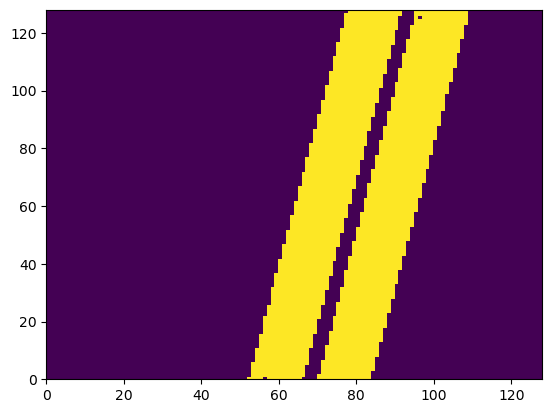

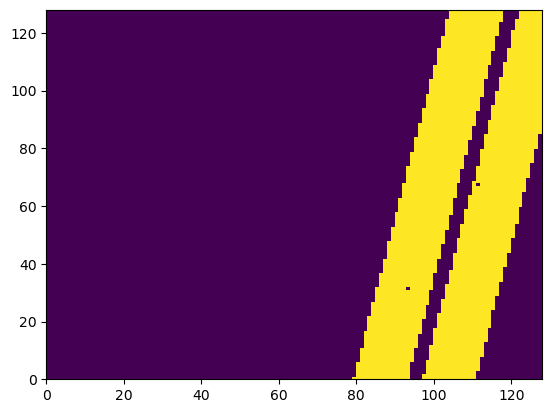

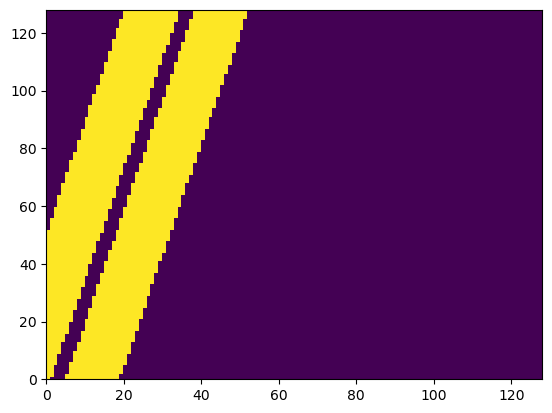

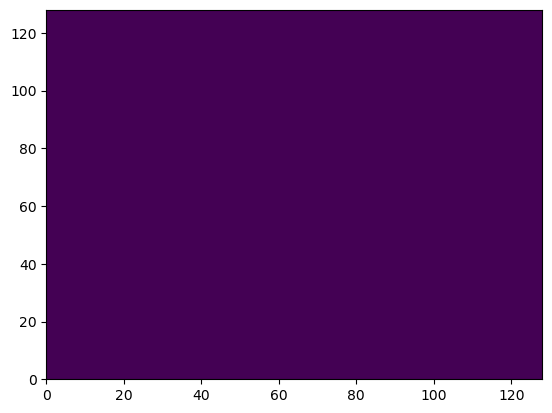

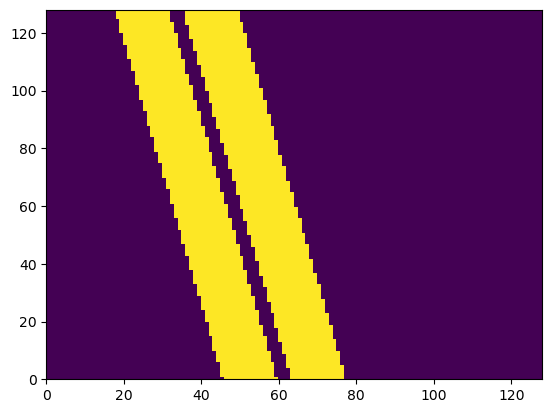

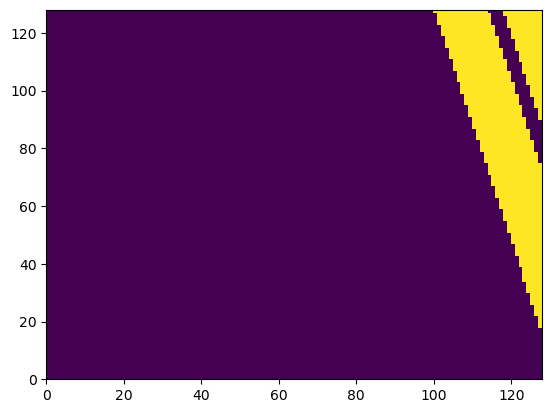

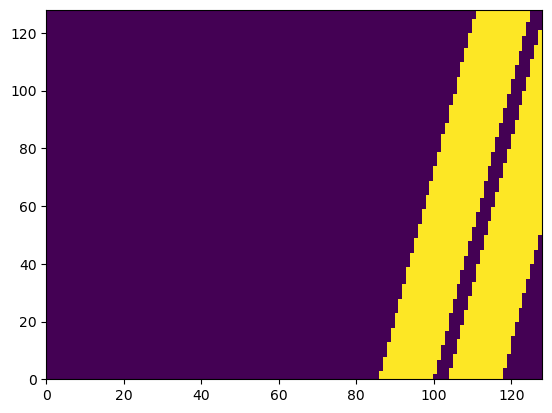

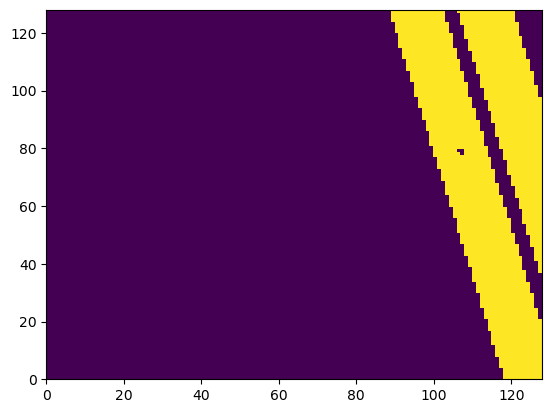

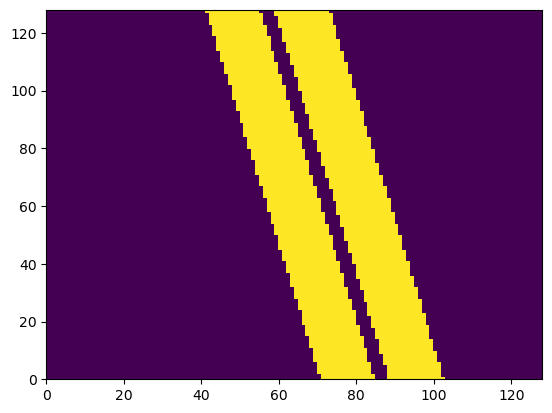

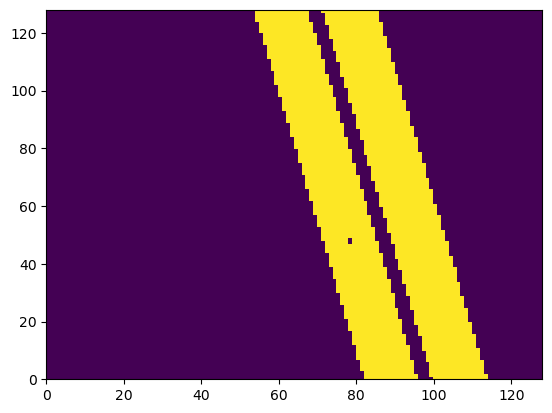

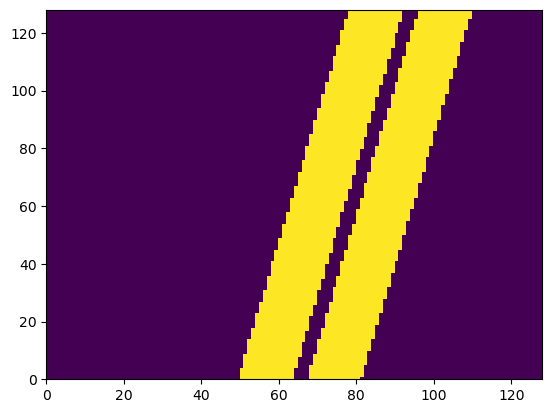

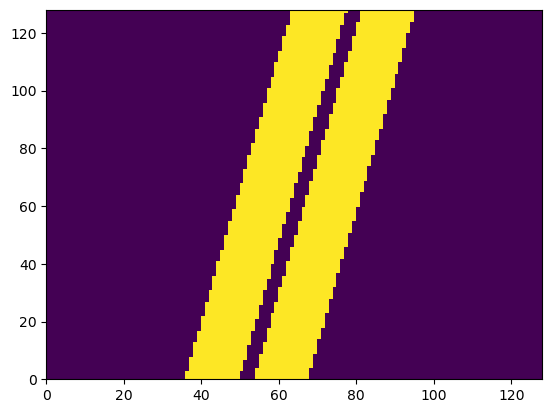

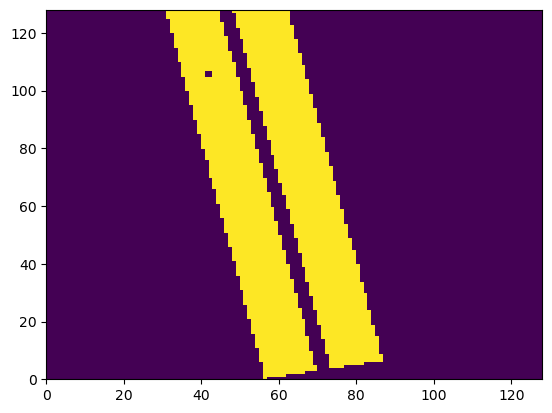

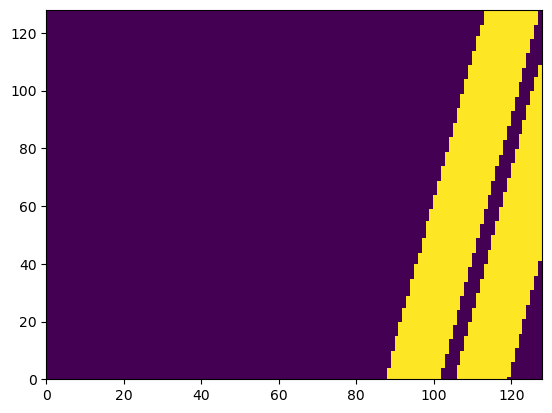

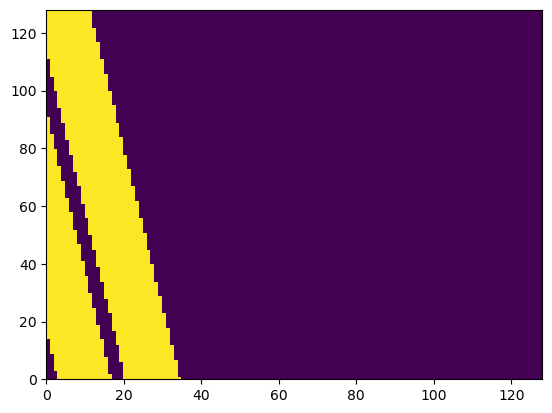

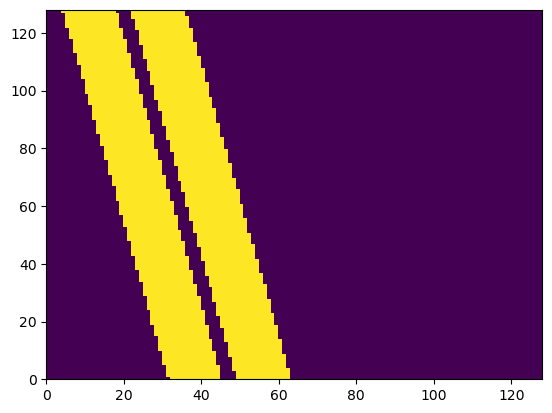

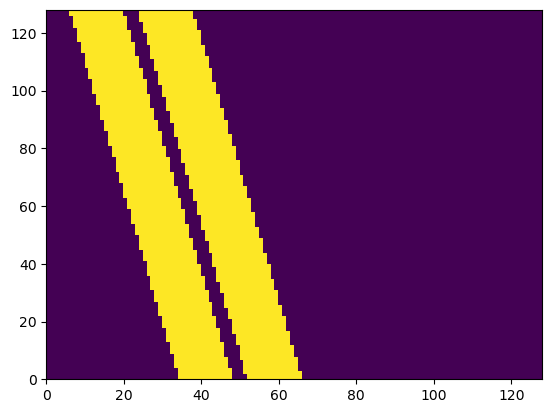

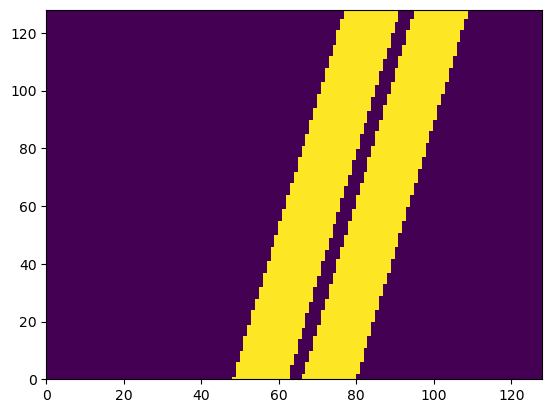

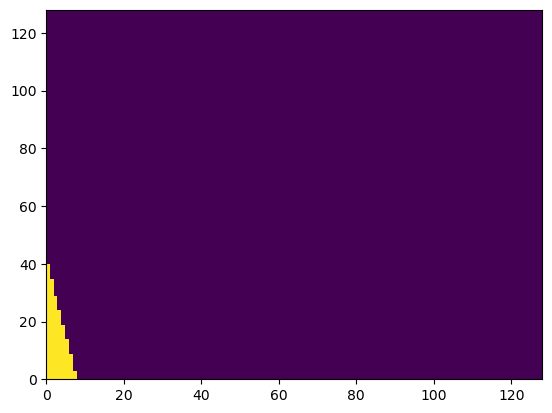

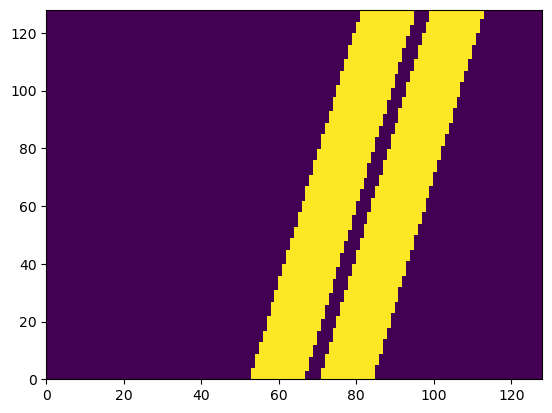

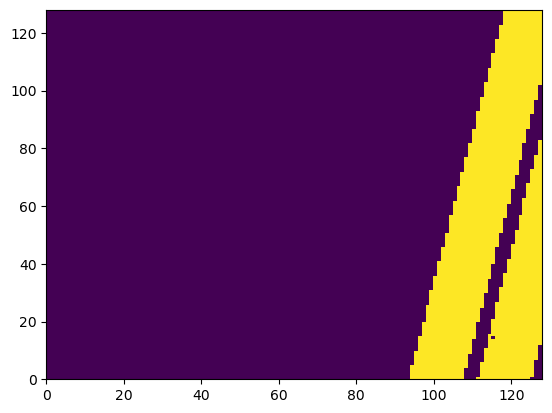

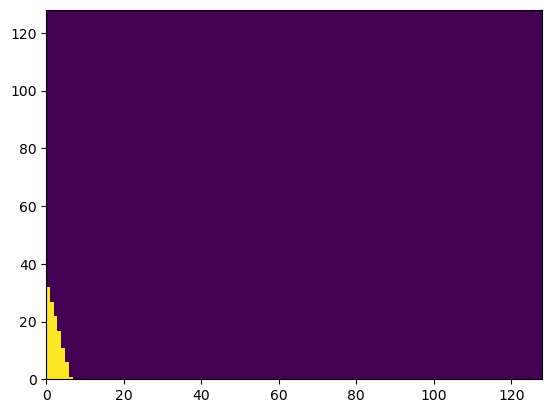

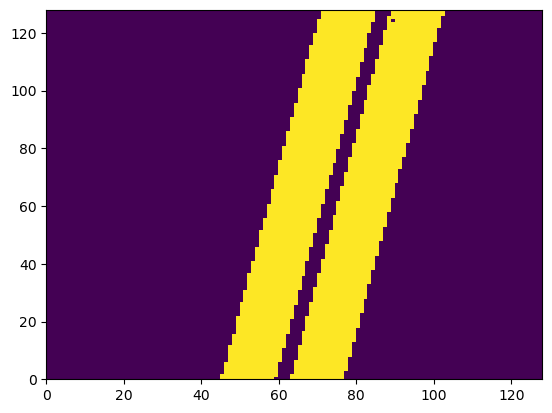

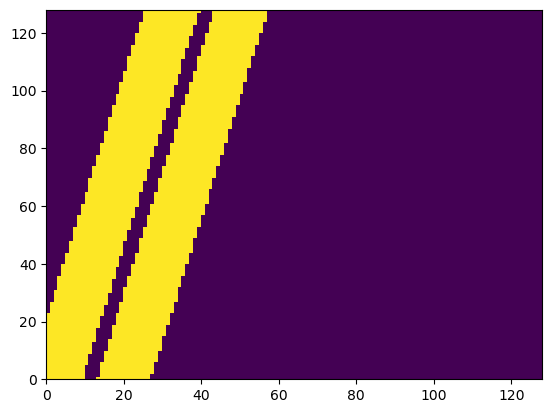

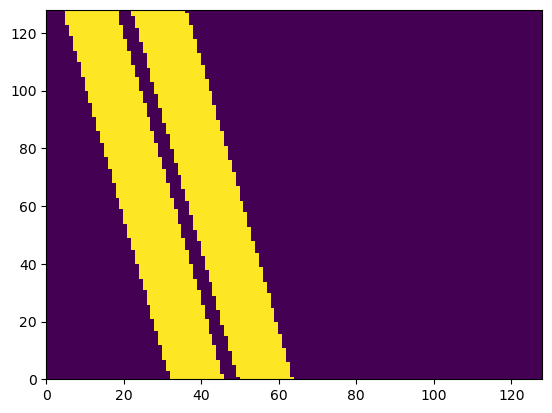

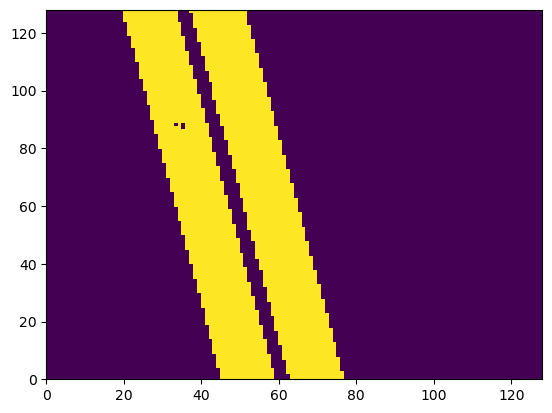

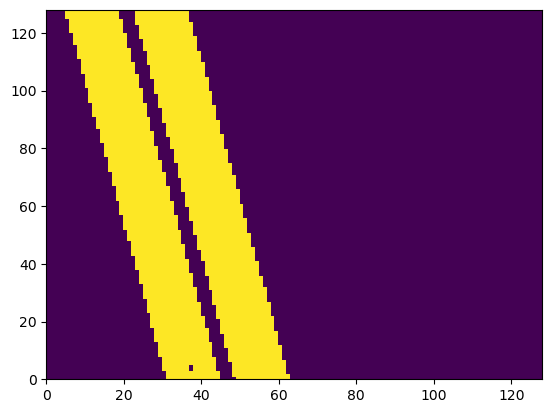

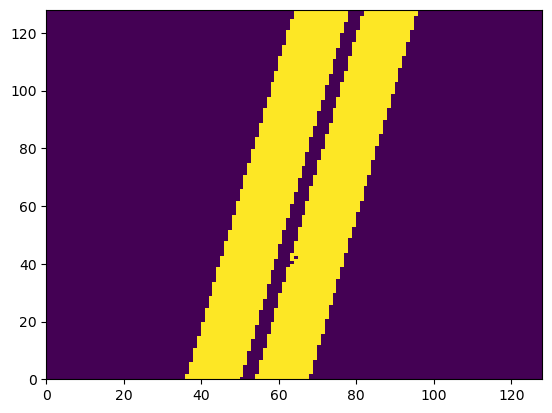

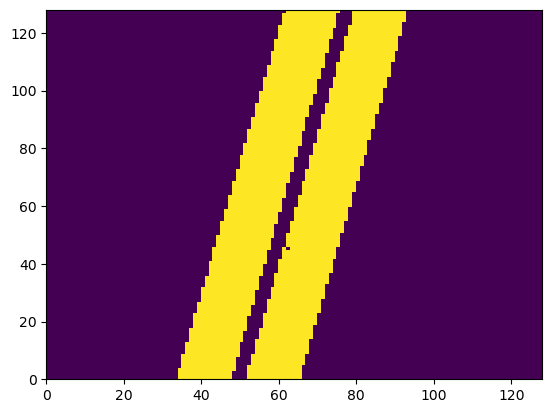

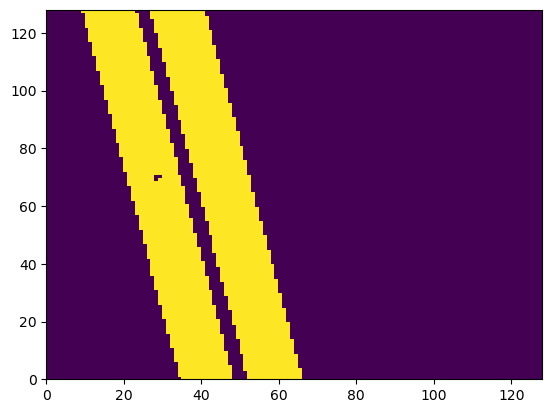

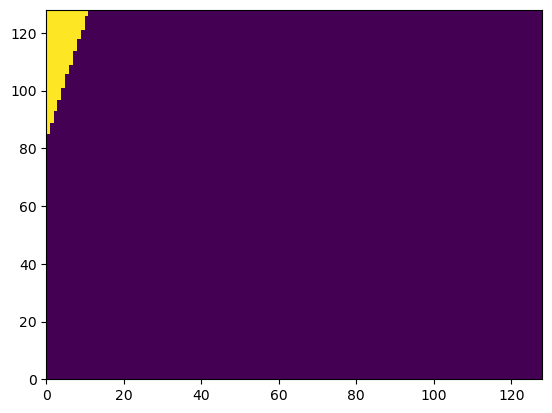

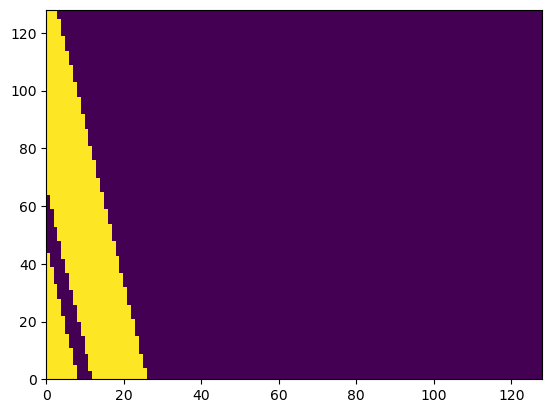

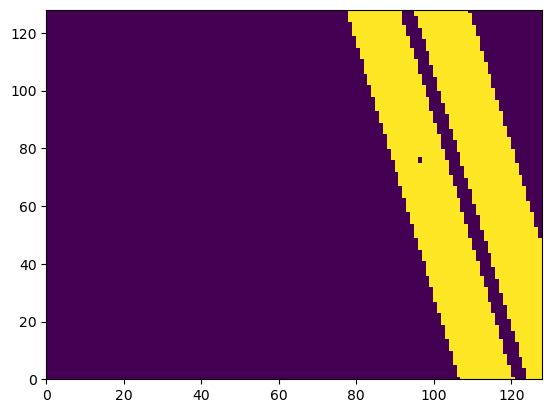

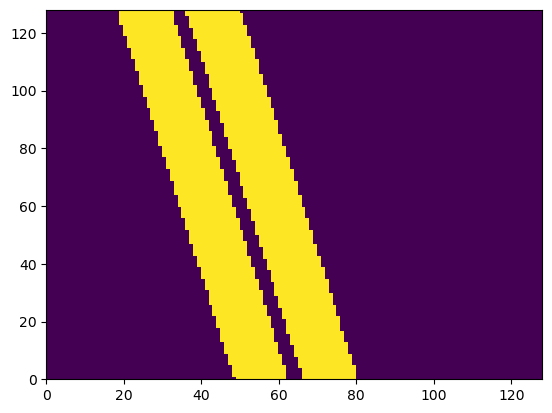

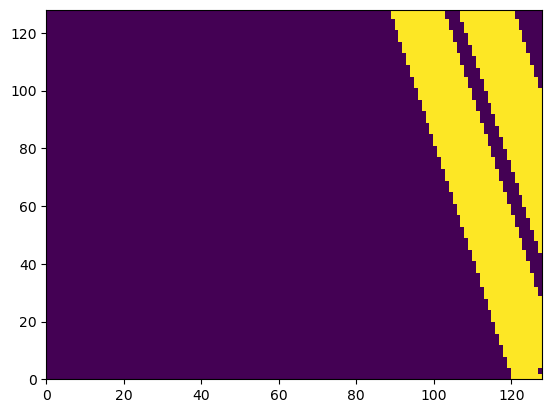

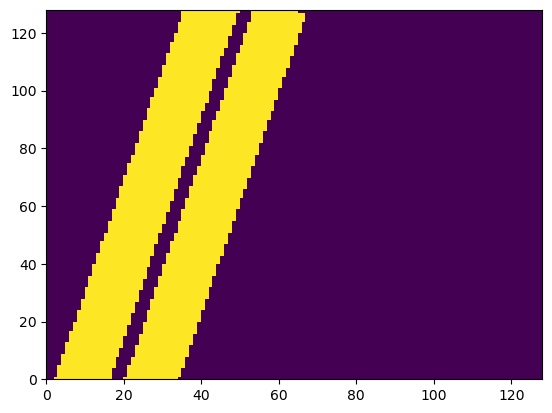

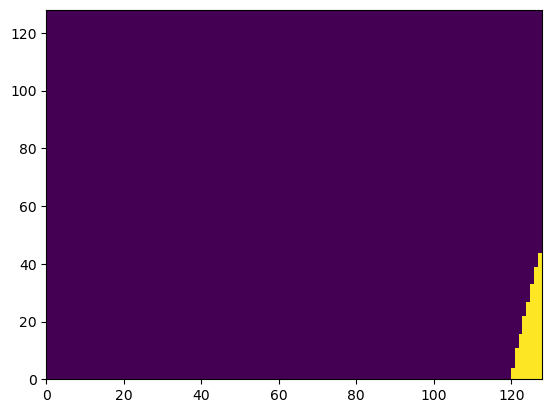

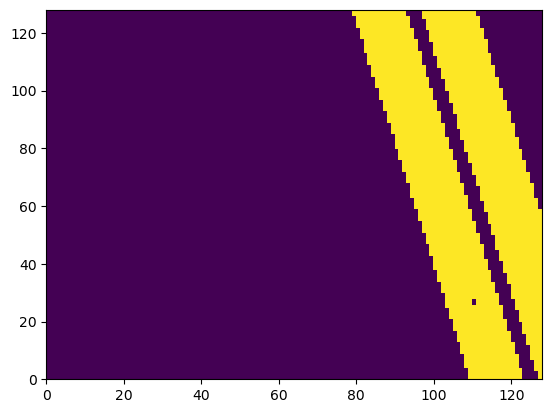

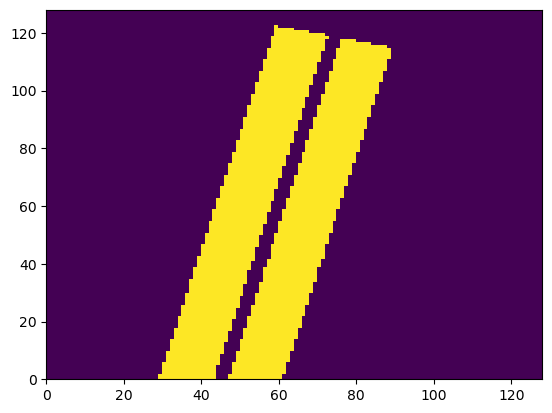

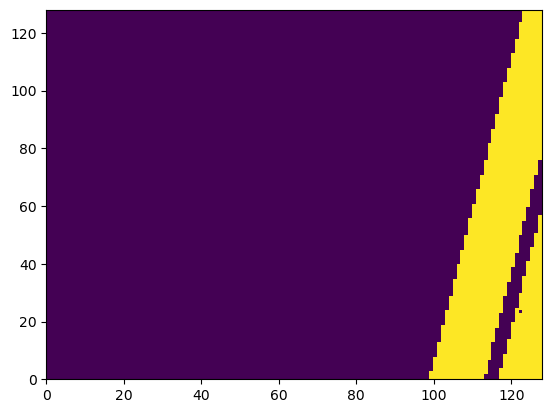

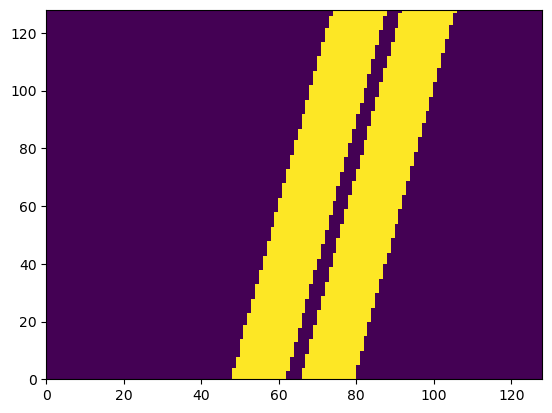

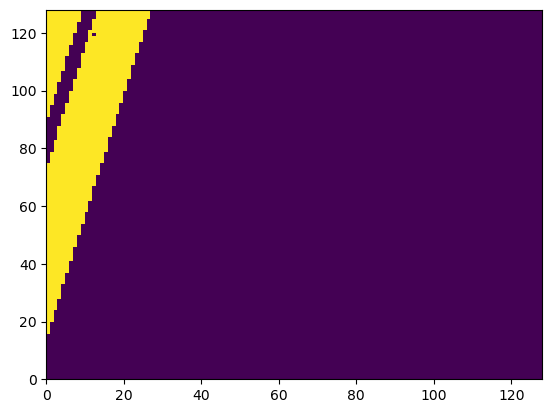

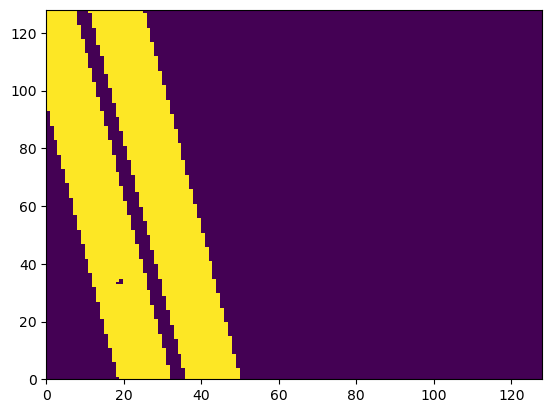

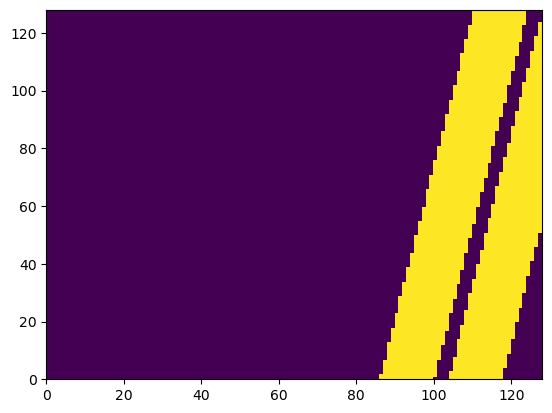

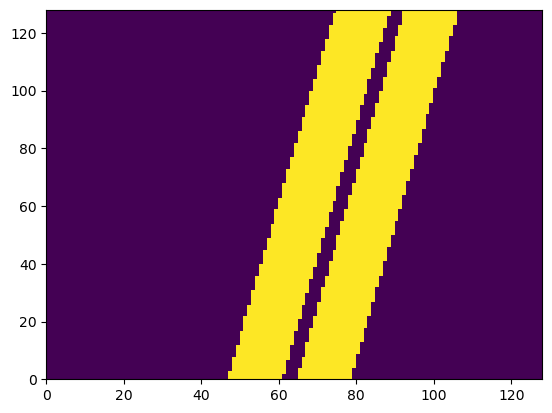

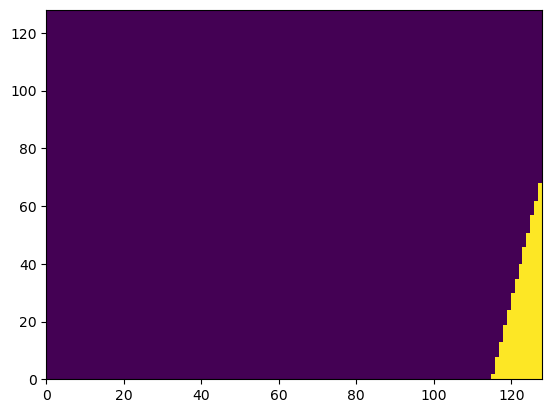

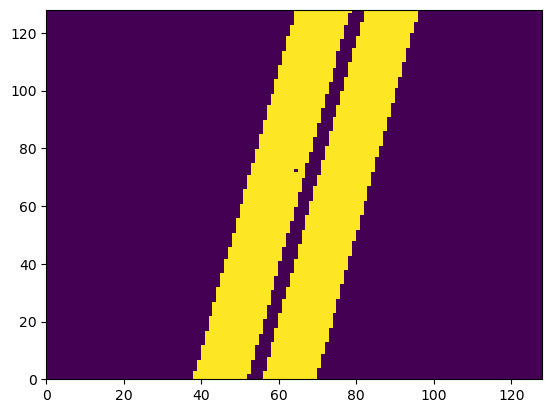

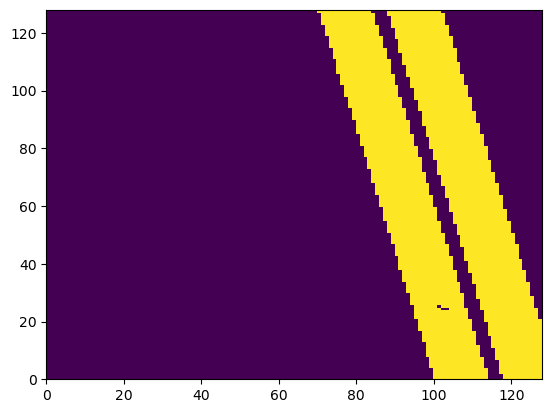

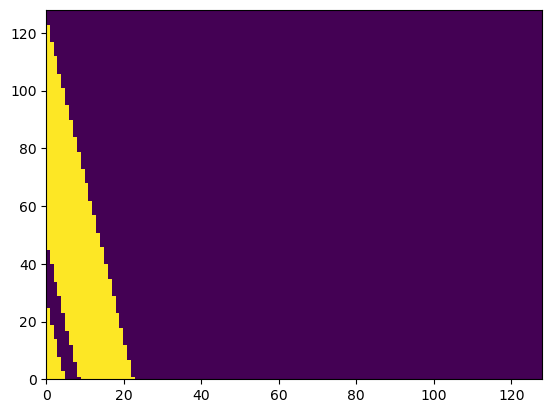

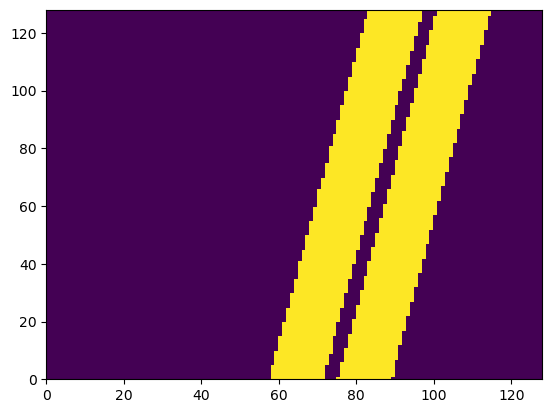

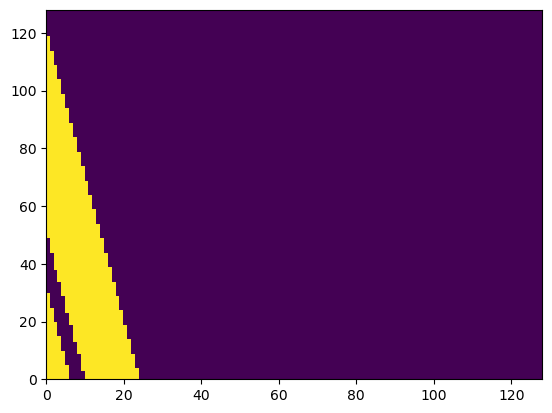

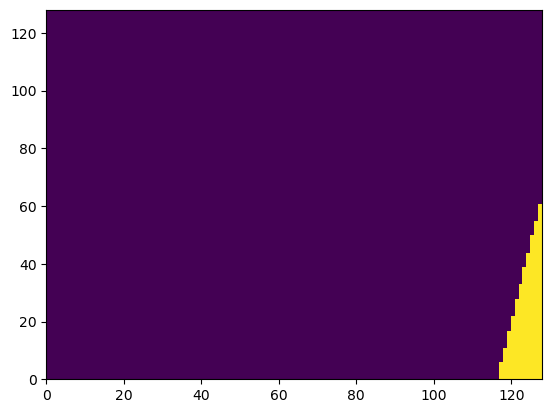

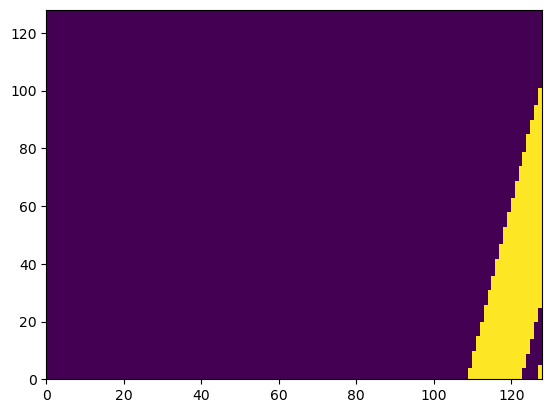

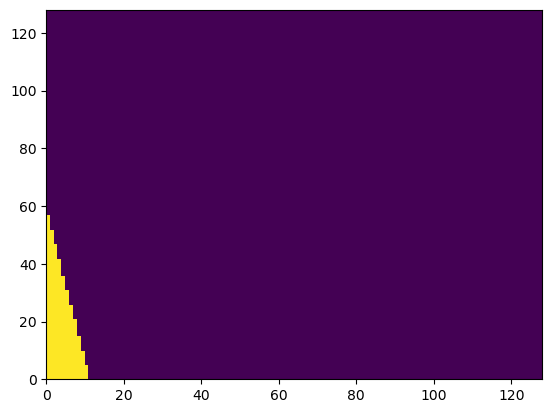

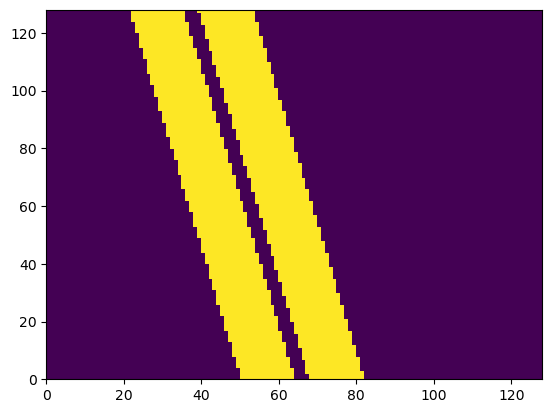

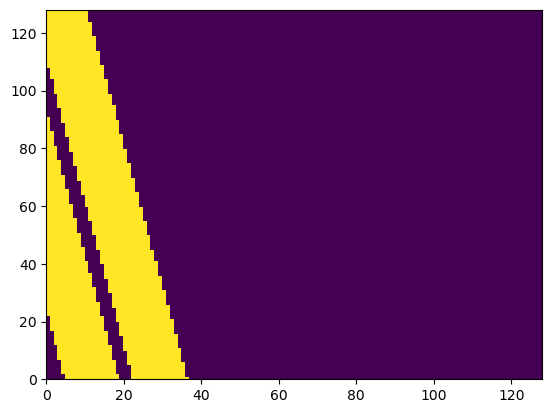

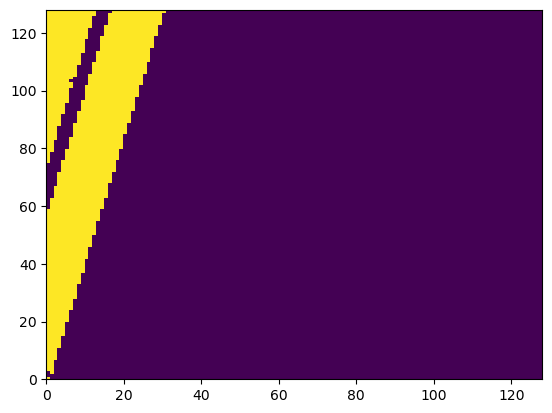

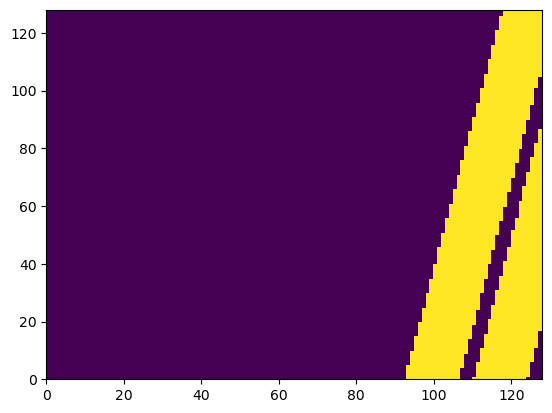

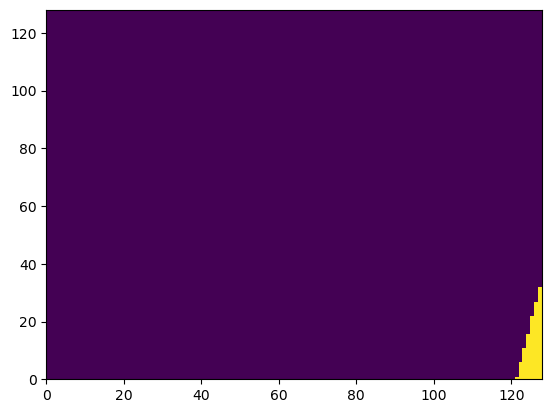

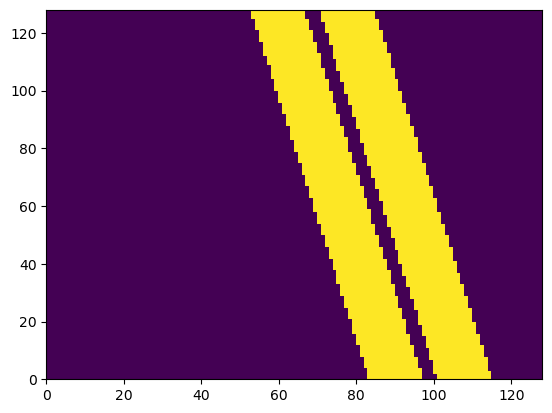

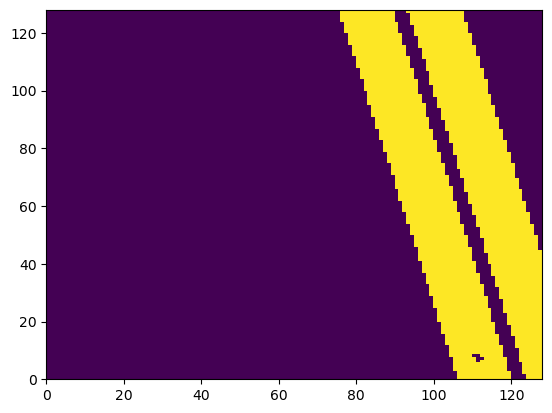

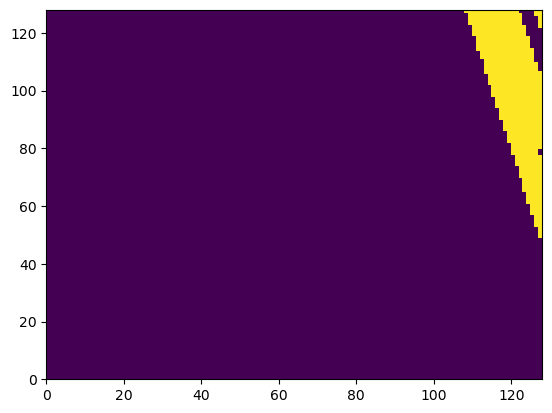

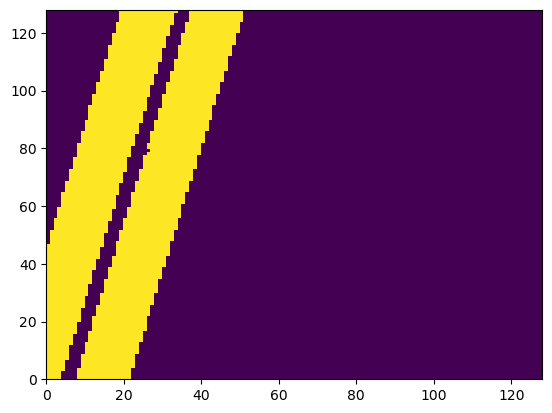


KeyboardInterrupt



In [102]:
for i in range(0,len(random_masks)):
    plt.pcolor(random_masks[i][0])
    plt.pcolor(random_masks[i][1])
    plt.show()
    plt.close()

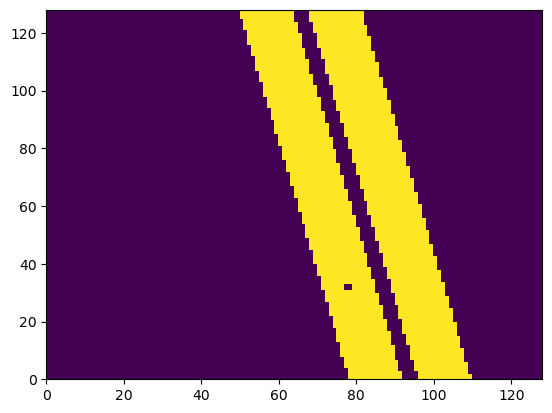

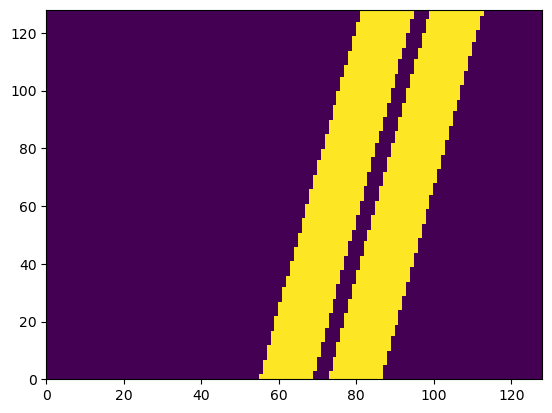

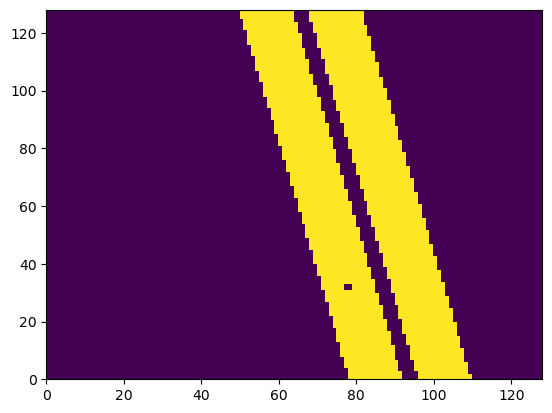

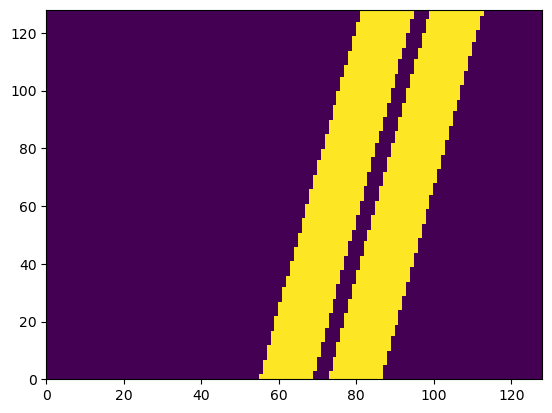

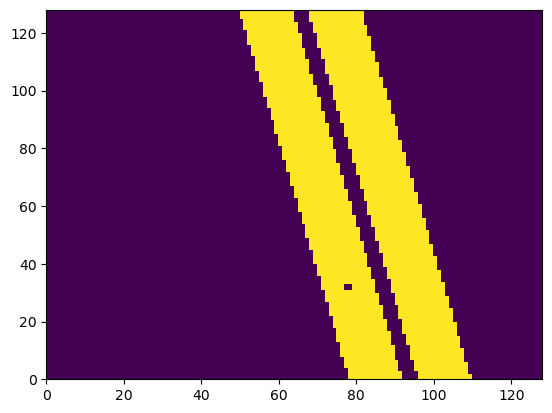

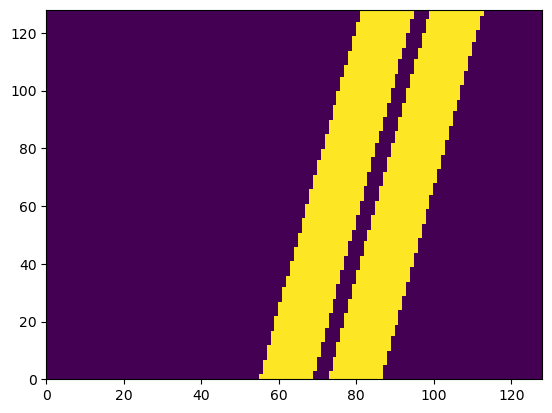

In [25]:
for i in range(0,len(random_masks[0])):
    plt.pcolor(random_masks[4][i])
    plt.show()
    plt.close()

In [29]:
sw_corner = [-152.8, 30.3]
ne_corner = [-149.8, 42.3]
lons = []
lats = []

for i in range(10000):
    lons.append(np.random.uniform(sw_corner[0], ne_corner[0]))
    lats.append(np.random.uniform(sw_corner[1], ne_corner[1]))



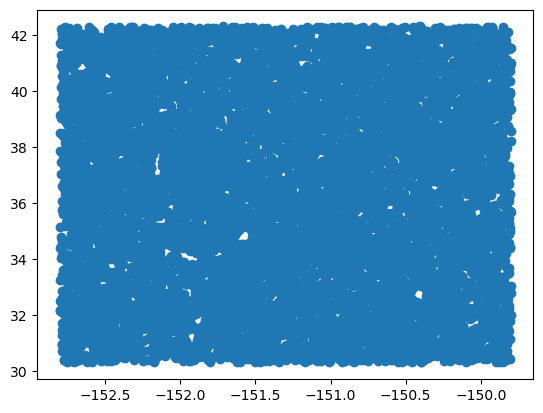

In [30]:
plt.scatter(lons,lats)

In [31]:
random_masks_tensor = np.asarray(random_masks)

In [32]:
random_masks_tensor.shape

(15, 6, 128, 128)

In [ ]:
catalog = xr.open_zarr(f"/home/tm3076/scratch/pytorch_learning_tiles/HRS_SST_tiles/agg_cloud_percentages/catalog.zarr").compute()
rho_catalog_filtered = catalog.where(catalog.rho>.8,drop="True")


In [ ]:
PATH = "/home/tm3076/scratch/pytorch_learning_tiles/HRS_SST_tiles/agg_cloud_masks"
masks = []
for i in range(2):
    rand_i_time = np.random.randint(len(rho_catalog_filtered.i_time))
    patch_id = str(int(rho_catalog_filtered.isel(i_time=rand_i_time).patch_id.values)).zfill(3)
    i_time = int(rho_catalog_filtered.isel(i_time=rand_i_time).patch_timestep.values)
    print("patch_id",patch_id)
    print("i_time",i_time)
    cloud_mask = xr.open_dataset(f"{PATH}/{patch_id}.nc").sst_filtered_q5.isel(time=i_time)
    cloud_mask.plot()
    masks.append(cloud_mask.values)
    plt.show()
    plt.close()

In [ ]:
np.stack(masks,axis=0).shape

In [ ]:

test = xr.open_zarr(f"{PATH}/001.zarr").sla_filtered

In [ ]:
number = 199
formatted_number = f"{number:03}" # Result: "007"
formatted_number

In [ ]:



random_tile = xr.open_zarr(f"{PATH}/002.zarr").sla_filtered
random_tile = random_tile.resample(time="1D").mean()
for t in range(len(random_tile.time)):
    print(t)
    fig, axs = plt.subplots(1,1,figsize=(15,10))
    im0 = axs.pcolor(random_tile.isel(time=np.random.randint(len(random_tile.time))))
    plt.colorbar(im0,ax=axs)
    plt.show()
    plt.close()


In [ ]:
mask = y[0,i,0,:,:]
mask_N_t = torch.zeros([20]+list(mask.size()))
mask_N_t.shape

In [ ]:
N_t = 20
N_t / 2

# Test masked loss function

In [ ]:
import torch

# Compute loss with optional masking
def compute_loss_test(y,y_hat,masked_loss=True):        
    alpha0,alpha1,alpha2=1,1,1
    mse = lambda a, b: ((a - b) ** 2)
    def grad2d(u):
        dx = u[..., :, 1:] - u[..., :, :-1]
        dy = u[..., 1:, :] - u[..., :-1, :]
        return dx, dy
    def grad2d_second(u):
        dxx = u[..., :, 2:] - 2 * u[..., :, 1:-1] + u[..., :, :-2]
        dyy = u[..., 2:, :] - 2 * u[..., 1:-1, :] + u[..., :-2, :]
        return dxx, dyy


    if masked_loss:
        # mask == 1 where y is not zero
        mask = (y != 0).float()
        # Main loss only over unmasked elements
        per_element_loss = mse(y, y_hat) * mask
        loss = per_element_loss.sum() / mask.sum().clamp_min(1.0)
        
        fig,axs=plt.subplots(2,2,figsize=(15,10))
        axs=axs.flatten()
        ims=[axs[0].pcolor(mask),axs[1].pcolor(y),
             axs[2].pcolor(y_hat),axs[3].pcolor(per_element_loss)]
        axs[0].set_title("mask")
        axs[1].set_title("y")
        axs[2].set_title("y_hat")
        axs[3].set_title("loss")
        for i, im in enumerate(ims):
            plt.colorbar(im,ax=axs[i])
        plt.show()
        plt.close()
        
        # Gradients: mask central pixels to avoid border artifacts
        central_mask_x = (mask[..., :, 1:] * mask[..., :, :-1])
        central_mask_y = (mask[..., 1:, :] * mask[..., :-1, :])
        dx_y, dy_y = grad2d(y)
        dx_yh, dy_yh = grad2d(y_hat)
        
        fig,axs=plt.subplots(2,2,figsize=(15,10))
        axs=axs.flatten()
        ims=[axs[0].pcolor(dx_y*central_mask_x),axs[1].pcolor(dy_y*central_mask_y),
             axs[2].pcolor(dx_yh*central_mask_x),axs[3].pcolor(dy_yh*central_mask_y)]
        axs[0].set_title("dx_y")
        axs[1].set_title("dy_y*central_mask_y")
        axs[2].set_title("dx_yh*central_mask_x")
        axs[3].set_title("dy_yh*central_mask_y")
        for i, im in enumerate(ims):
            plt.colorbar(im,ax=axs[i])
        plt.show()
        plt.close()
        
        grad_loss_x = mse(dx_y, dx_yh) * central_mask_x
        grad_loss_y = mse(dy_y, dy_yh) * central_mask_y
        loss_grad = (
            grad_loss_x.sum() / central_mask_x.sum().clamp_min(1.0)
            + grad_loss_y.sum() / central_mask_y.sum().clamp_min(1.0)
        )
        # Second gradients: mask central pixels
        central_mask_xx = (mask[..., :, 2:] * mask[..., :, 1:-1] * mask[..., :, :-2])
        central_mask_yy = (mask[..., 2:, :] * mask[..., 1:-1, :] * mask[..., :-2, :])
        dxx_y, dyy_y = grad2d_second(y)
        dxx_yh, dyy_yh = grad2d_second(y_hat)
        
        fig,axs=plt.subplots(2,2,figsize=(15,10))
        axs=axs.flatten()
        ims=[axs[0].pcolor(dxx_y*central_mask_xx),axs[1].pcolor(dxx_yh*central_mask_xx),
             axs[2].pcolor(dyy_y*central_mask_yy),axs[3].pcolor(dyy_yh*central_mask_yy)]
        axs[0].set_title("dxx_y*central_mask_xx")
        axs[1].set_title("dxx_yh*central_mask_xx")
        axs[2].set_title("dyy_y*central_mask_yy")
        axs[3].set_title("dyy_yh*central_mask_yy")
        for i, im in enumerate(ims):
            plt.colorbar(im,ax=axs[i])
        plt.show()
        plt.close()
        
        grad2_loss_x = mse(dxx_y, dxx_yh) * central_mask_xx
        grad2_loss_y = mse(dyy_y, dyy_yh) * central_mask_yy

        fig,axs=plt.subplots(1,2,figsize=(15,6))
        axs=axs.flatten()
        ims=[axs[0].pcolor(grad2_loss_x),axs[1].pcolor(grad2_loss_y),
             ]
        axs[0].set_title("grad2_loss_x")
        axs[1].set_title("grad2_loss_y")
        for i, im in enumerate(ims):
            plt.colorbar(im,ax=axs[i])
        plt.show()
        plt.close()
        
        loss_grad2 = (
            grad2_loss_x.sum() / central_mask_xx.sum().clamp_min(1.0)
            + grad2_loss_y.sum() / central_mask_yy.sum().clamp_min(1.0)
        )
    else:
        # Unmasked case: treat all pixels as valid
        valid_count = torch.numel(y)
        per_element_loss = mse(y, y_hat)
        loss = per_element_loss.sum() / valid_count
        dx_y, dy_y = grad2d(y)
        dx_yh, dy_yh = grad2d(y_hat)
        grad_loss_x = mse(dx_y, dx_yh)
        grad_loss_y = mse(dy_y, dy_yh)

        # For gradients, the counts are smaller because of the shifts:
        count_dx = dx_y.numel()
        count_dy = dy_y.numel()
        loss_grad = (
            grad_loss_x.sum() / count_dx
            + grad_loss_y.sum() / count_dy
        )
        dxx_y, dyy_y = grad2d_second(y)
        dxx_yh, dyy_yh = grad2d_second(y_hat)
        count_dxx = dxx_y.numel()
        count_dyy = dyy_y.numel()
        grad2_loss_x = mse(dxx_y, dxx_yh)
        grad2_loss_y = mse(dyy_y, dyy_yh)
        loss_grad2 = (
            grad2_loss_x.sum() / count_dxx
            + grad2_loss_y.sum() / count_dyy
        )
        fig,axs=plt.subplots(2,2,figsize=(15,10))
        axs=axs.flatten()
        ims=[axs[0].pcolor(loss_grad_x),axs[1].pcolor(loss_grad_y),
             axs[2].pcolor(loss_grad2_x),axs[3].pcolor(loss_grad2_y)]
        axs[0].set_title("loss_grad_x")
        axs[1].set_title("loss_grad_y")
        axs[2].set_title("loss_grad2_x")
        axs[3].set_title("loss_grad2_y")
        for i, im in enumerate(ims):
            plt.colorbar(im,ax=axs[i])
        plt.show()
        plt.close()

    total_loss = alpha0 * loss + alpha1 * loss_grad + alpha2 * loss_grad2
    return total_loss



In [ ]:
plt.pcolor(y[i,int(N_t/2),0,:,:])

In [ ]:
compute_loss_test(y[i,int(N_t/2),0,:,:],y[i,int(N_t/2),0,:,:],masked_loss=True)